<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
</center>

## Objectifs : 
<span style="color:  rgb(139, 0, 0)">**Notre projet consiste à analyser et faire des prédictions sur un jeu de données qui fournit un aperçu détaillé des routines d’exercice, des attributs physiques et des mesures de la condition physique des membres d’une salle de sport. Il y a deux objectifs principales pour ce projet :  Le premier objectif est de faire une analyse exploratoire des données pour bien cerner nos données. Dans un second temps, on effectuera deux modélisations avec la prédiction de calories brulées et du niveau d'expérience.**</span>

## Table des matières
1. [Analyse explorative des données (langage R)](#analyse-données)
   - Description général (natures des variables, encodages ...)
   - Analyse descriptive unidimensionnelle et bidimensionnelle
   - ACP des différentes variables
2. [Modélisation (langage R et python)](#modélisation)
   - Prédiction des calories brulées
   - Prédiction du niveau d'expérience
## Analyse explorative des données (langage R)
Cette partie se fera uniquement en R. 

In [ ]:
#install.packages("plotly")
#install.packages("FactoMineR")
#install.packages("factoextra")
#install.packages("glmnet")
#install.packages("ggfortify")
#install.packages("pROC")
#install.packages("ROCR")
#install.packages("gbm")
#install.packages("mlr3")
#install.packages("mlr3learners")
#install.packages("mlr3pipelines")
#install.packages("xgboost")
#install.packages("corrplot")
#install.packages("fastDummies")
#install.packages("rpart.plot")
#install.packages("partykit")
#install.packages("randomForest")
#install.packages("ggRandomForests")


Installation du package dans 'C:/Users/Thomas/AppData/Local/R/win-library/4.4'
(car 'lib' n'est pas spécifié)



le package 'xgboost' a été décompressé et les sommes MD5 ont été vérifiées avec succés

Les packages binaires téléchargés sont dans
	C:\Users\Thomas\AppData\Local\Temp\RtmpIBLNUi\downloaded_packages


In [13]:
# Chargement des librairies nécessaires
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)
library(caret)
library(nnet)
library(mlr3)
library(mlr3learners)
library(mlr3pipelines)
library(RColorBrewer)
library(e1071)
library(rpart)
library(rpart.plot)
library(randomForest)
library(xgboost)
library(MASS)
library(gbm)
library(fastDummies)
library(class)
library(partykit)
library(ggRandomForests)

In [14]:
# Lecture des données
# path="http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
path <- ""
data <- read.table(paste(path, "gym_members_exercise_tracking.csv", sep = ""),
                    sep = ",", header = TRUE)
# Premières lignes du jeu de données
head(data)
# Vérification du contenu
summary(data)

,Age,Gender,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level,BMI
,<int>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,56,Male,88.3,1.71,180,157,60,1.69,1313,Yoga,12.6,3.5,4,3,30.20
2,46,Female,74.9,1.53,179,151,66,1.30,883,HIIT,33.9,2.1,4,2,32.00
3,32,Female,68.1,1.66,167,122,54,1.11,677,Cardio,33.4,2.3,4,2,24.71
4,25,Male,53.2,1.70,190,164,56,0.59,532,Strength,28.8,2.1,3,1,18.41
5,38,Male,46.1,1.79,188,158,68,0.64,556,Strength,29.2,2.8,3,1,14.39
6,56,Female,58.0,1.68,168,156,74,1.59,1116,HIIT,15.5,2.7,5,3,20.55


      Age           Gender           Weight..kg.       Height..m.   
 Min.   :18.00   Length:973         Min.   : 40.00   Min.   :1.500  
 1st Qu.:28.00   Class :character   1st Qu.: 58.10   1st Qu.:1.620  
 Median :40.00   Mode  :character   Median : 70.00   Median :1.710  
 Mean   :38.68                      Mean   : 73.85   Mean   :1.723  
 3rd Qu.:49.00                      3rd Qu.: 86.00   3rd Qu.:1.800  
 Max.   :59.00                      Max.   :129.90   Max.   :2.000  
    Max_BPM         Avg_BPM       Resting_BPM    Session_Duration..hours.
 Min.   :160.0   Min.   :120.0   Min.   :50.00   Min.   :0.500           
 1st Qu.:170.0   1st Qu.:131.0   1st Qu.:56.00   1st Qu.:1.040           
 Median :180.0   Median :143.0   Median :62.00   Median :1.260           
 Mean   :179.9   Mean   :143.8   Mean   :62.22   Mean   :1.256           
 3rd Qu.:190.0   3rd Qu.:156.0   3rd Qu.:68.00   3rd Qu.:1.460           
 Max.   :199.0   Max.   :169.0   Max.   :74.00   Max.   :2.000           

In [15]:
data[, "Gender"] <- as.factor(data[, "Gender"])
data[, "Workout_Type"] <- as.factor(data[, "Workout_Type"])
data[, "Experience_Level"] <- as.factor(data[, "Experience_Level"])
data[, "Workout_Frequency..days.week."] <- as.factor(data[, "Workout_Frequency..days.week."])

In [16]:
# Fonction corrigée avec tidy eval
make_plot <- function(data, var, title, binwidth = NULL) {
  ggplot(data, aes(x = {{ var }})) +
    geom_histogram(aes(y = after_stat(density)),
                   fill = "lightblue",
                   color = "black",
                   binwidth = binwidth) +
    geom_density(alpha = 0.4, color = "blue") +
    ggtitle(title) +
    theme_minimal(base_size = 12)
}

In [17]:
g1 <- make_plot(data, Age, "Âge", 5)
g3 <- make_plot(data, Weight..kg., "Poids (kg)", 5)
g4 <- make_plot(data, Height..m., "Taille (m)", 0.05)
g5 <- make_plot(data, Max_BPM, "BPM Max", 5)
g6 <- make_plot(data, Avg_BPM, "BPM Moyen", 5)
g7 <- make_plot(data, Resting_BPM, "BPM Repos", 5)
g8 <- make_plot(data, Session_Duration..hours., "Durée Session (h)", 0.5)
g9 <- make_plot(data, Calories_Burned, "Calories Brûlées", 50)
g11 <- make_plot(data, Fat_Percentage, "Masse Grasse (%)", 2)
g12 <- make_plot(data, Water_Intake..liters., "Hydratation (L)", 0.2)
g15 <- make_plot(data, BMI, "Indice IMC", 1)


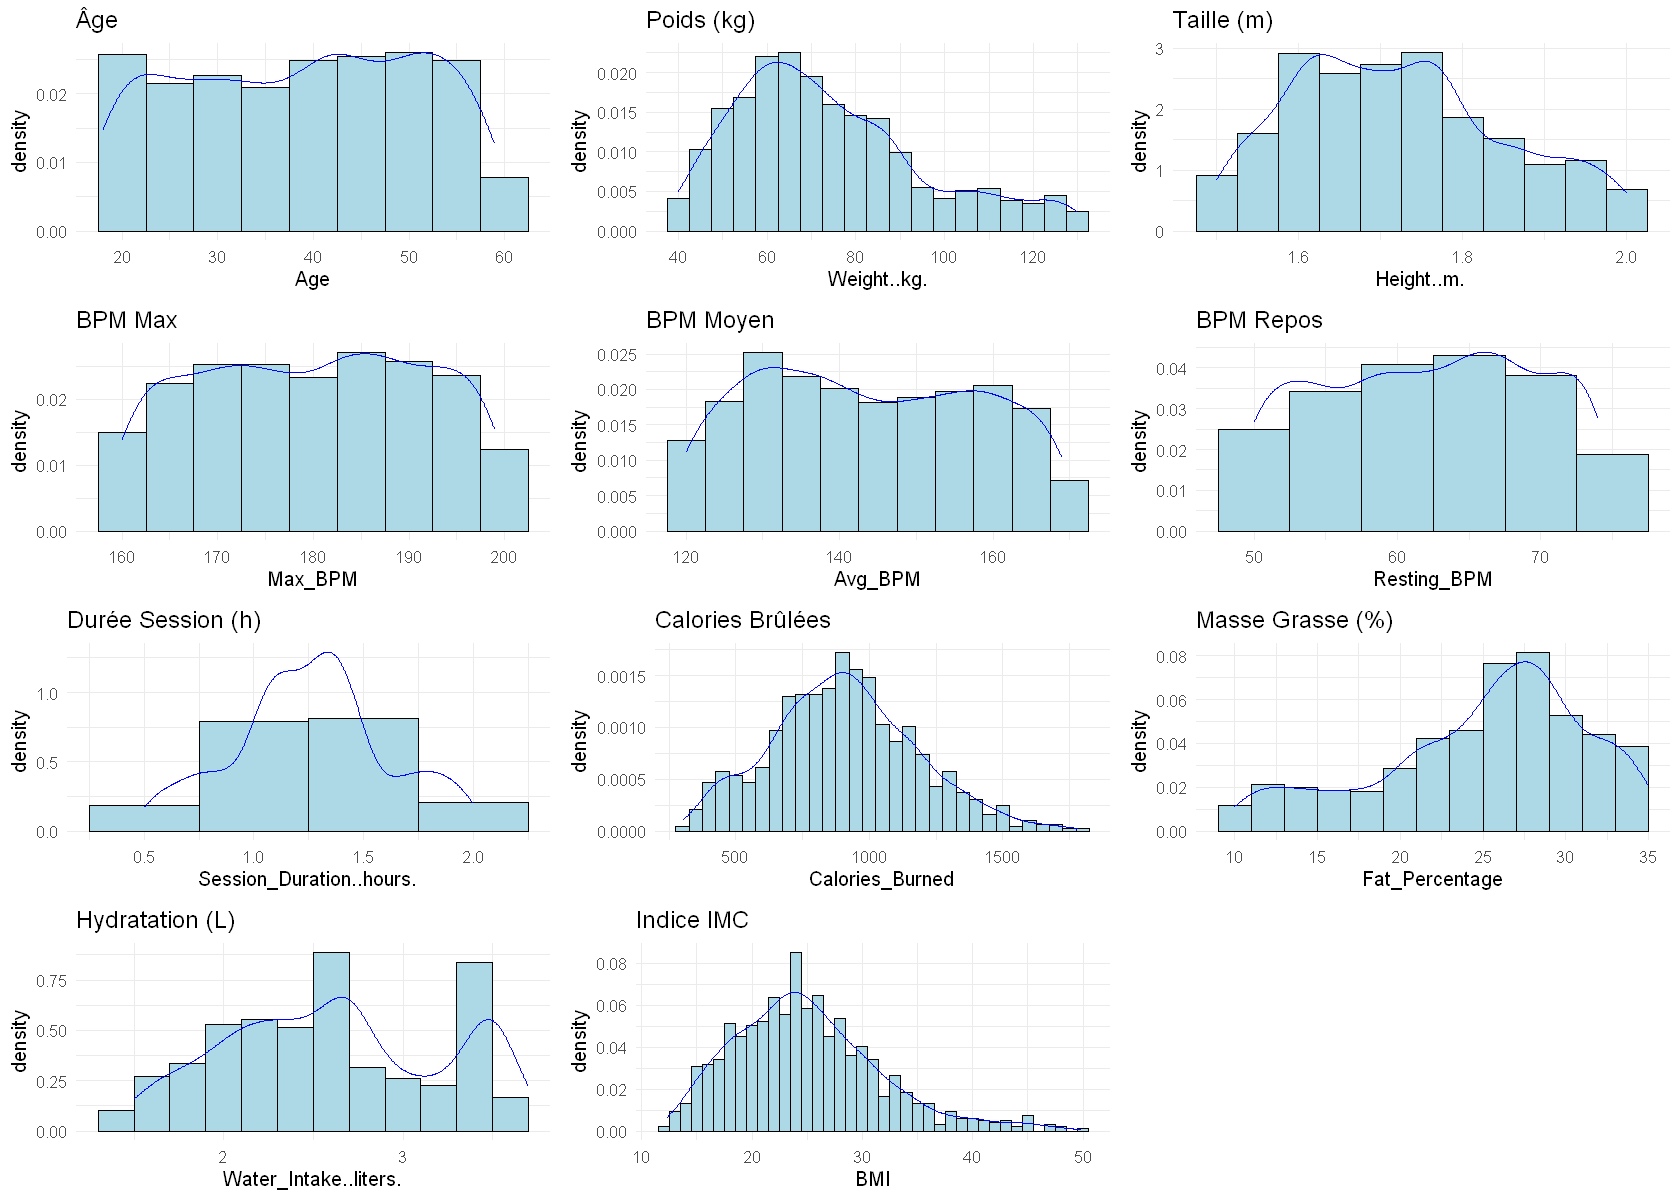

In [18]:
options(repr.plot.width = 14, repr.plot.height = 10)
grid.arrange(g1, g3, g4, g5, g6, g7, g8, g9, g11, g12, g15, ncol = 3)


In [19]:
# Création d'un dataset avec les données normalisées

data_norm <- data
data_norm[, "sBMI"] <- sqrt(data_norm[, "BMI"])
data_norm[, "sWeight..kg."] <- sqrt(data_norm[, "Weight..kg."])
data_norm[, "sCalories_Burned"] <- sqrt(data_norm[, "Calories_Burned"])
lambda = 2
data_norm[, "BCFat_Percentage"] <- (data_norm[, "Fat_Percentage"]**lambda)/lambda

Warning message:
"The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead."
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


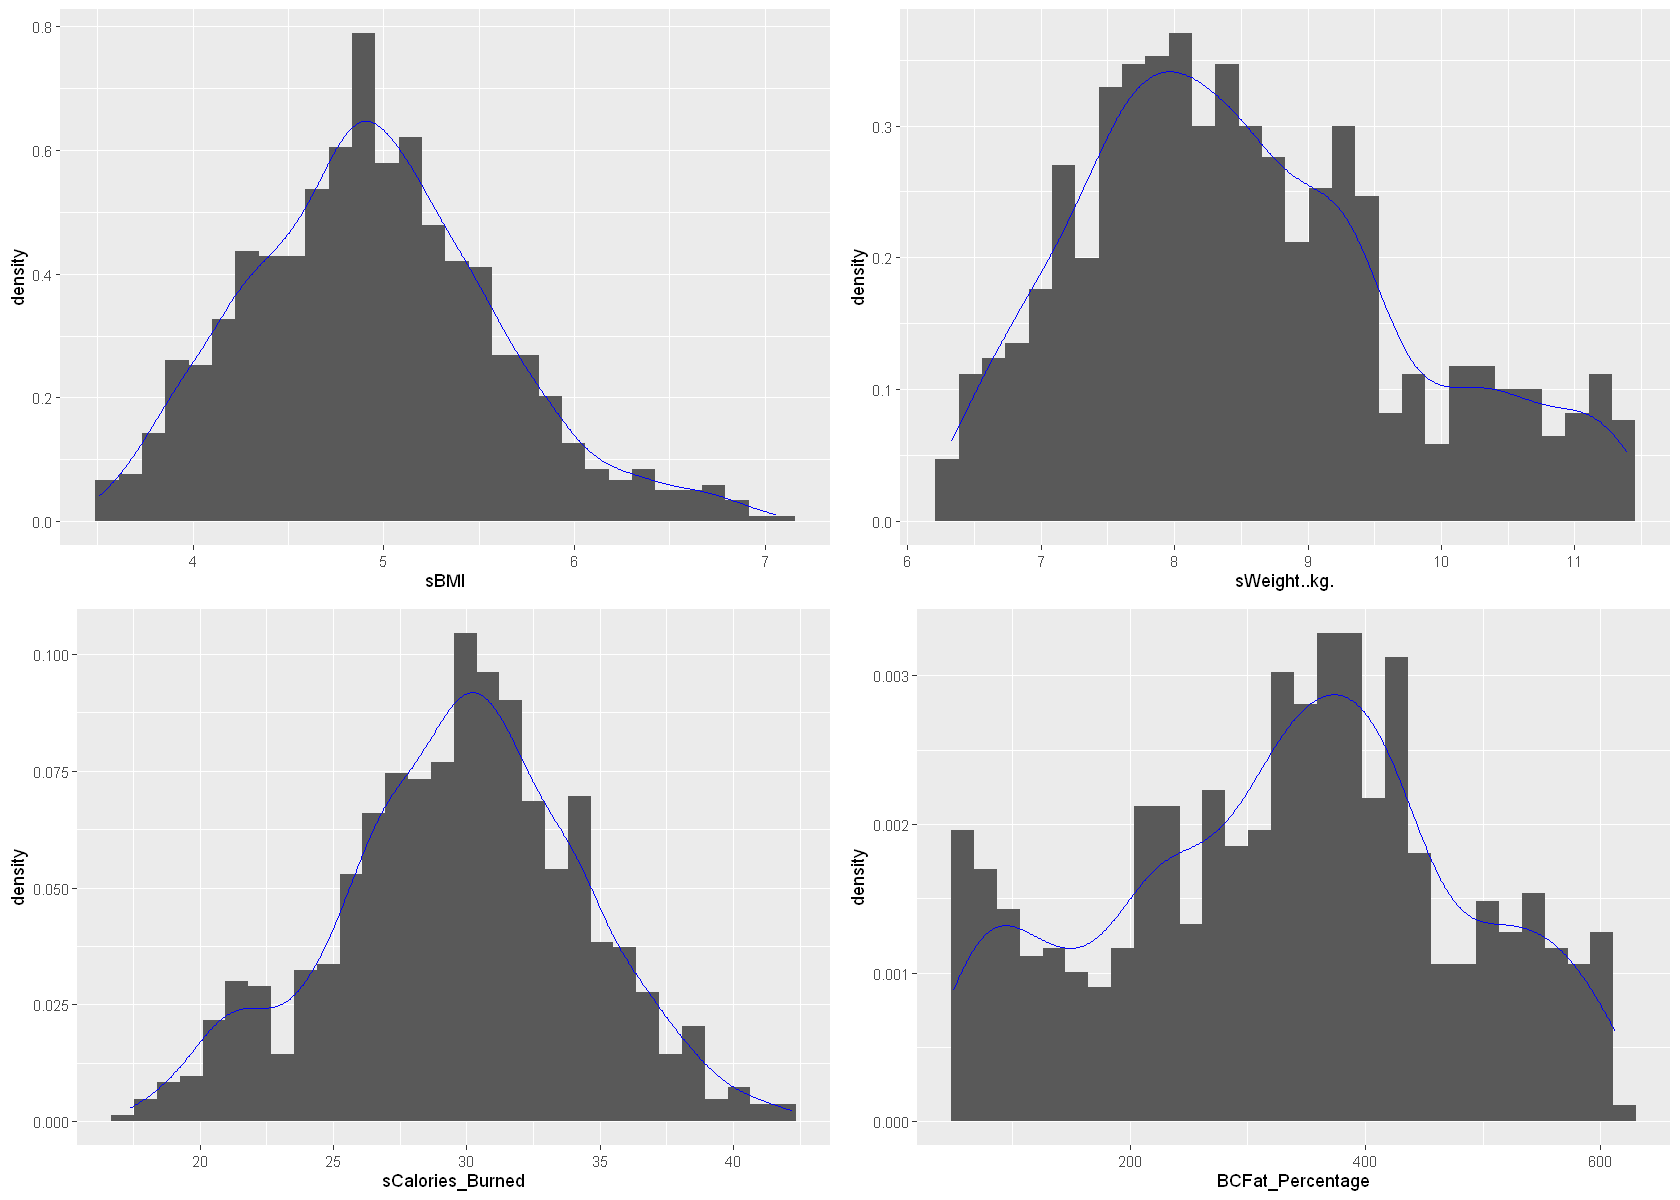

In [20]:
g16<-ggplot(data_norm,aes(x=sBMI))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g17<-ggplot(data_norm,aes(x=sWeight..kg.))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue")
g18<-ggplot(data_norm,aes(x=sCalories_Burned))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g19<-ggplot(data_norm,aes(x=BCFat_Percentage))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue")
#g20<-ggplot(data,aes(x=sHeight..m.))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 

options(repr.plot.width = 14, repr.plot.height = 10)
grid.arrange(g16, g17, g18, g19, ncol = 2)


In [21]:
# On réorganise data_norm pour pouvoir l'utiliser comme data

data_norm <- data_norm[, !names(data_norm) %in% c("BMI", "Weight..kg.", "Calories_Burned", "Fat_Percentage")]

cols <- c("Age", "Gender", "sWeight..kg.", "Height..m.", "Max_BPM", "Avg_BPM",
          "Resting_BPM", "Session_Duration..hours.", "sCalories_Burned", "Workout_Type",
          "BCFat_Percentage", "Water_Intake..liters.", "Workout_Frequency..days.week.", "Experience_Level", "sBMI")

data_norm <- data_norm[ , cols]

# Vérification
head(data_norm)

,Age,Gender,sWeight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,sCalories_Burned,Workout_Type,BCFat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level,sBMI
,<int>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
1,56,Male,9.396808,1.71,180,157,60,1.69,36.23534,Yoga,79.380,3.5,4,3,5.495453
2,46,Female,8.654479,1.53,179,151,66,1.30,29.71532,HIIT,574.605,2.1,4,2,5.656854
3,32,Female,8.252272,1.66,167,122,54,1.11,26.01922,Cardio,557.780,2.3,4,2,4.970915
4,25,Male,7.293833,1.70,190,164,56,0.59,23.06513,Strength,414.720,2.1,3,1,4.290688
5,38,Male,6.789698,1.79,188,158,68,0.64,23.57965,Strength,426.320,2.8,3,1,3.793415
6,56,Female,7.615773,1.68,168,156,74,1.59,33.40659,HIIT,120.125,2.7,5,3,4.533211


In [22]:
quanti_columns <- c(1,3:9,11,12,15)
quali_columns <- c(2,10,13,14)

In [23]:
my_hist <- function(data, mapping, ...) {
  ggplot(data = data, mapping = mapping) +
    geom_histogram(aes(y = after_stat(density)),
                   fill = "lightblue",
                   color = "black",
                   binwidth = 5) +
    geom_density(color = "blue", alpha = 0.4) +
    theme_minimal()
}

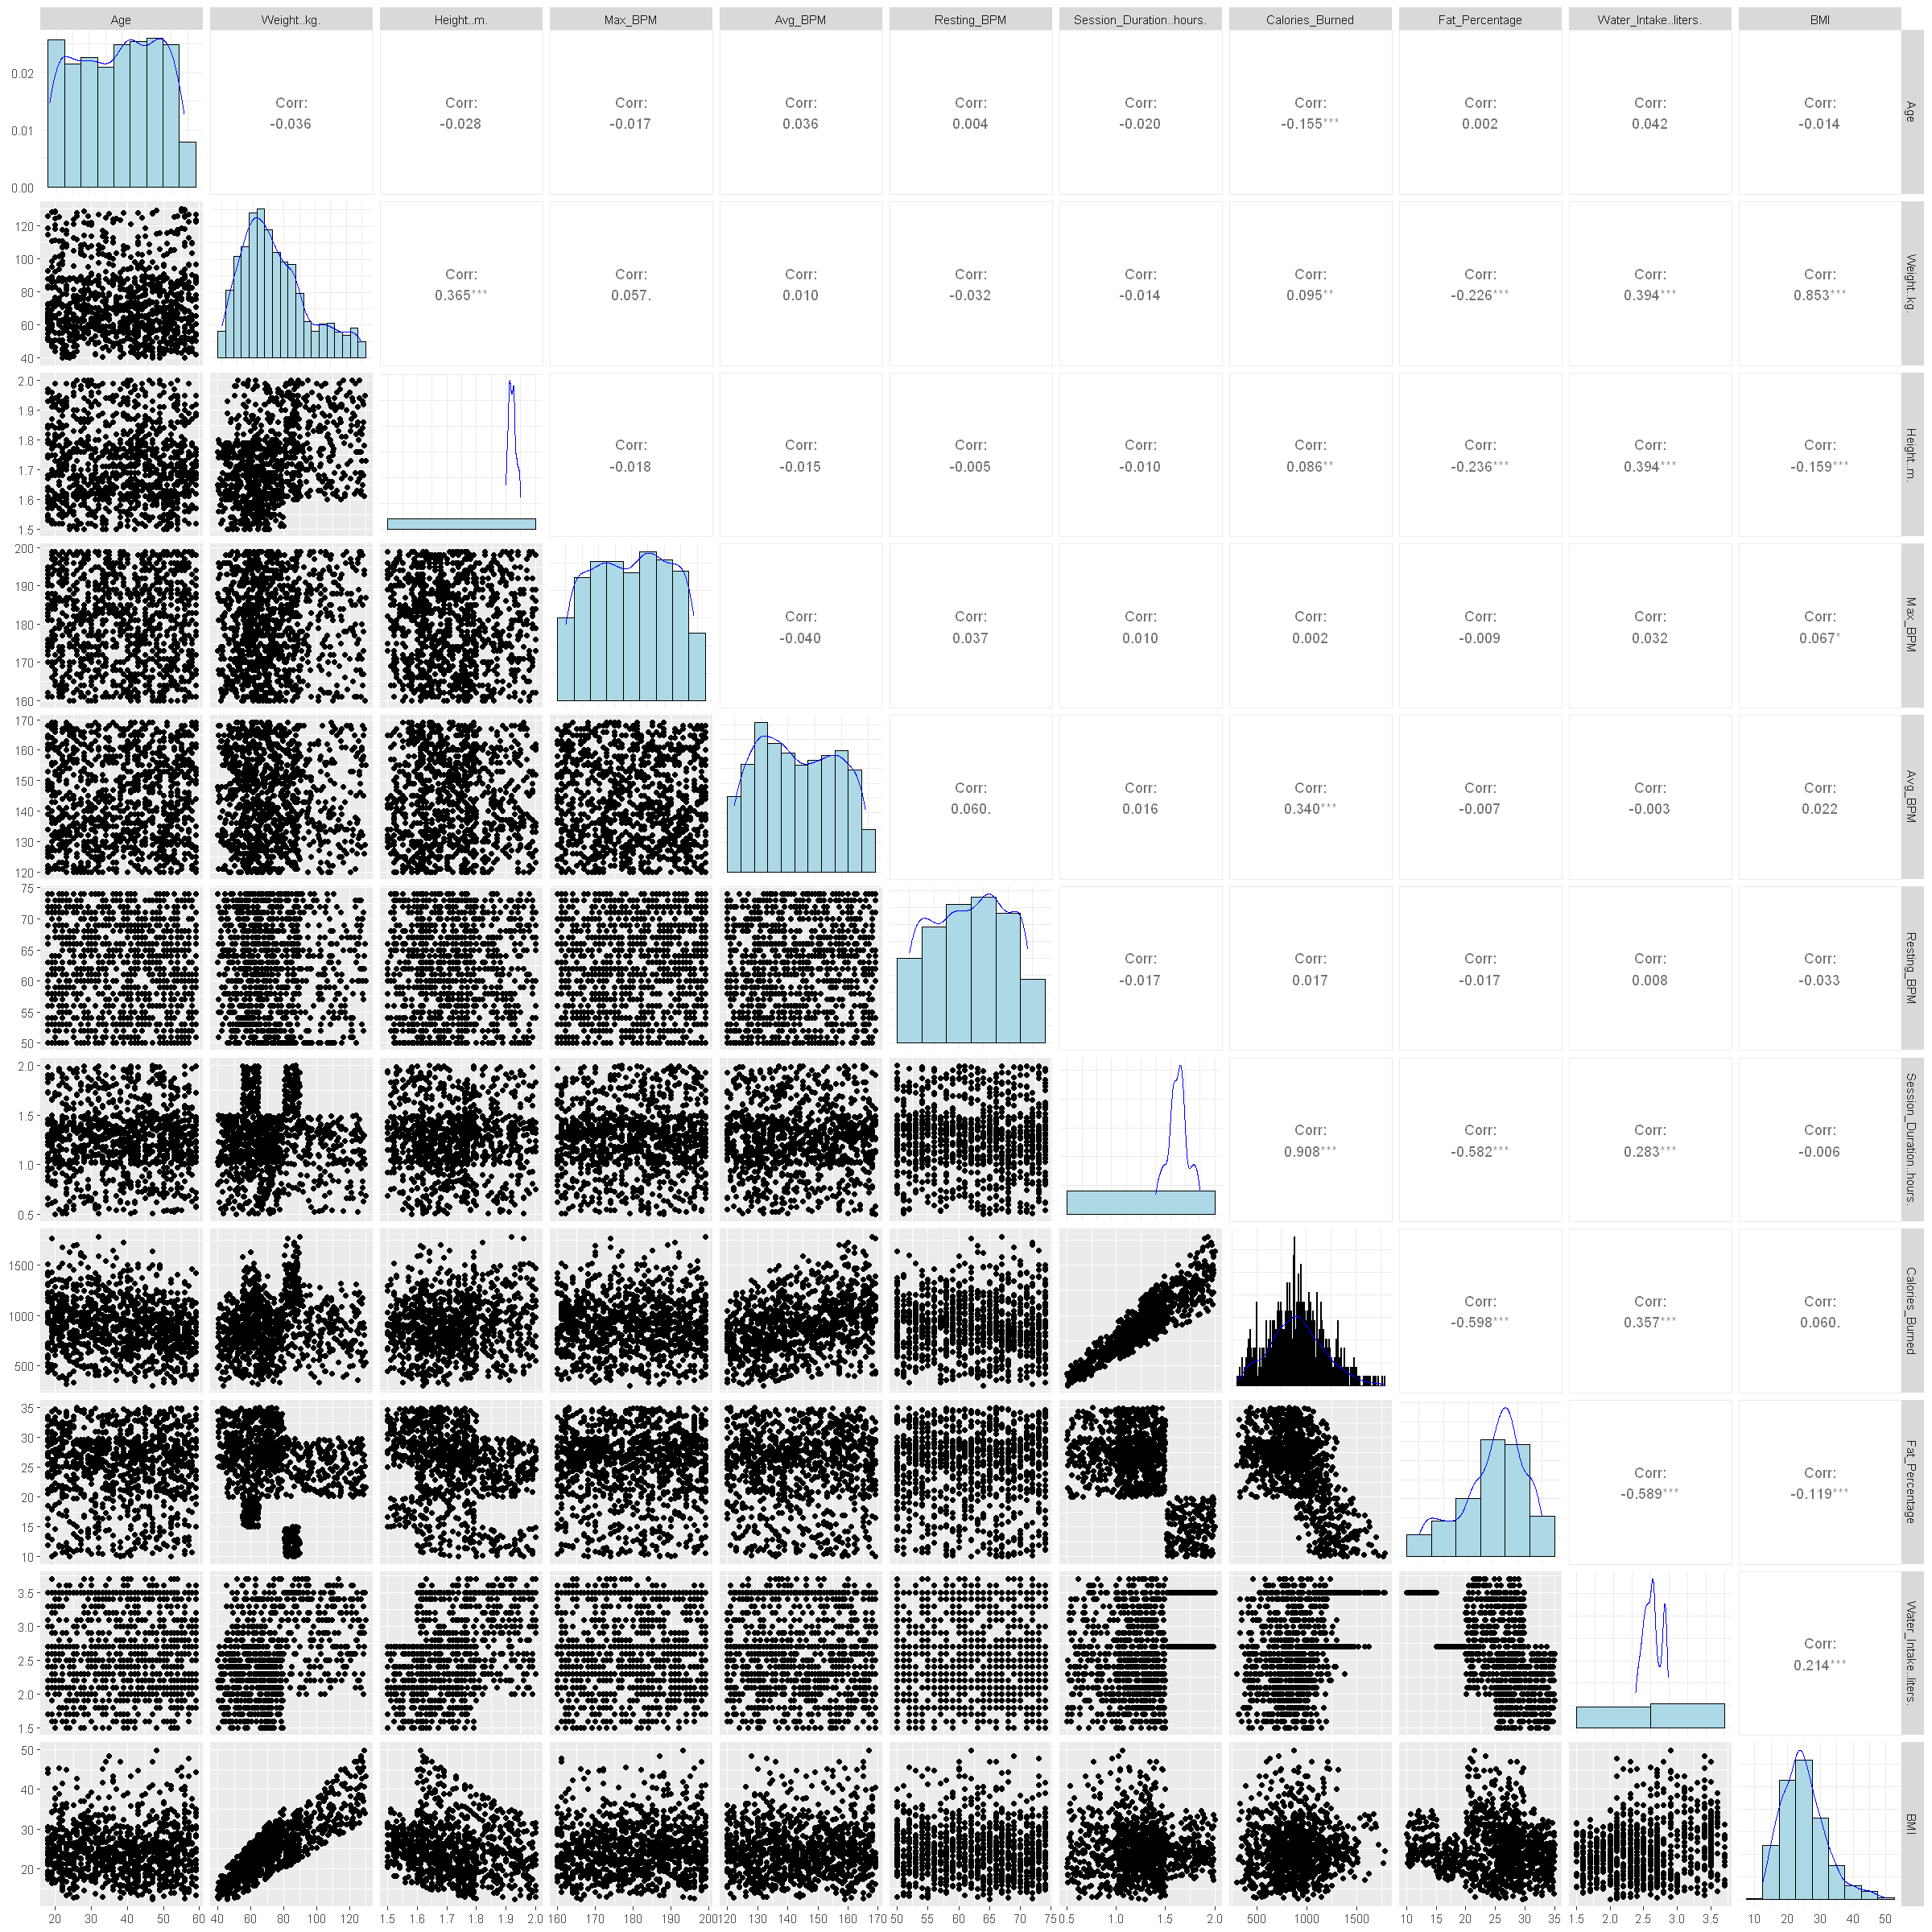

In [24]:
p <- ggpairs(
  data[, quanti_columns],
  diag = list(continuous = my_hist)
)

options(repr.plot.width = 20, repr.plot.height = 20)
print(p)

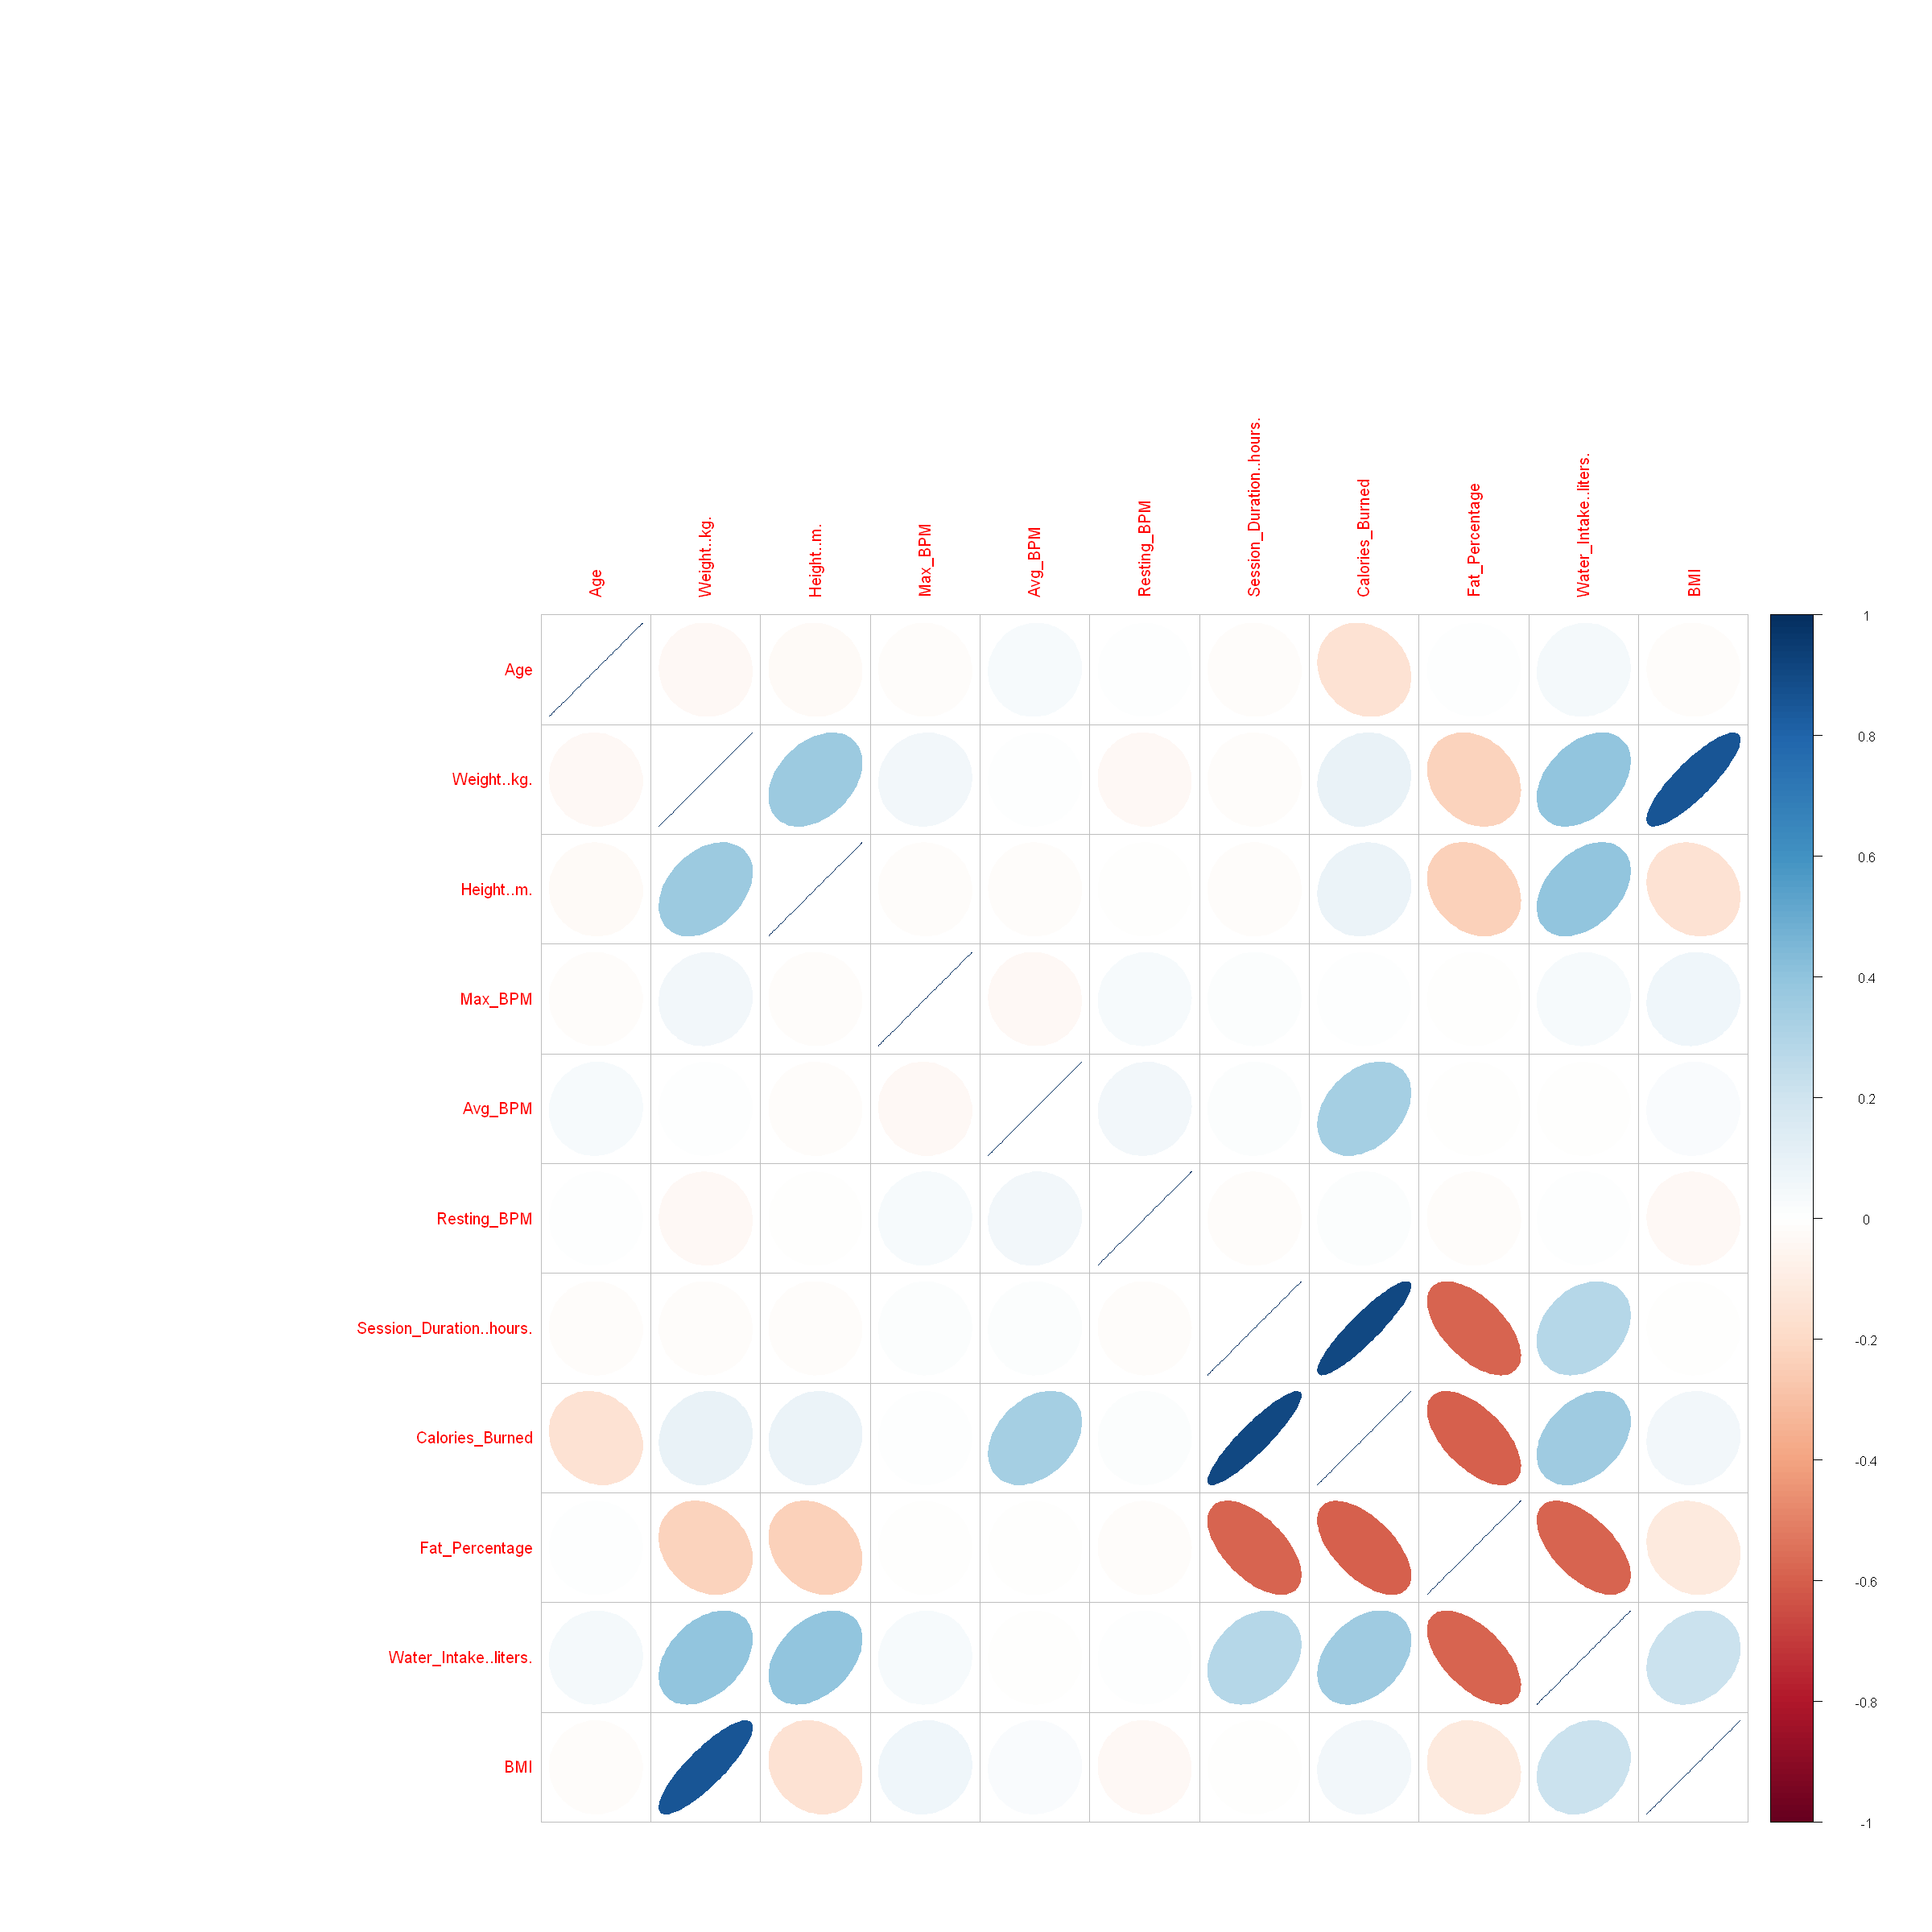

In [25]:
data_acp <- data[,quanti_columns]
corrplot(cor(data_acp),method="ellipse")

# *Observations:*
Les variables `sCalories_Burned` et `Session_Duration..hours.` sont très corrélées, de même, `sWeight..kg.` et `sBMI` sont très corrélées. 
Au contraire, `BCFat_Percentage` et  `Session_Duration..hours.` sont négativement corrélées significativement, même constat pour `BCFat_Percentage` et `Water_Intake..liters.`

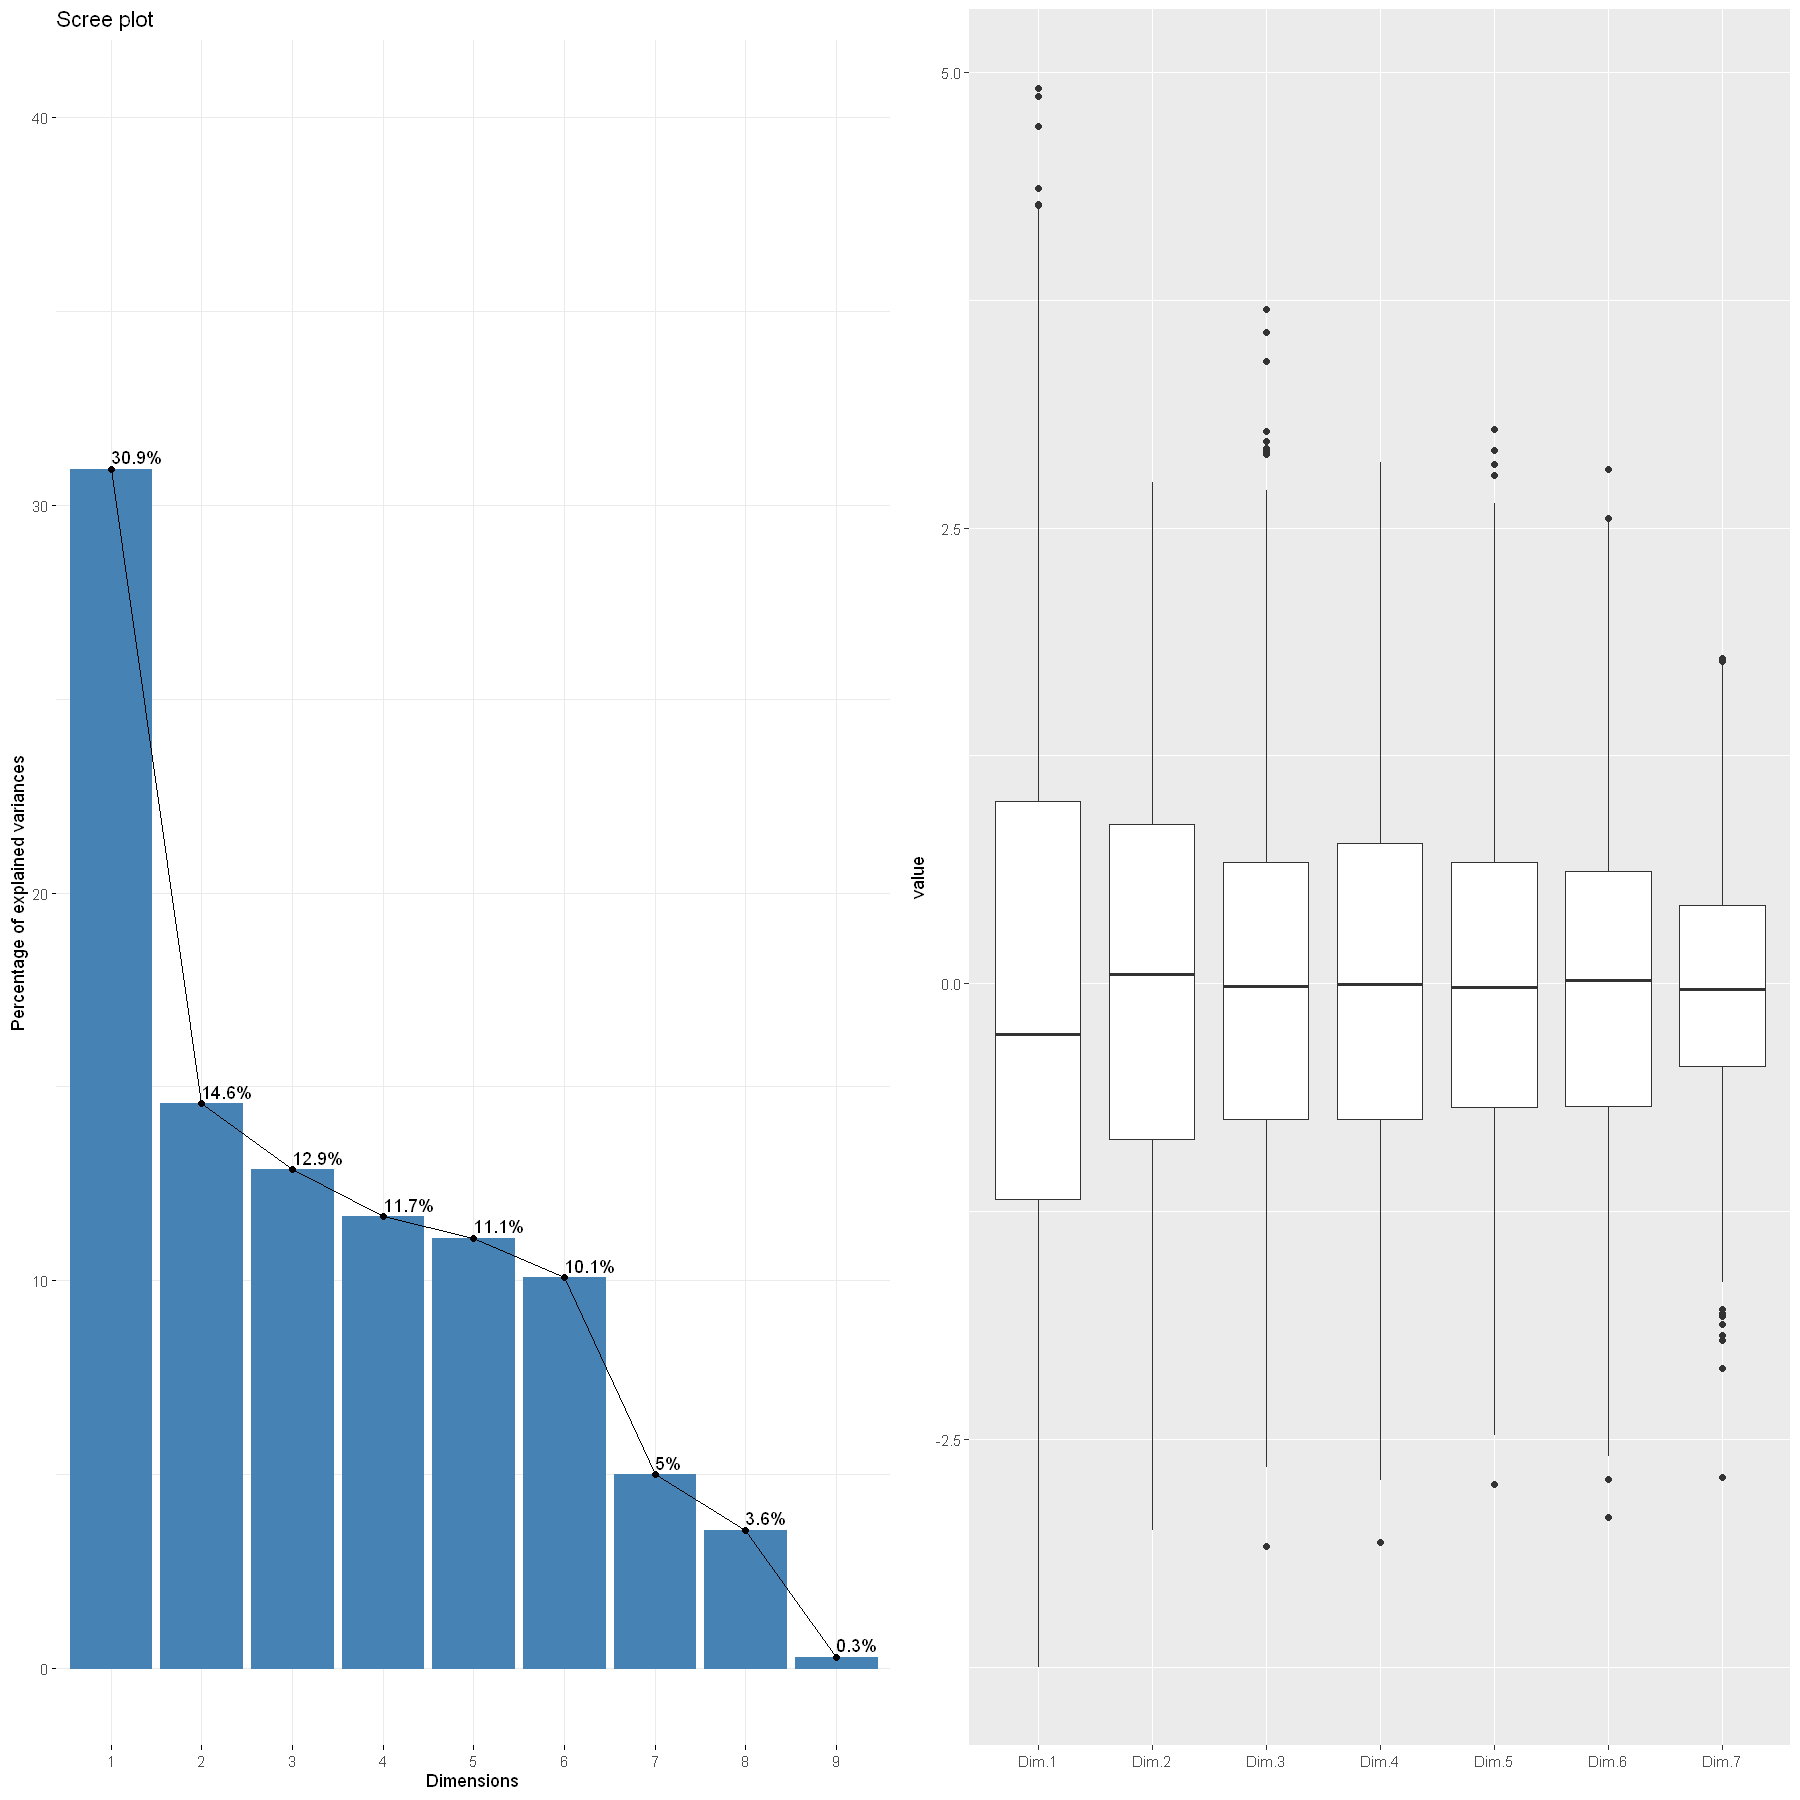

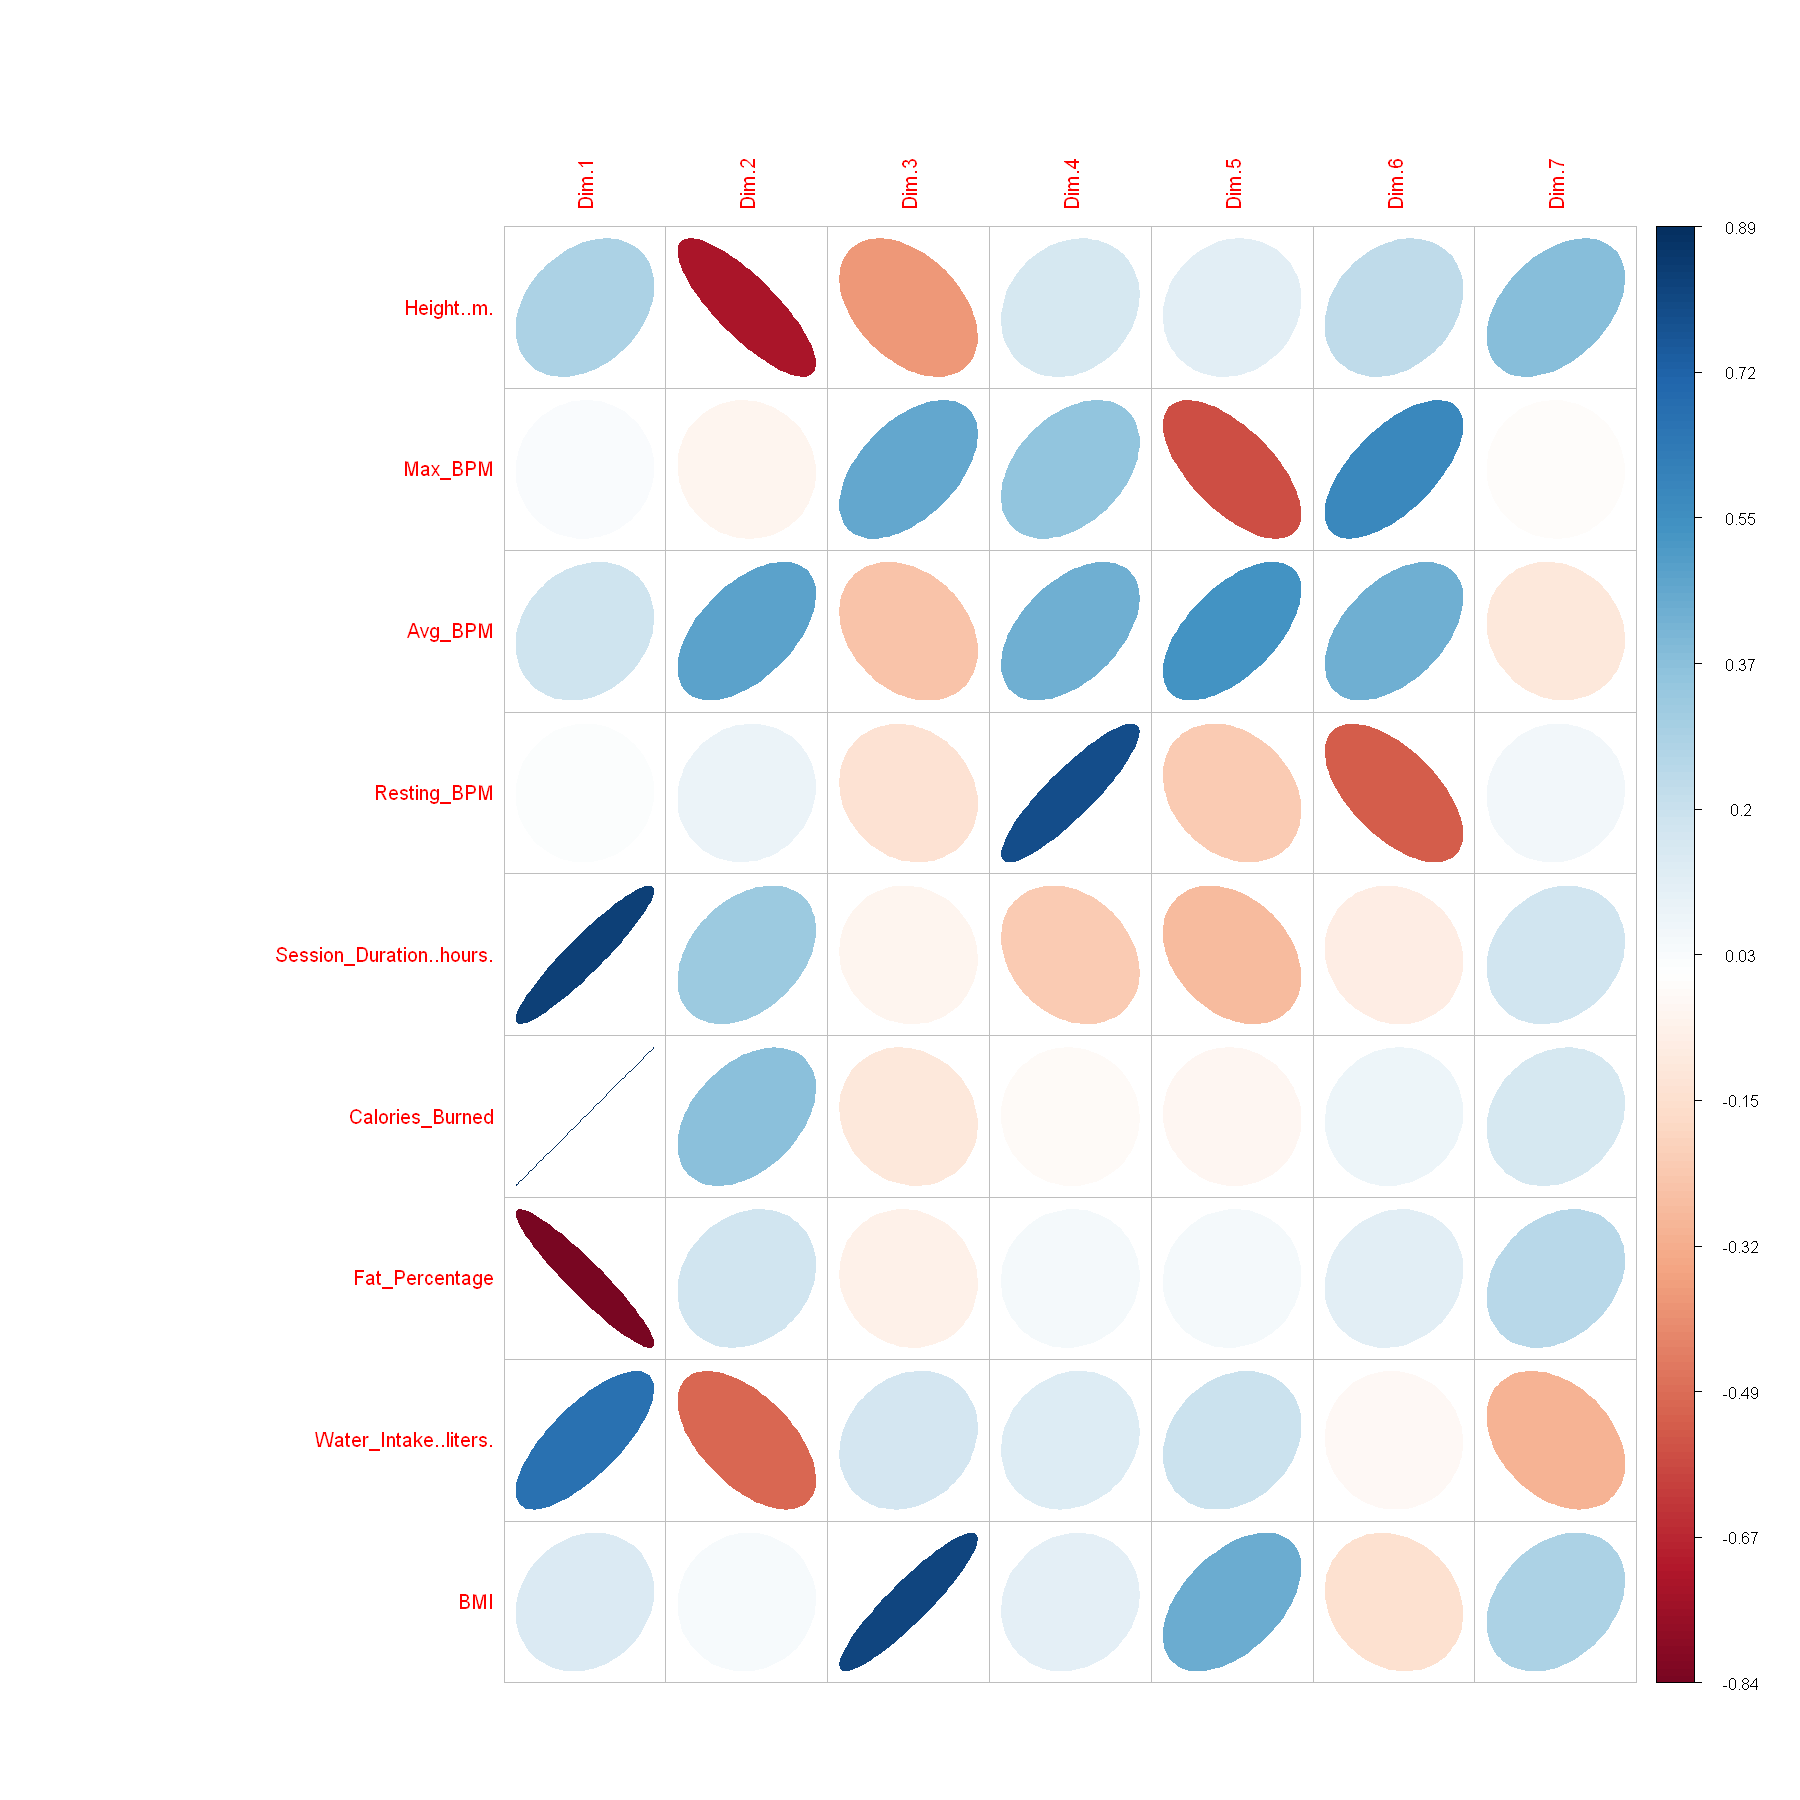

In [26]:
# ACP réduite
acp <- PCA(data_acp, scale.unit = TRUE,
           graph = FALSE, quali.sup = 1, quanti.sup = 2, ncp = 7)

options(repr.plot.width = 15, repr.plot.height = 15)

g1<-fviz_eig(acp, addlabels = TRUE, ylim = c(0, 40))

g2<-ggplot(melt(acp$ind$coord),aes(x=Var2,y=value))+
  geom_boxplot()+
  xlab("")
grid.arrange(g1,g2,ncol=2)

library(corrplot)
corrplot(acp$var$cor, is.corr=FALSE,method="ellipse")

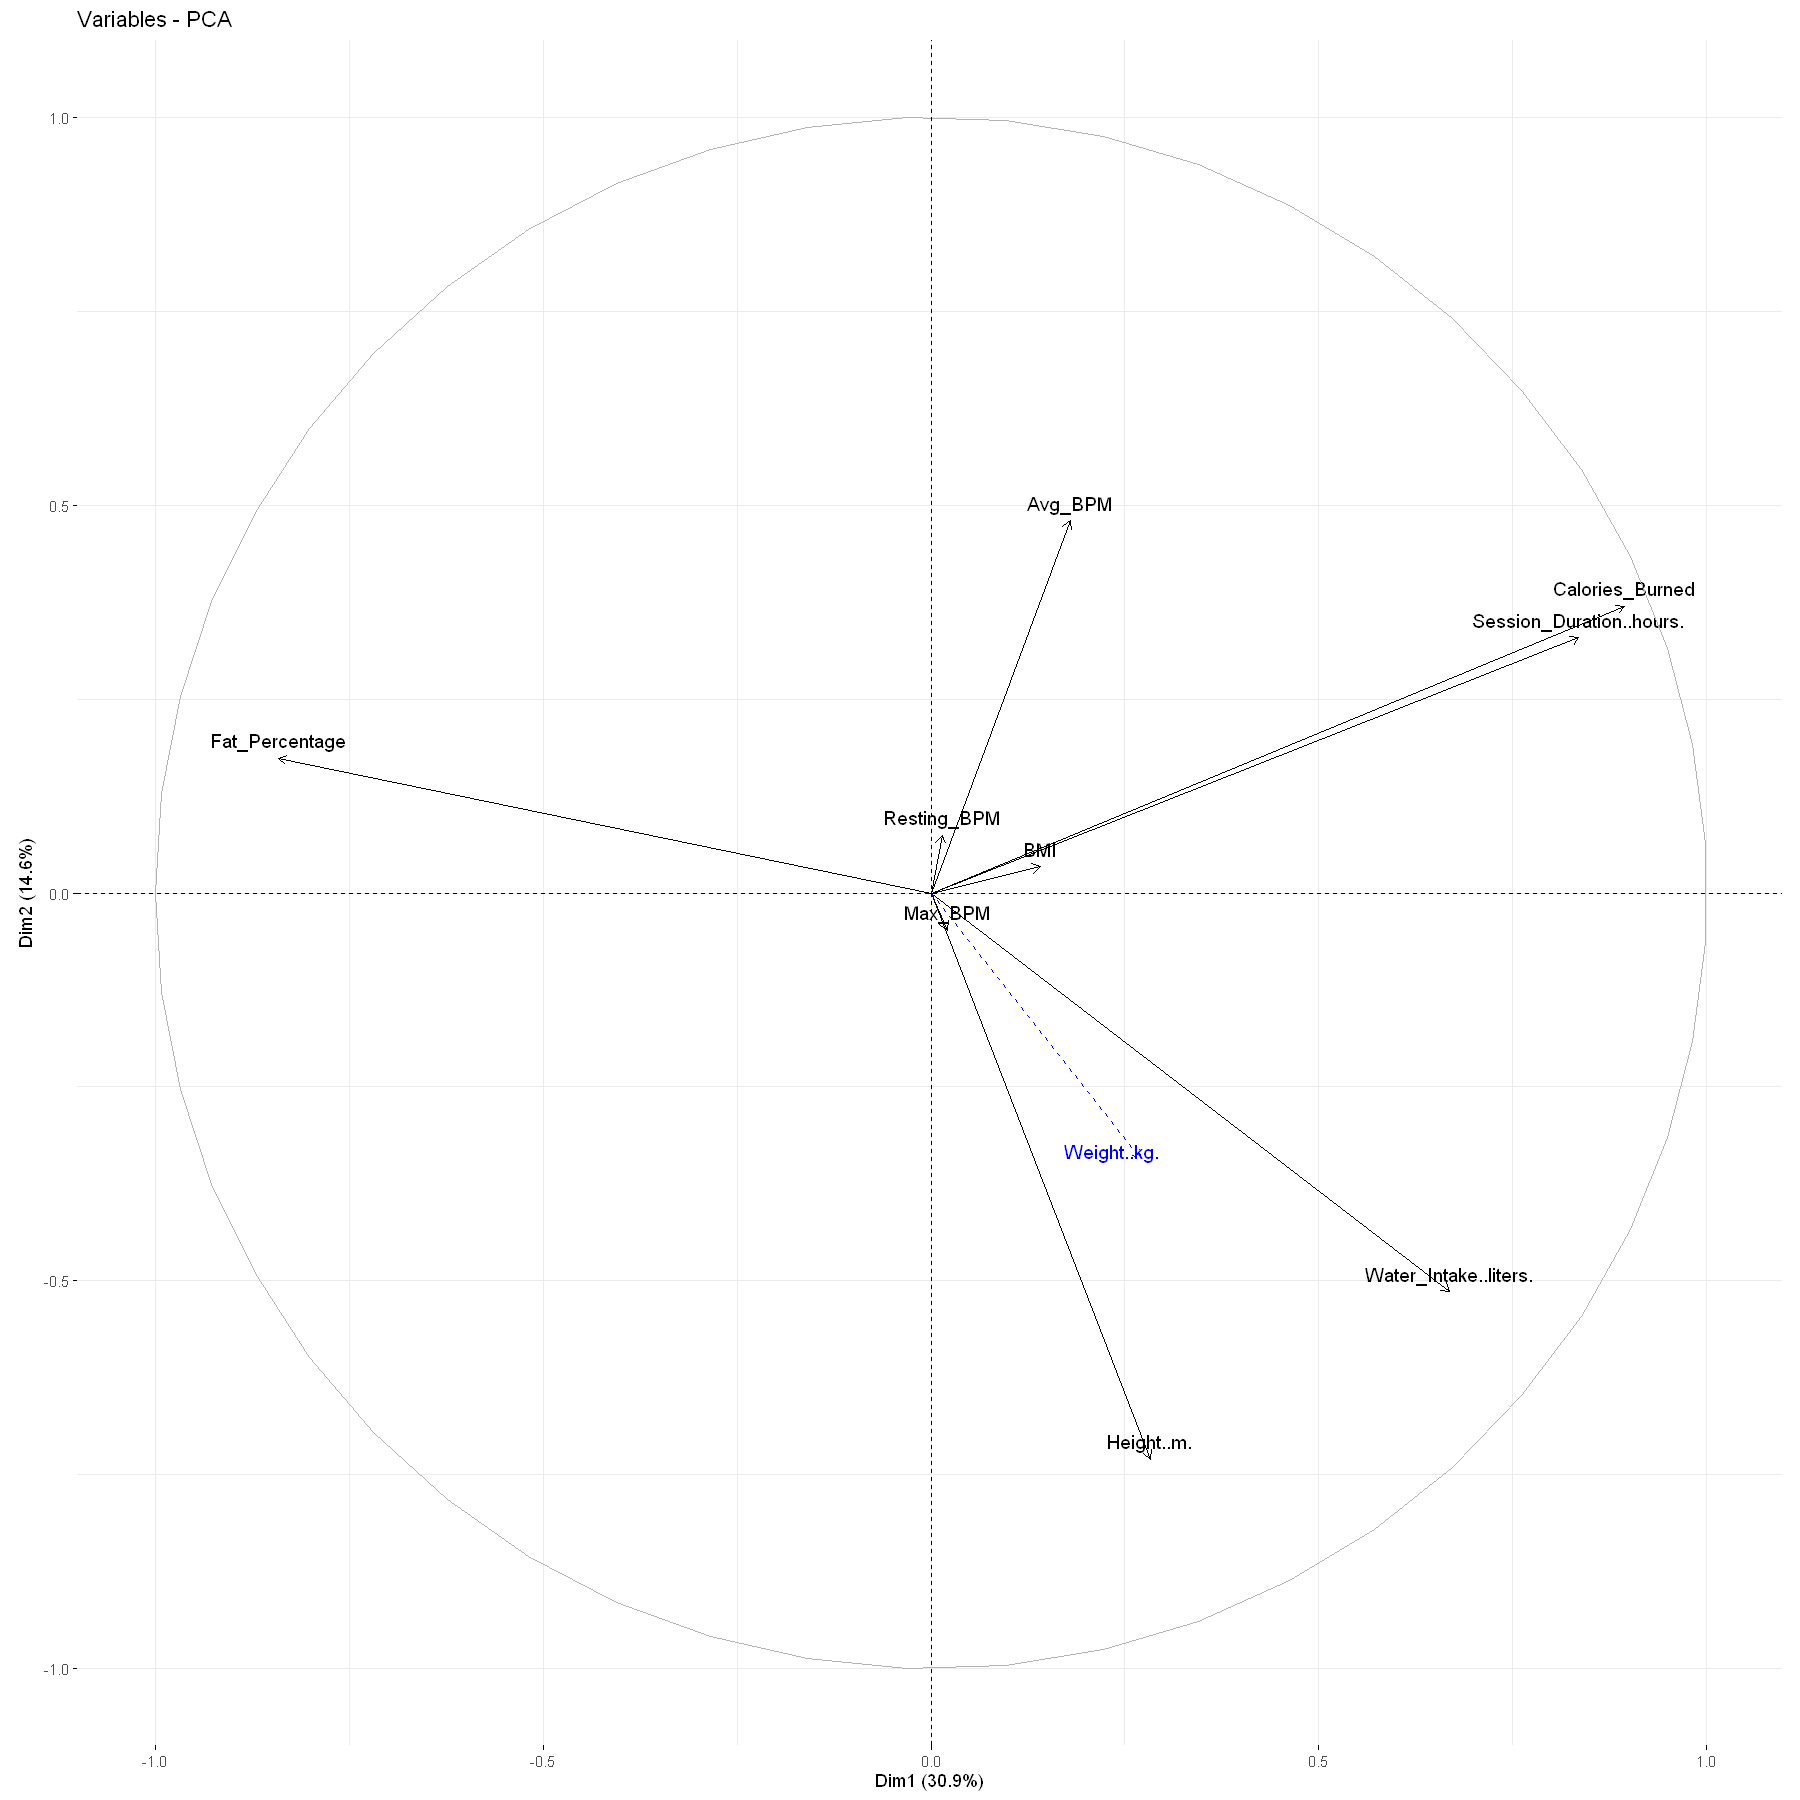

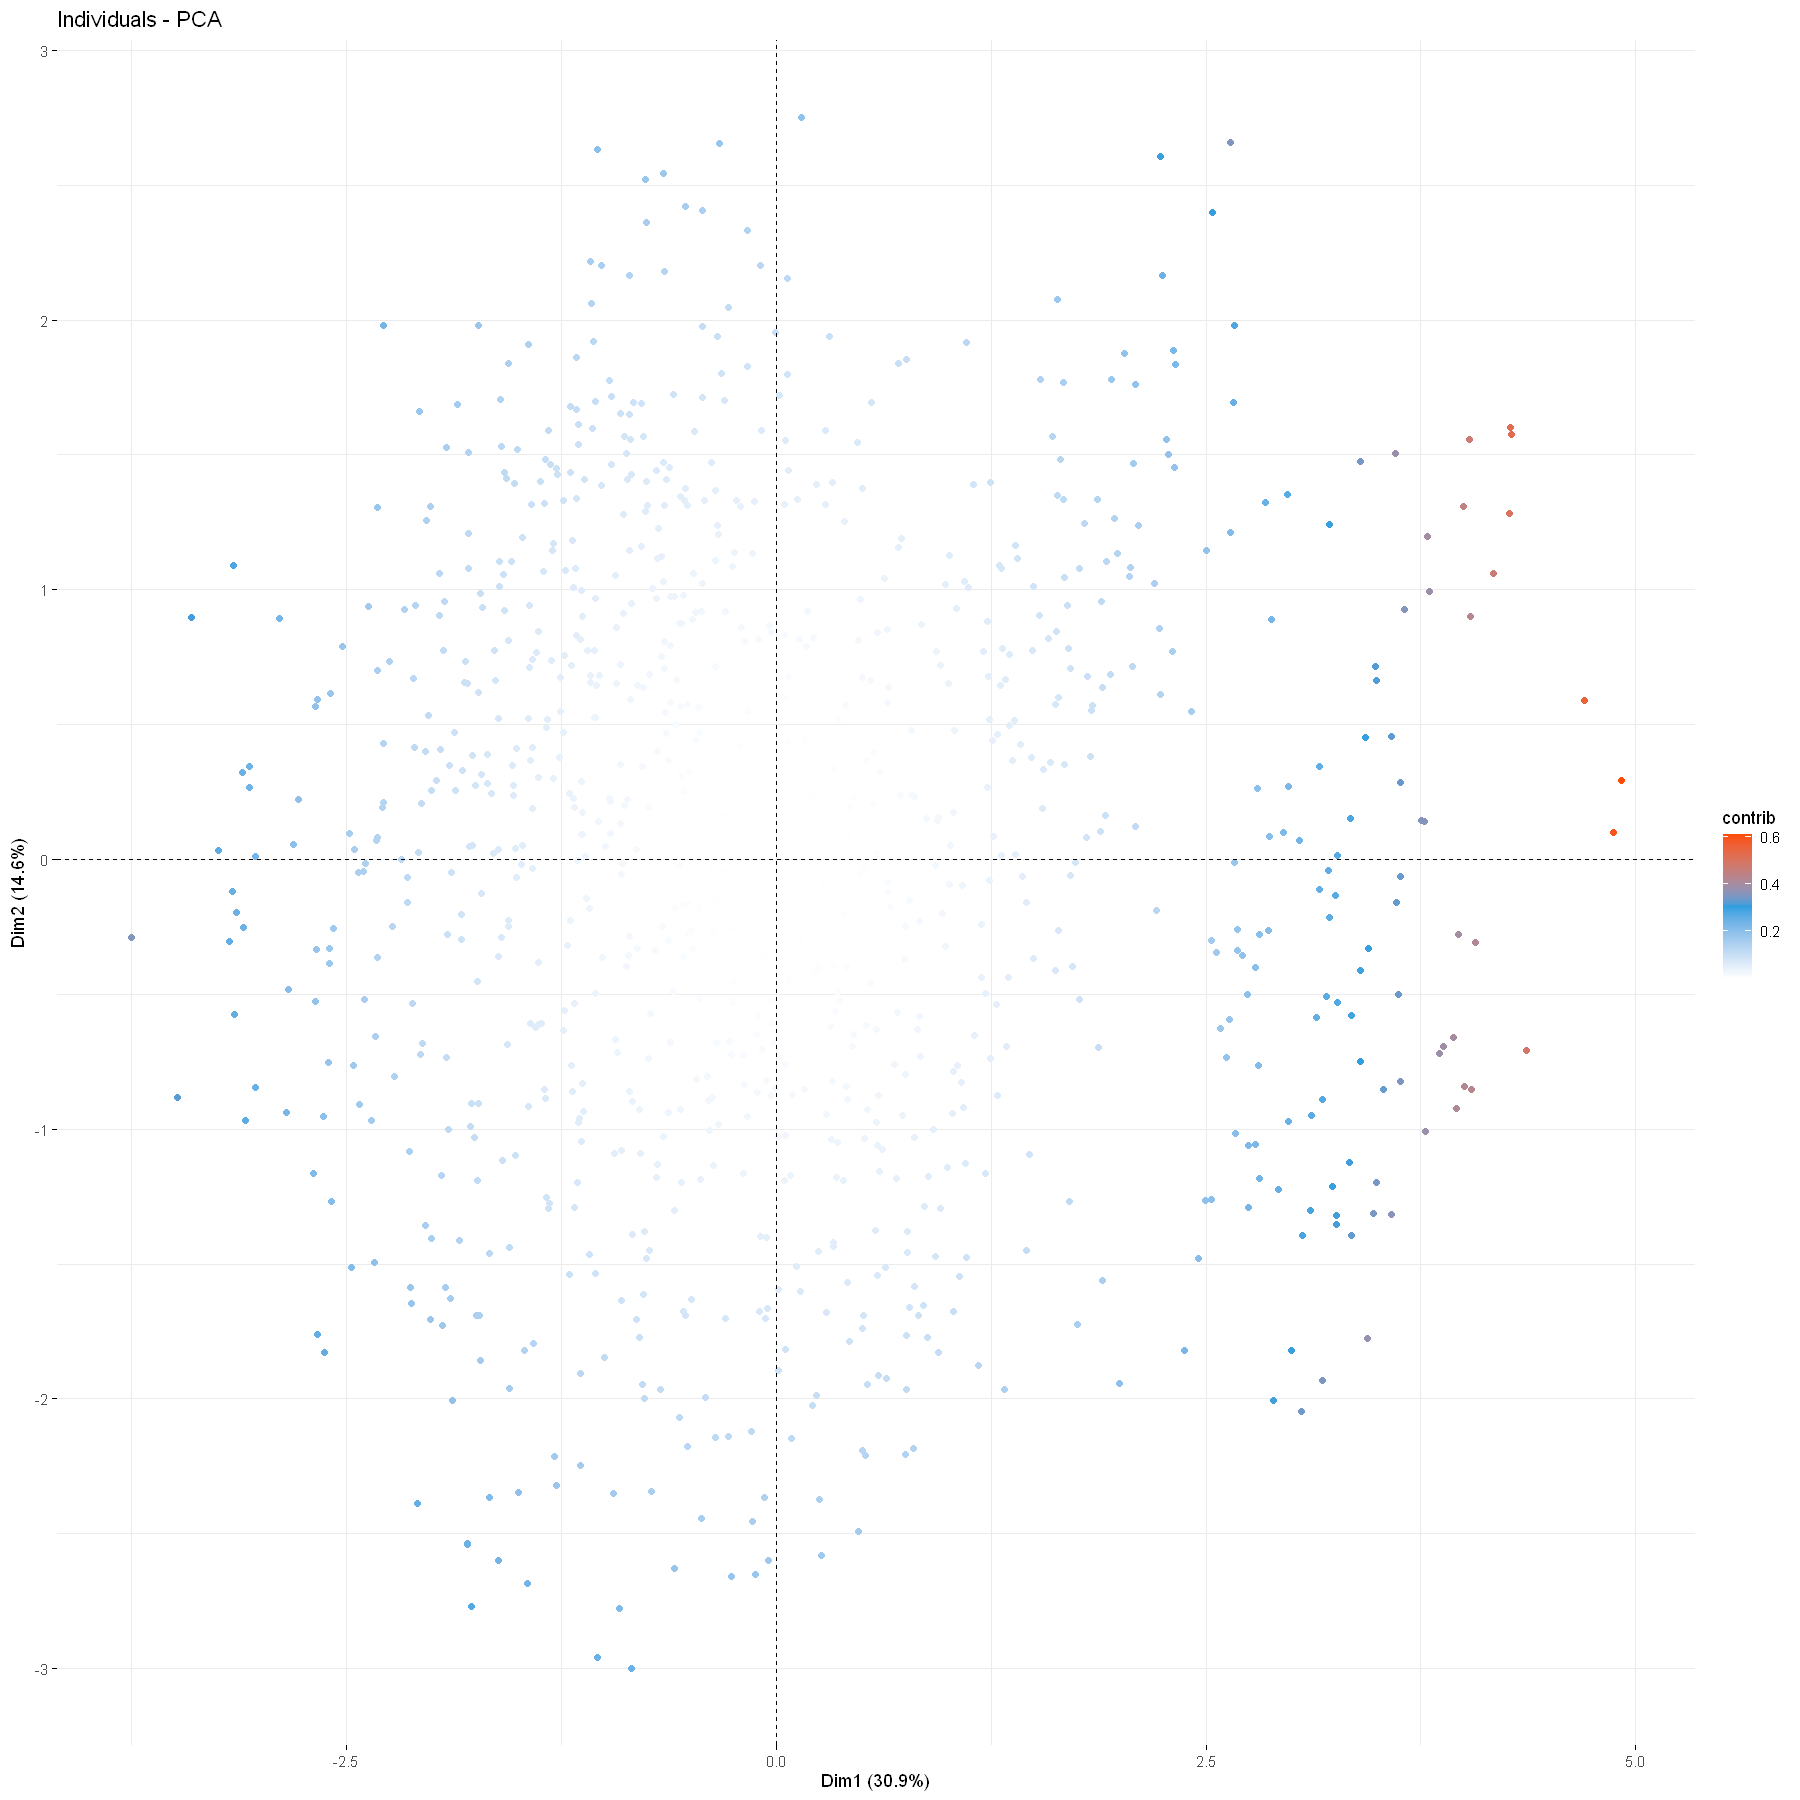

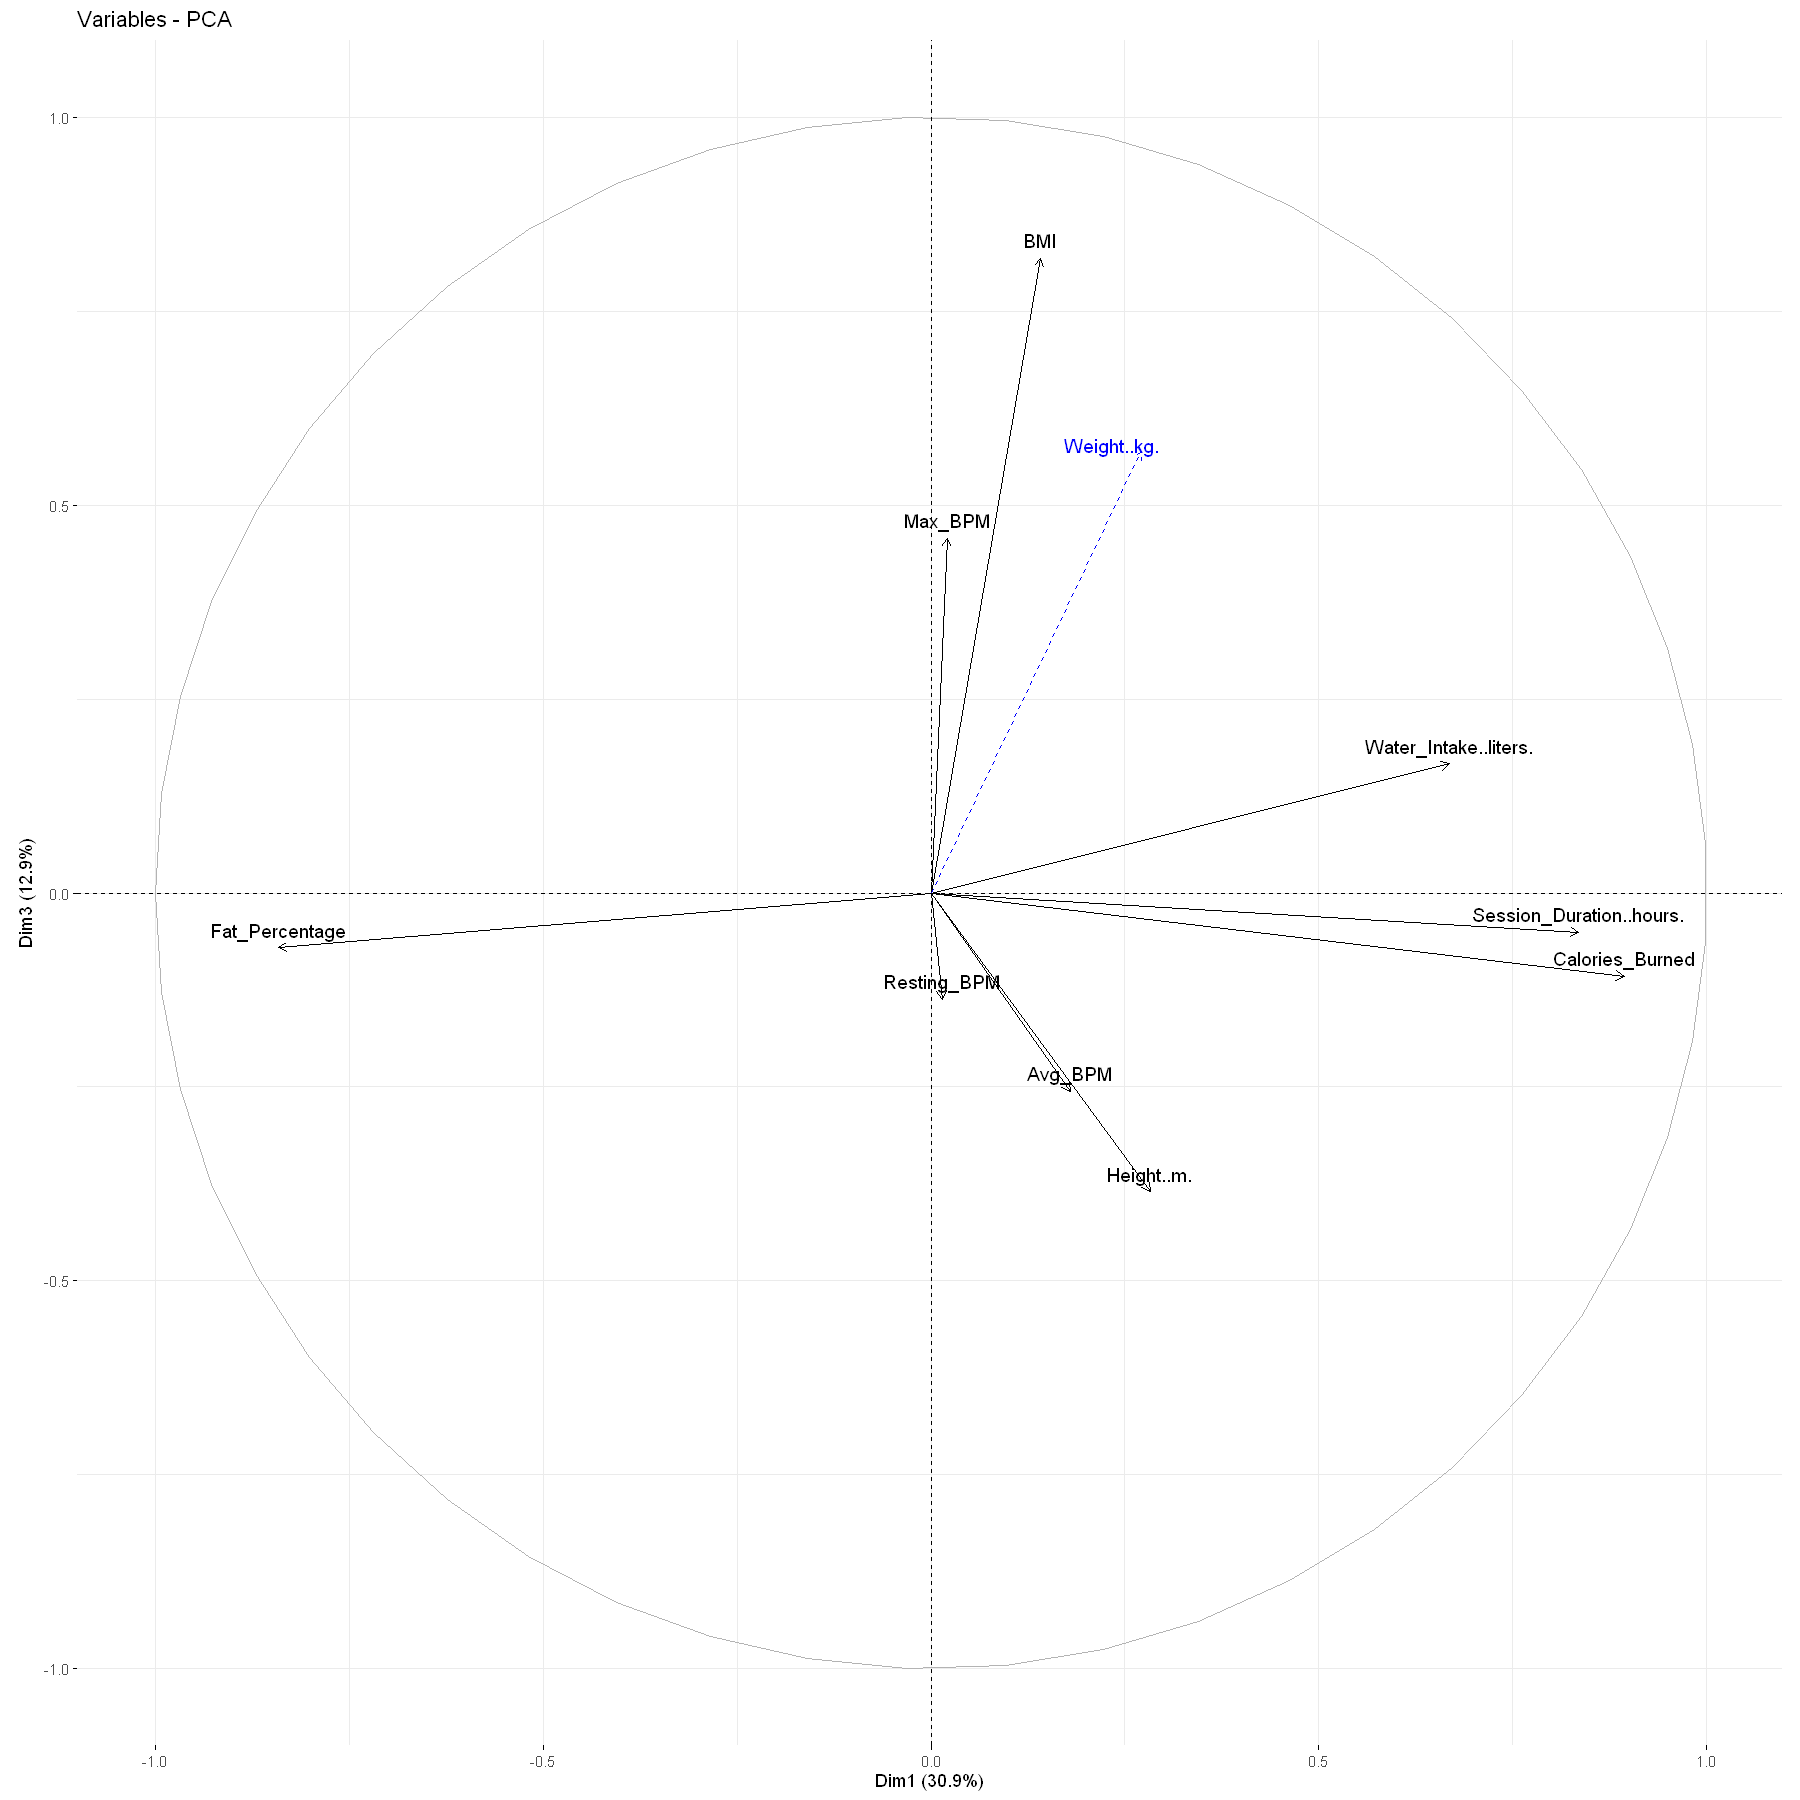

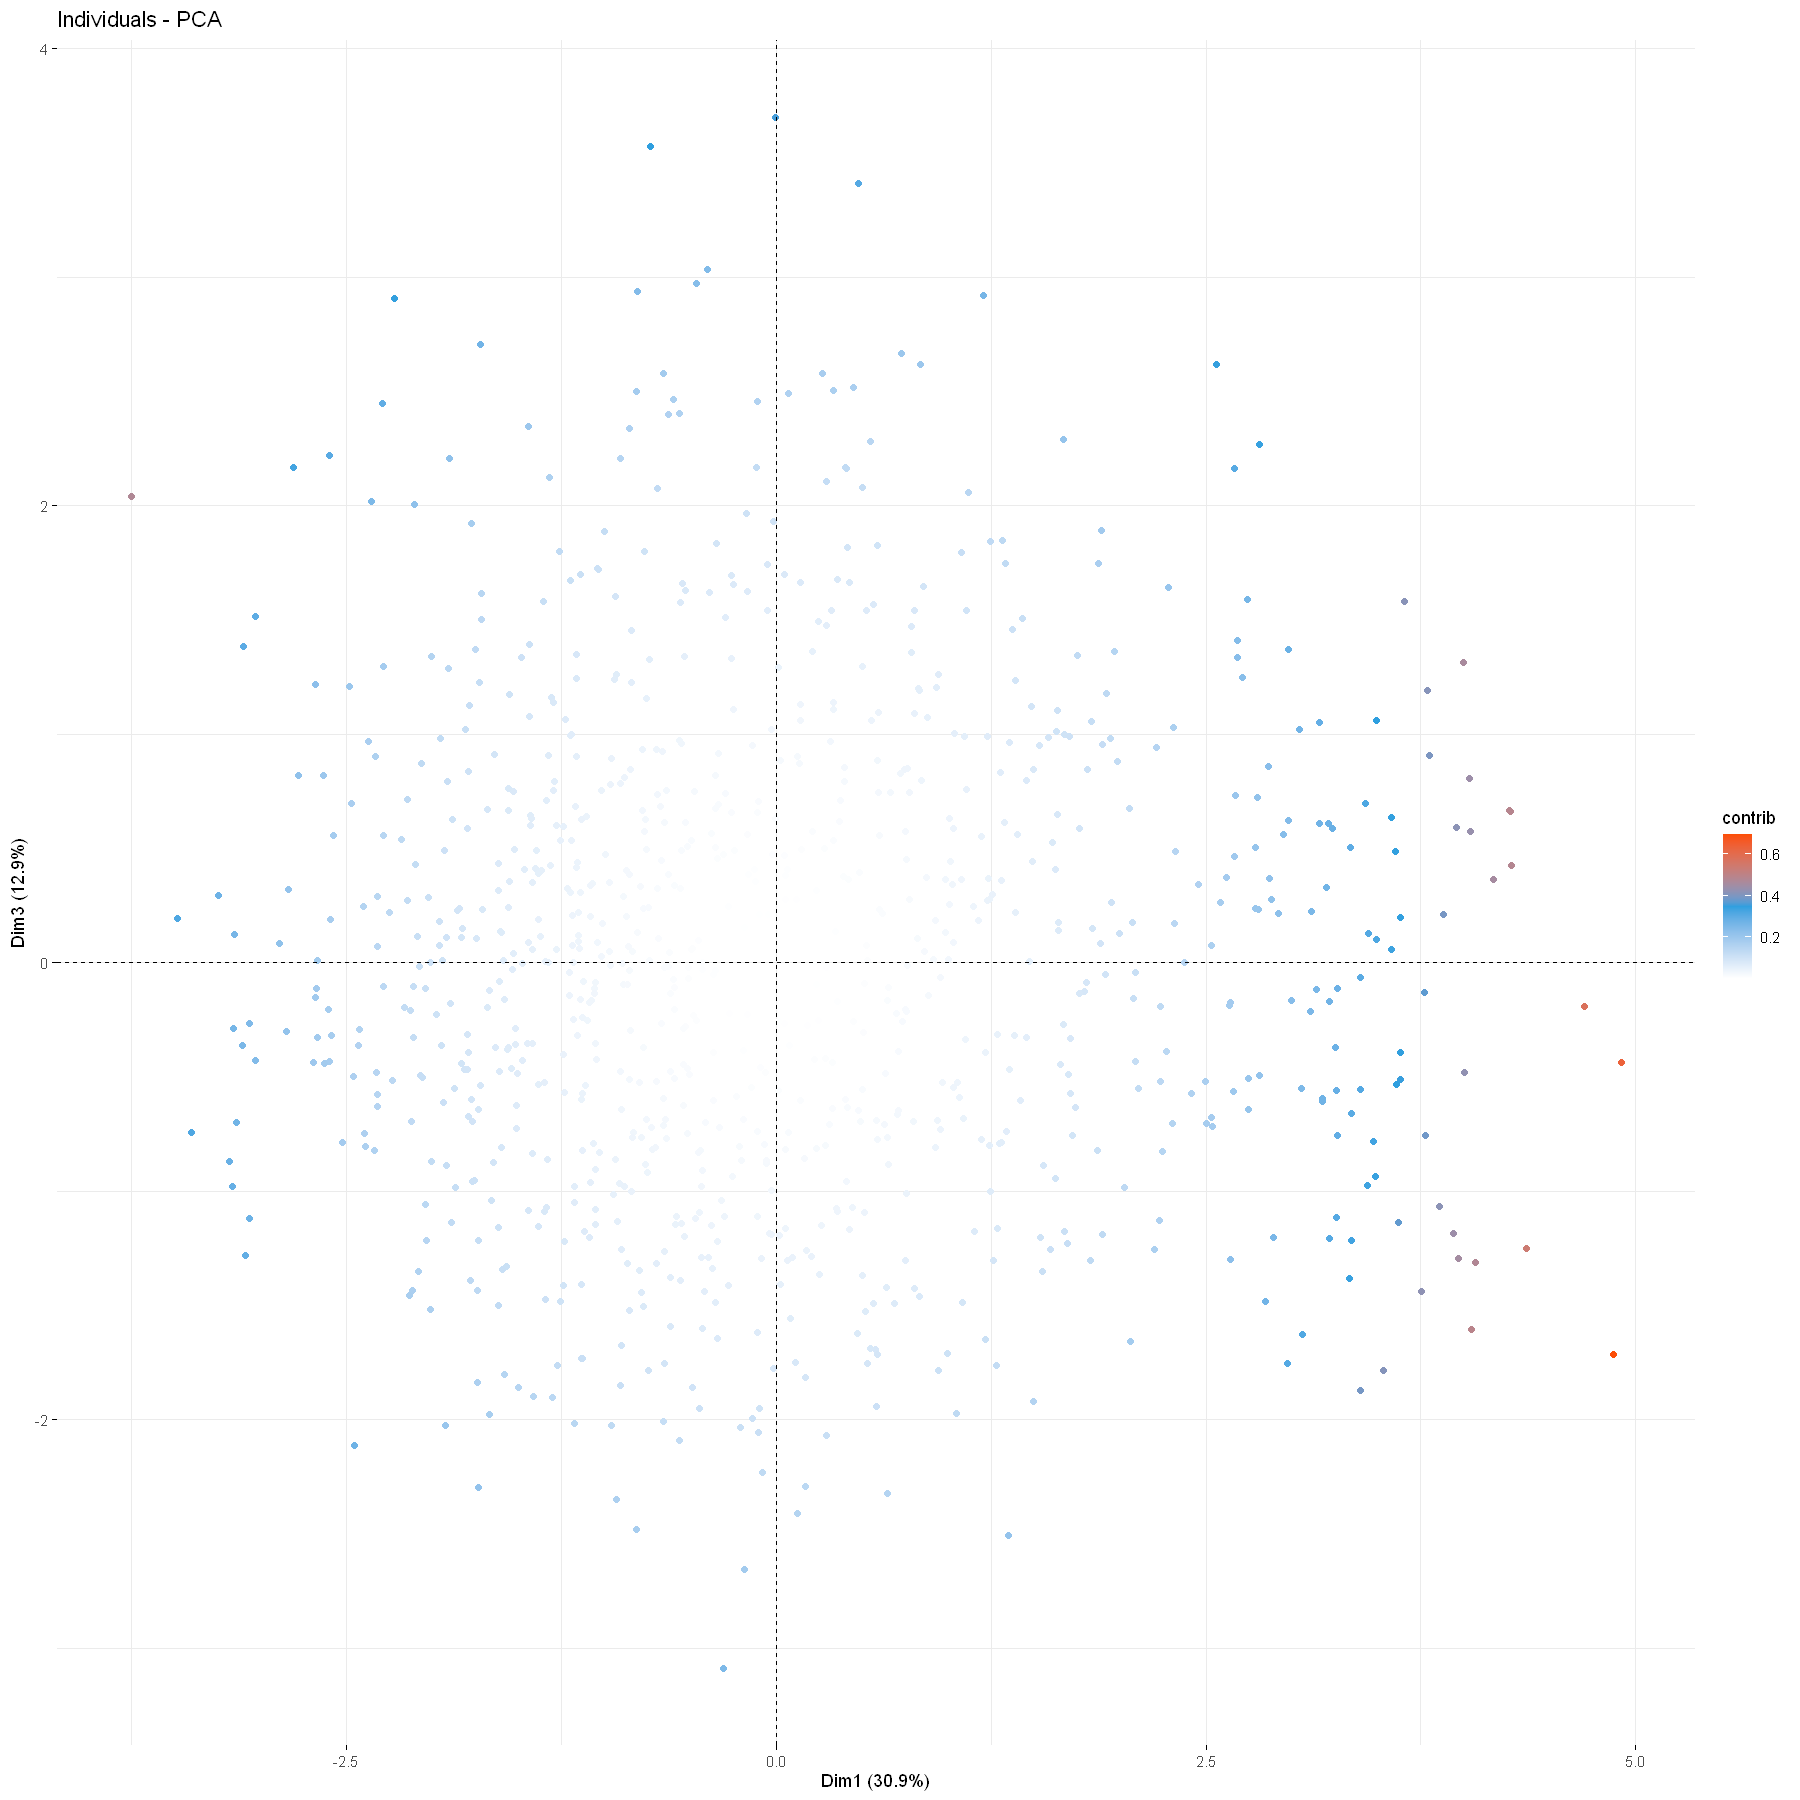

In [27]:
fviz_pca_var(acp)
fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ))
fviz_pca_var(acp,axes=c(1,3))
fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ),axes=c(1,3))

In [28]:
head(data_acp)

,Age,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Fat_Percentage,Water_Intake..liters.,BMI
,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,56,88.3,1.71,180,157,60,1.69,1313,12.6,3.5,30.20
2,46,74.9,1.53,179,151,66,1.30,883,33.9,2.1,32.00
3,32,68.1,1.66,167,122,54,1.11,677,33.4,2.3,24.71
4,25,53.2,1.70,190,164,56,0.59,532,28.8,2.1,18.41
5,38,46.1,1.79,188,158,68,0.64,556,29.2,2.8,14.39
6,56,58.0,1.68,168,156,74,1.59,1116,15.5,2.7,20.55


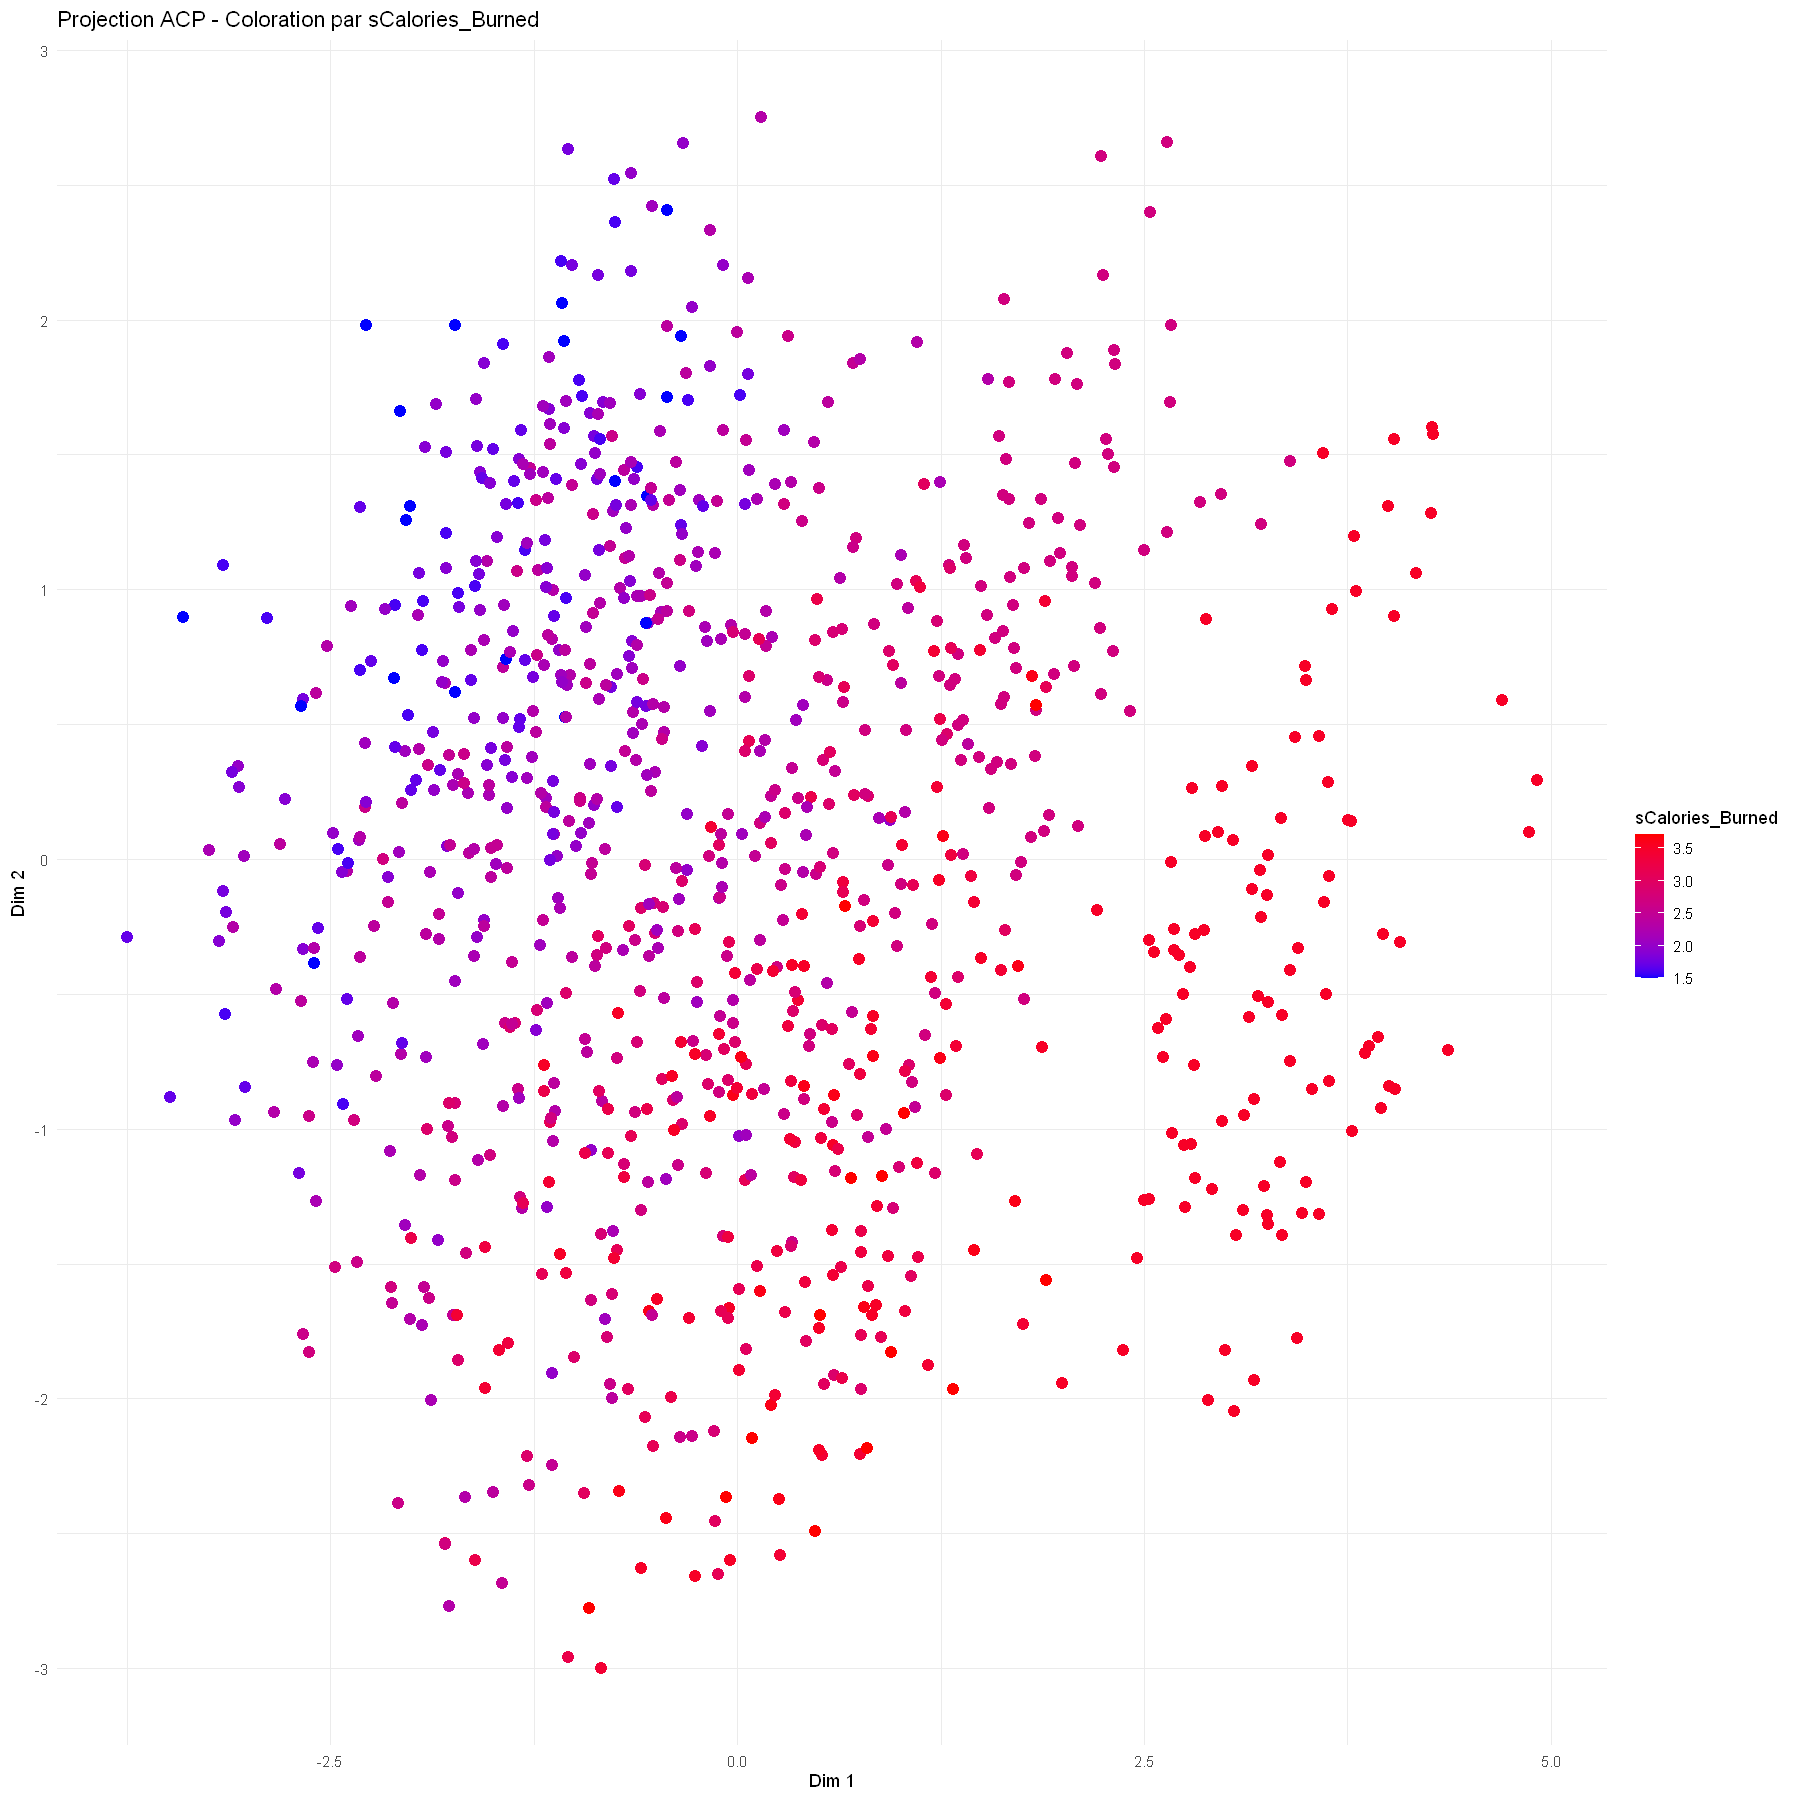

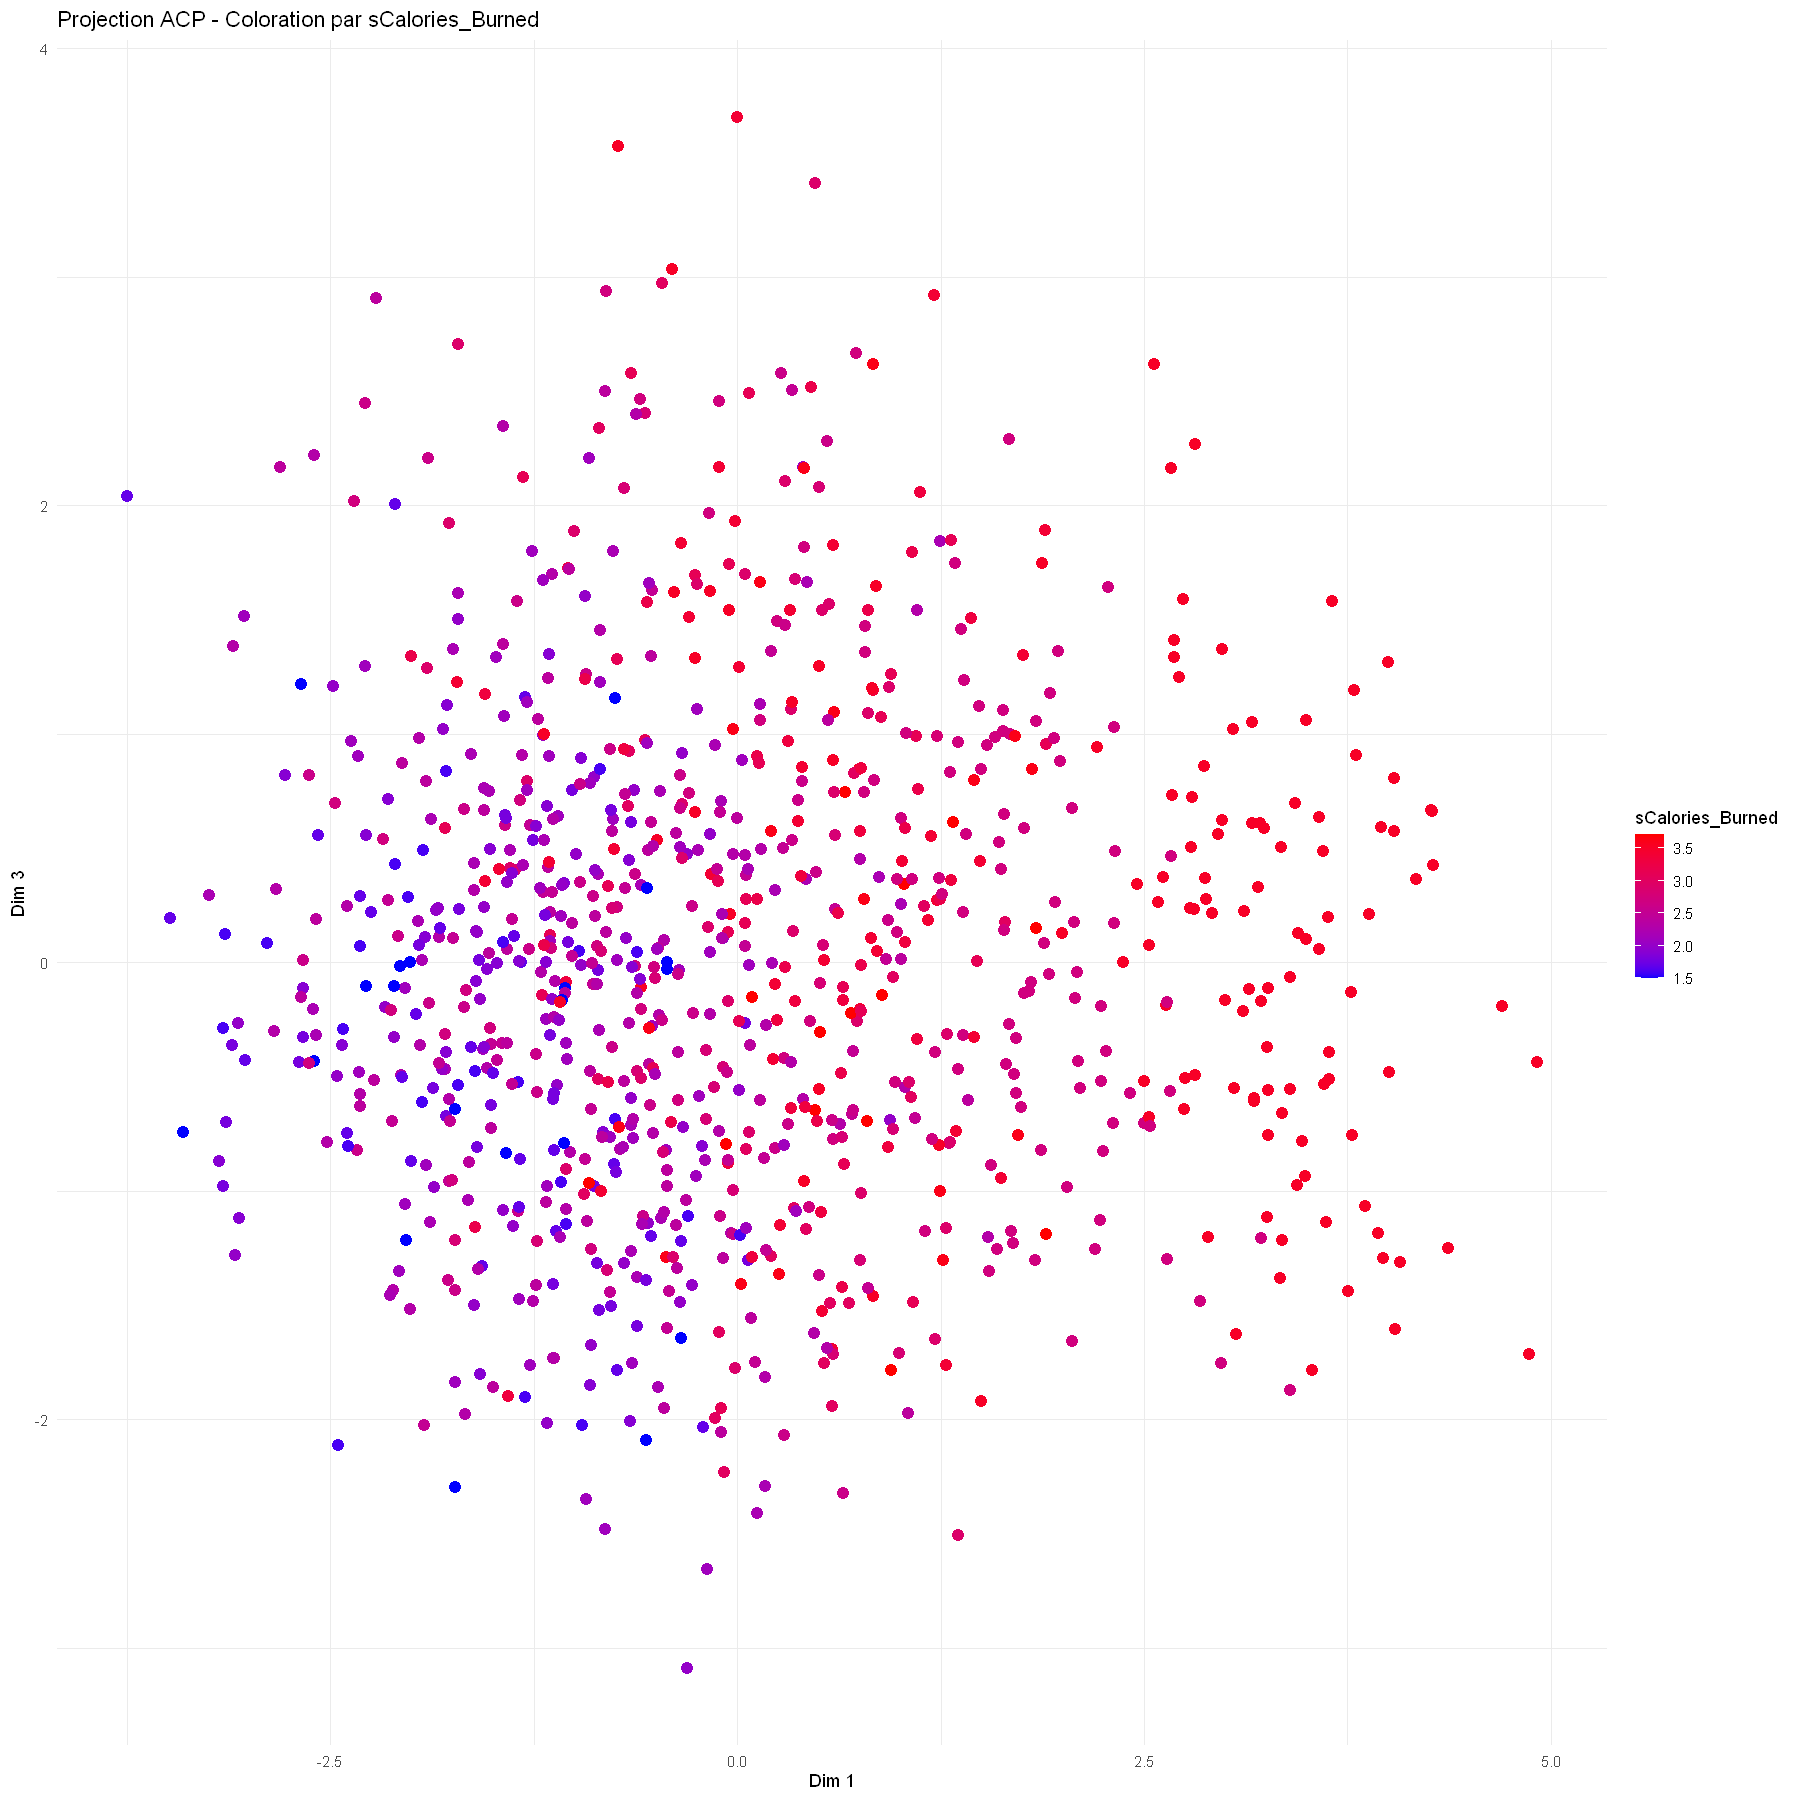

In [29]:
#fviz_pca_ind(acp, label="none", habillage=10)

# Récupération des coordonnées des individus
ind <- get_pca_ind(acp)
df_ind <- data.frame(ind$coord)  # Coordonnées des individus

# Ajouter la variable continue sCalories_Burned pour la colorisation
df_ind$sCalories_Burned <- data_acp[, 10]  

# Graphique avec fviz_pca_ind et ggplot2 pour un meilleur contrôle
ggplot(df_ind, aes(x = Dim.1, y = Dim.2, color = sCalories_Burned)) +
  geom_point(size = 3) +
  scale_color_gradient(low = "blue", high = "red") +  # Dégradé bleu → rouge
  theme_minimal() +
  labs(title = "Projection ACP - Coloration par sCalories_Burned",
       x = "Dim 1",
       y = "Dim 2",
       color = "sCalories_Burned")

ggplot(df_ind, aes(x = Dim.1, y = Dim.3, color = sCalories_Burned)) +
  geom_point(size = 3) +
  scale_color_gradient(low = "blue", high = "red") +  # Dégradé bleu → rouge
  theme_minimal() +
  labs(title = "Projection ACP - Coloration par sCalories_Burned",
       x = "Dim 1",
       y = "Dim 3",
       color = "sCalories_Burned")

# 2. Modélisation (langage R)

# 2.1 Prédiction des calories brulées (régression)

## 2.1.1 Séparation des données en jeu de test et jeu d'entrainement

In [30]:
set.seed(111) # On initialise la graine aléatoire pour la reproducibilité des résultats

# On va utiliser 20% de l'échantillon pour les tests et le reste pour l'apprentissage
test.ratio <- .2
npop <- nrow(data_norm)
nvar <- ncol(data_norm)
ntest <- ceiling(npop * test.ratio) 

testi <- sample(1:npop, ntest)
appri <- setdiff(1:npop, testi) 

datappr0 <- data_norm[appri, -11] 
datestr0 <- data_norm[testi, -11]

datappr0quanti <- datappr0[c(1,3,4,5,6,7,8,9,11,14)]
datestr0quanti <- datestr0[c(1,3,4,5,6,7,8,9,11,14)]

In [31]:
# Normalisation des variables quantitatives dans l'échantillon d'apprentissage
datappr=datappr0
datapprquanti=as.data.frame(scale(datappr0quanti))
datappr[c(1,3,4,5,6,7,8,9,11,14)]=datapprquanti

# Normalisation de l'échantillon test à l'aide des caractéristiques de l'échantillon d'apprentissage
datestr=datestr0
datestrquanti=as.data.frame(scale(datestr0quanti,center=sapply(datestr0quanti,mean),scale=sapply(datestr0quanti,sd)))
datestr[c(1,3,4,5,6,7,8,9,11,14)]=datestrquanti

In [32]:
# Fonction pour l'affichage des résidus
gplot.res <- function(fit, res, titre = "") {
  df <- data.frame(fit = fit, res = res)
  df <- df[is.finite(df$fit) & is.finite(df$res), ]
  ggplot(df, aes(x = fit, y = res)) +
    geom_point(col = "blue") +
    ylab("Résidus")+ xlab("Valeurs prédites")+
    geom_hline(yintercept = 0, col = "green") +
    ggtitle(titre)
}

## 2.1.2 Régression par modèles linéaires 

### modèle linéaire sans interactions:


Call:
lm(formula = sCalories_Burned ~ ., data = datappr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.56040 -0.07267  0.00352  0.07802  0.39233 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    -0.1286482  0.0156893  -8.200 1.03e-15 ***
Age                            -0.1446534  0.0044385 -32.590  < 2e-16 ***
GenderMale                      0.2953813  0.0158494  18.637  < 2e-16 ***
sWeight..kg.                   -0.0434233  0.0733915  -0.592   0.5543    
Height..m.                      0.0323214  0.0393866   0.821   0.4121    
Max_BPM                         0.0048163  0.0044624   1.079   0.2808    
Avg_BPM                         0.3232807  0.0044271  73.024  < 2e-16 ***
Resting_BPM                     0.0075797  0.0044417   1.707   0.0883 .  
Session_Duration..hours.        0.9479217  0.0070881 133.734  < 2e-16 ***
Workout_TypeHIIT               -0.0073398  0.0127066  -0.578   0.5637    
Workout_T

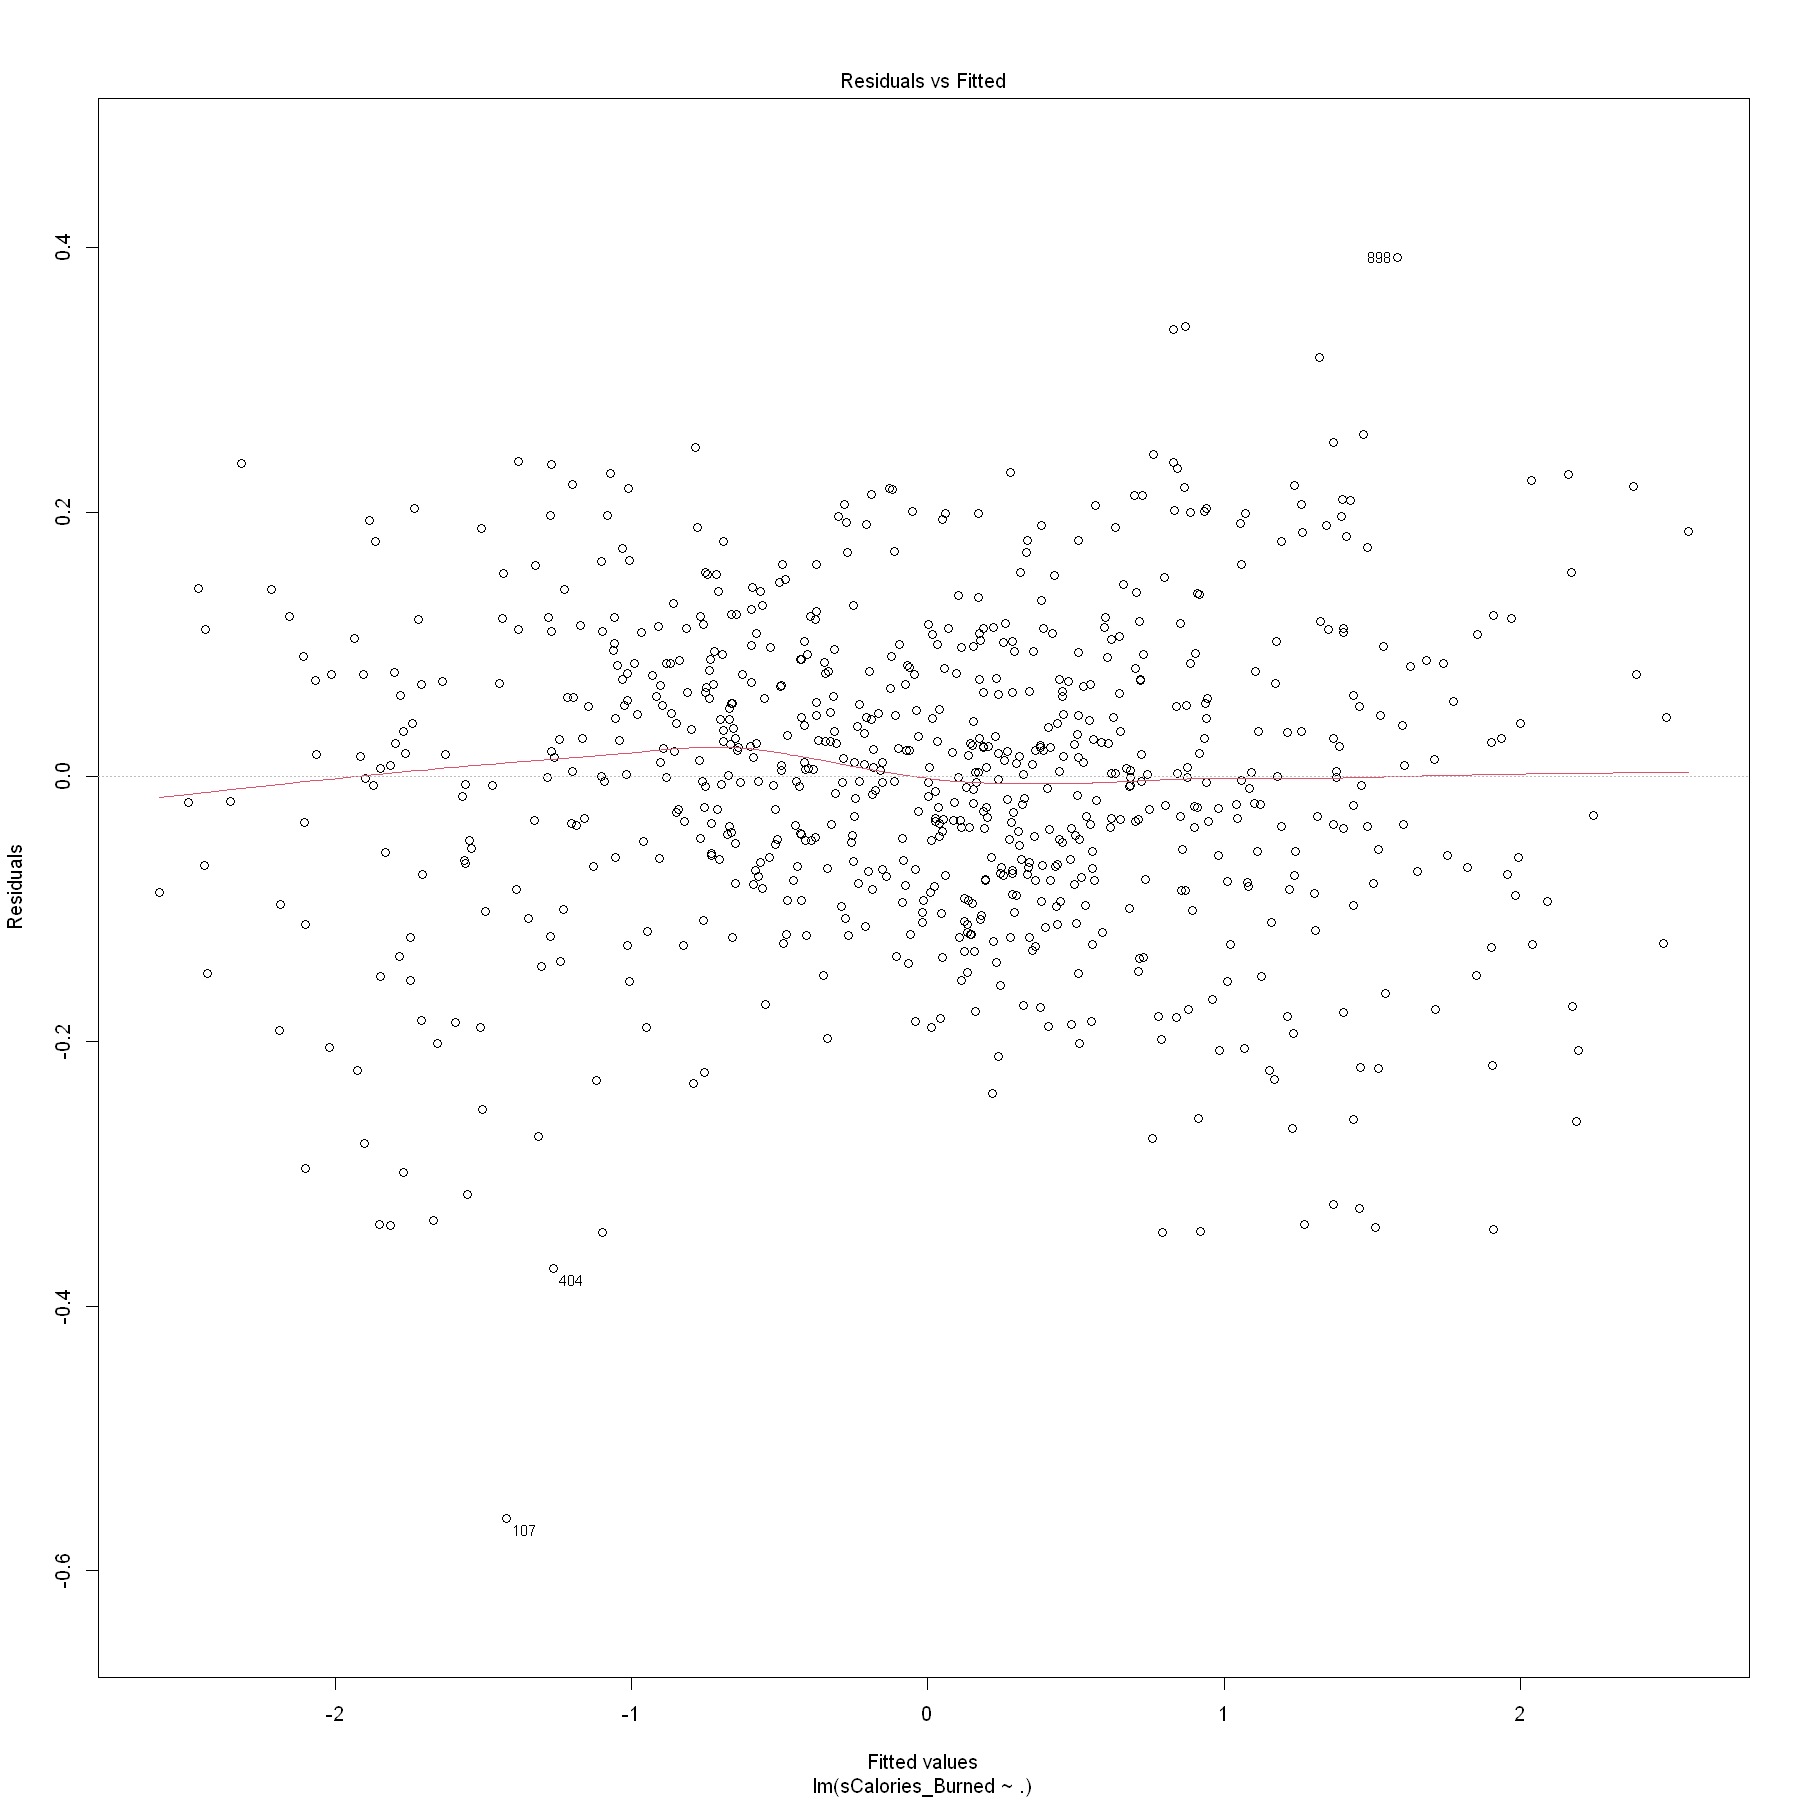

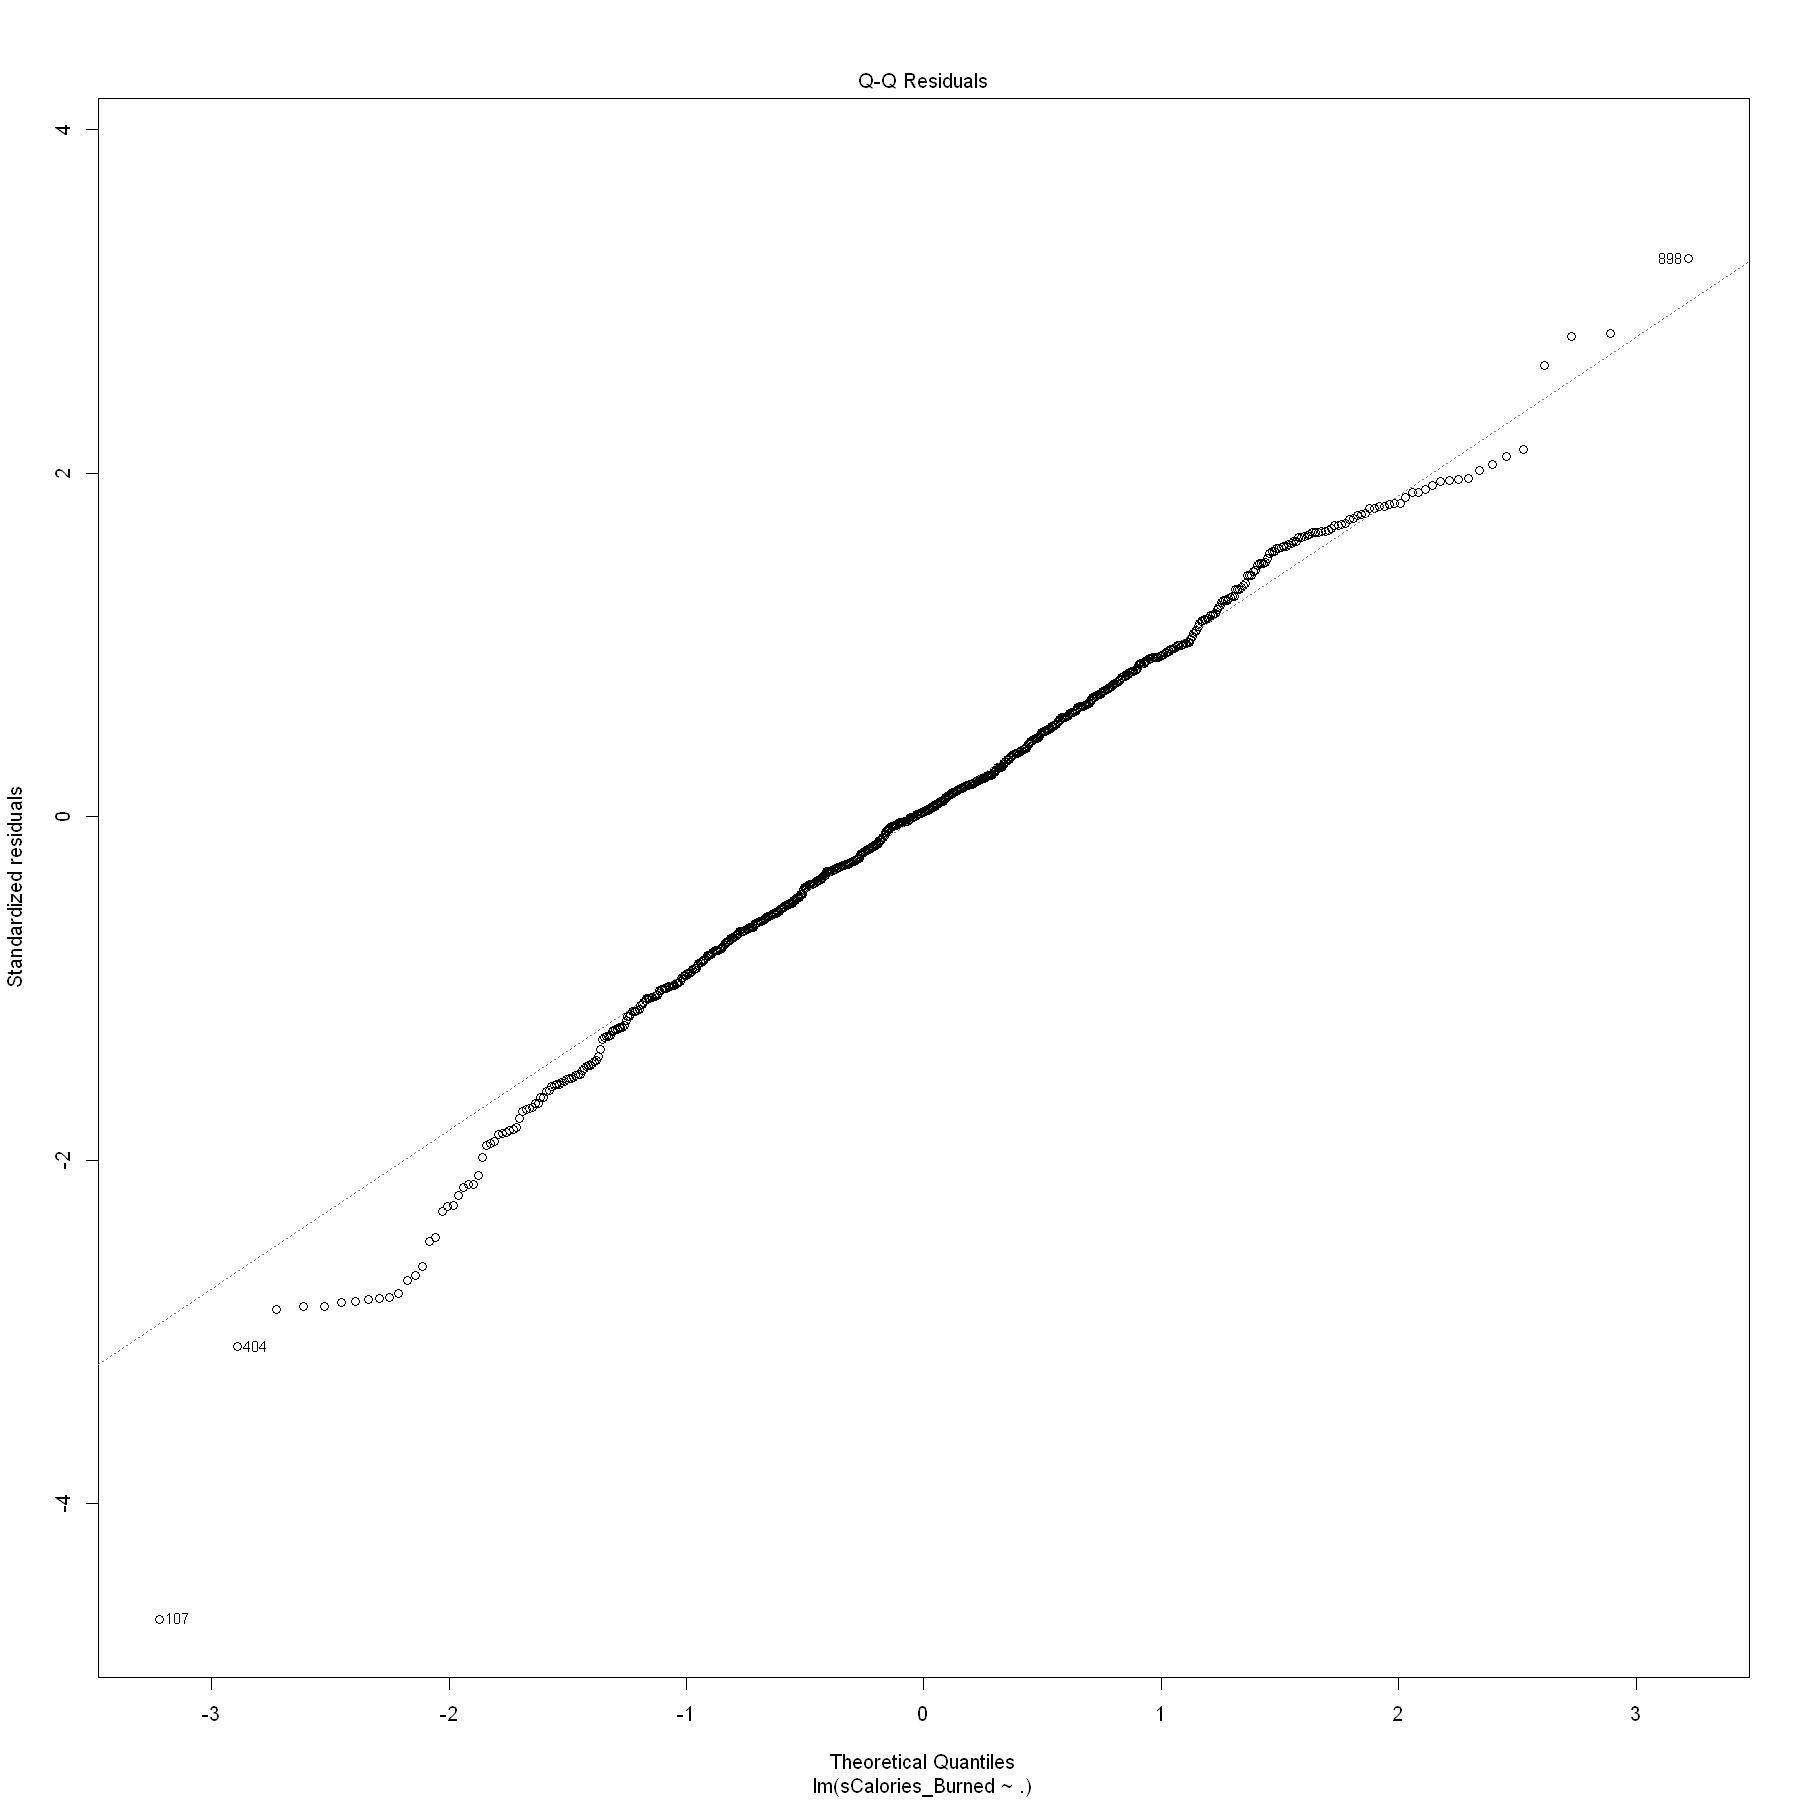

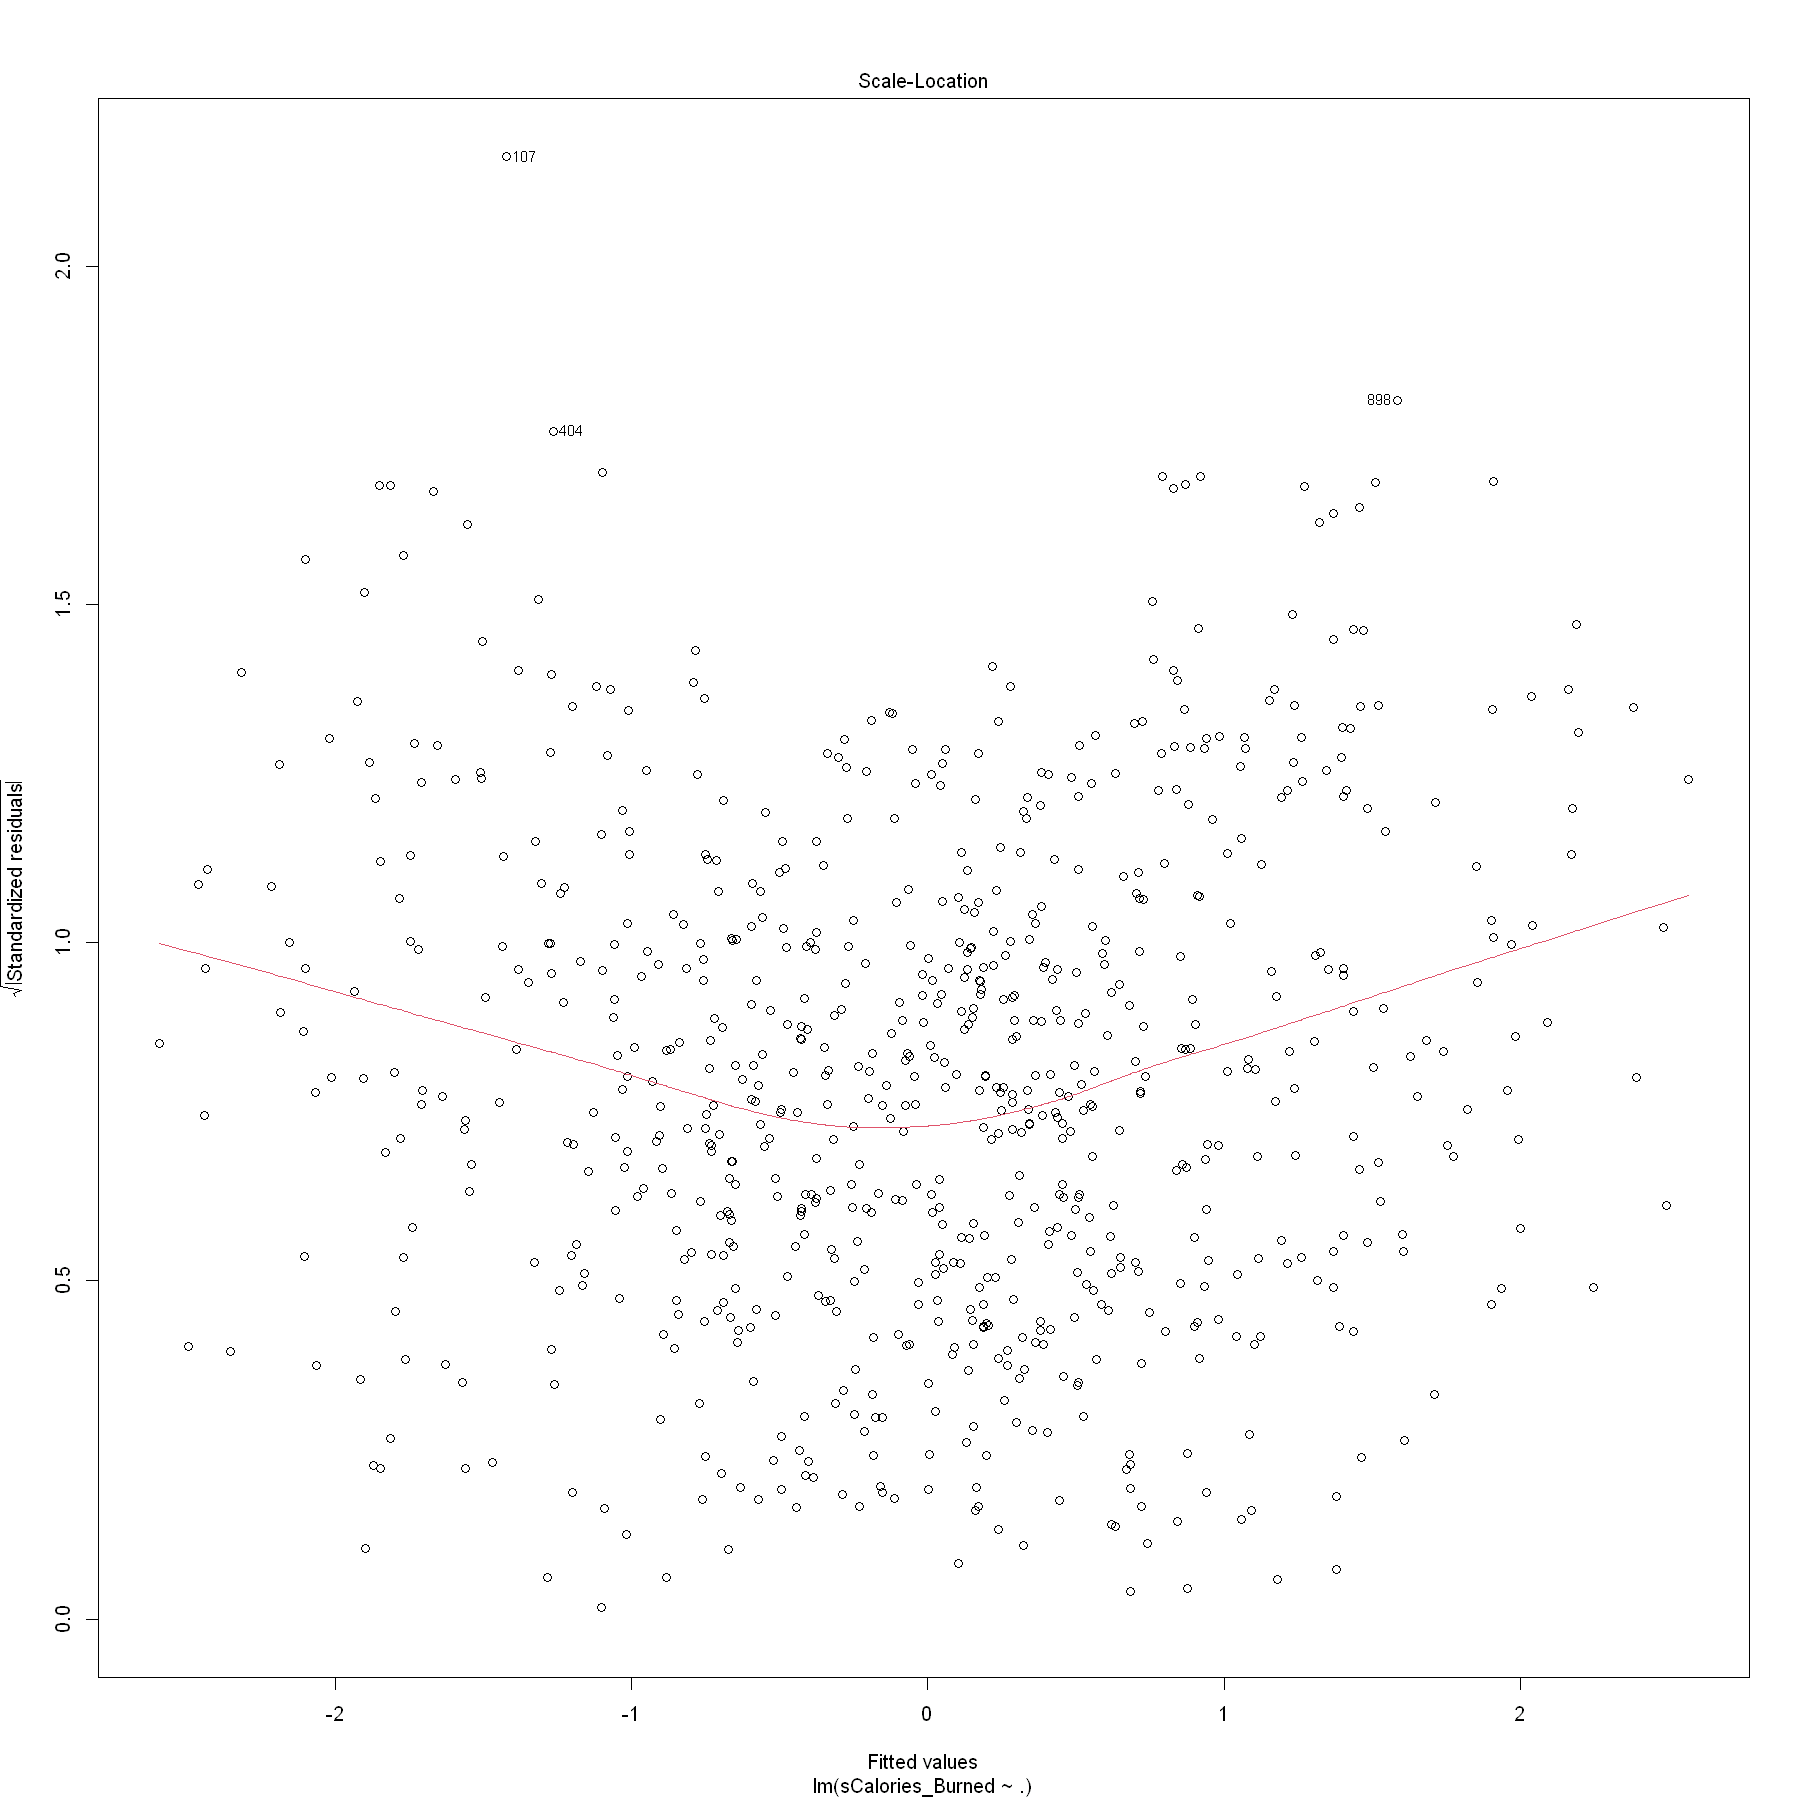

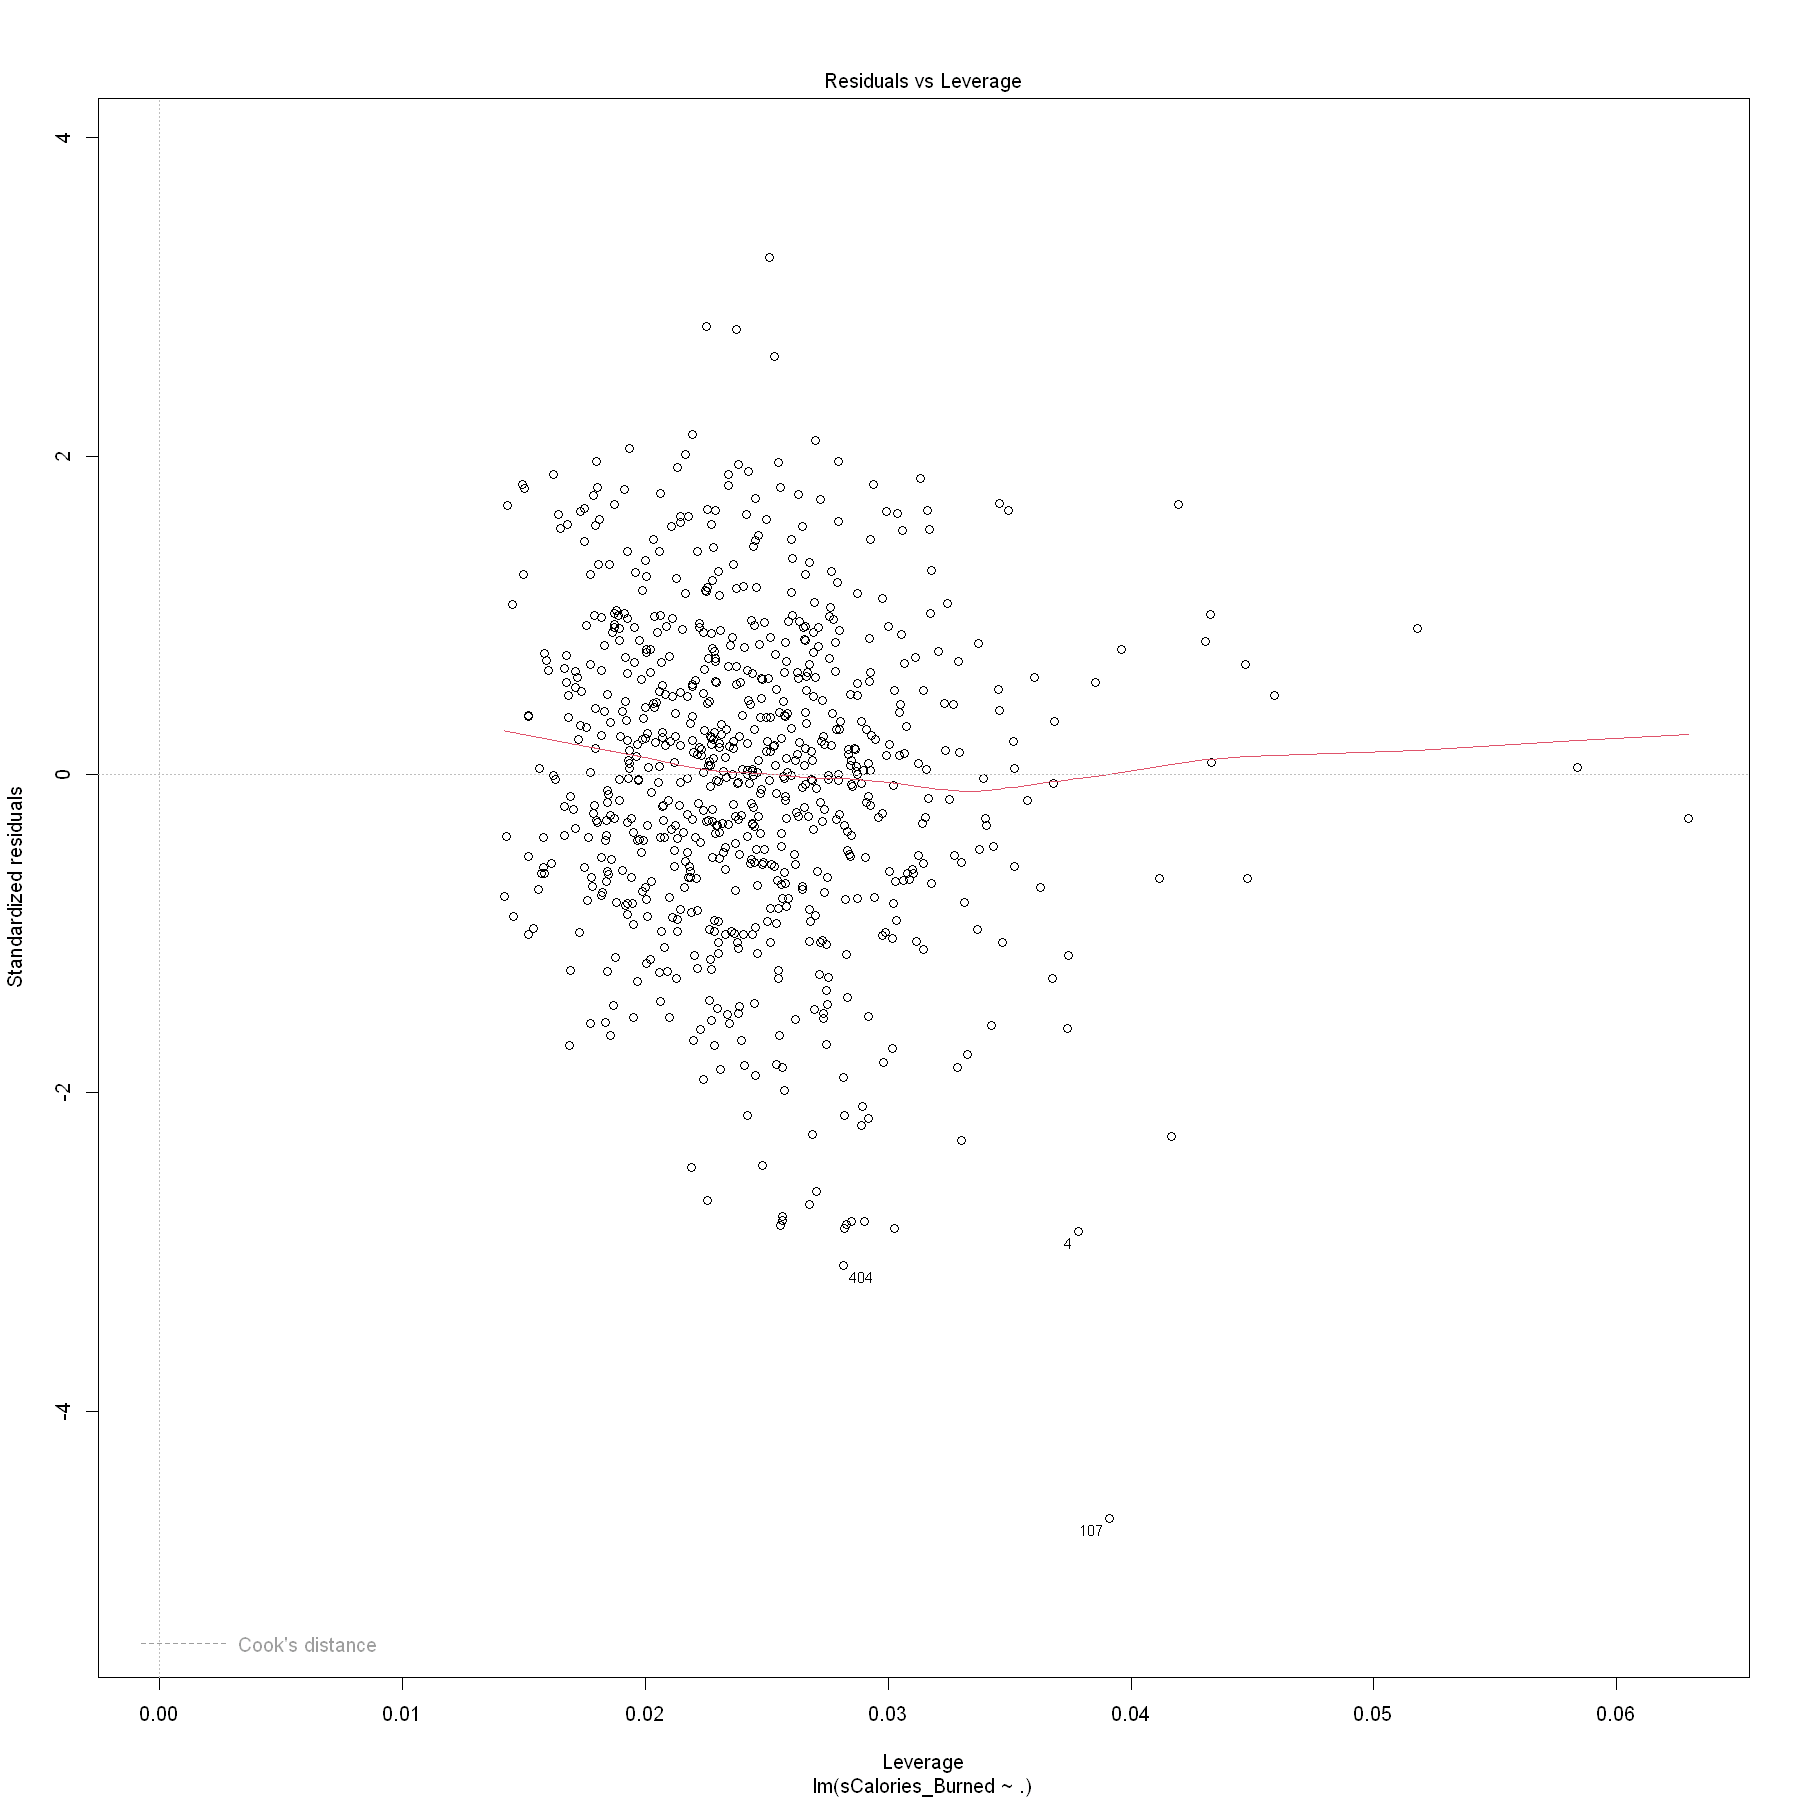

In [33]:
# On fit un modèle linéaire sans intéractions:
reg = lm(sCalories_Burned ~ ., data = datappr)

summary(reg)
plot(reg)

Le adjusted R-square du modèle est très bon avec une valeur de 0.985. Les coefficients les plus pertinents selon le sommaire sont l'age, le genre, la durée de la session et le BPM moyen (et l'intercept). 

Au niveau des résidus, les hypothèses du modèle linéaire semblent plutôt respectées.

### Comparaison sur l'échantillon de test:

In [35]:
y_test <- datestr$sCalories_Burned

test_lineaire <- predict(reg, newdata = datestr)
rmse <- sqrt(mean((y_test - test_lineaire)^2))

cat("RMSE pour le modèle linéaire :", rmse, "\n")

RMSE pour le modèle linéaire : 0.1275748 


le RMSE est assez faible, les prédictions du modèle sont donc plutôt bonnes

### Modèle linéaire avec pénalisation lasso

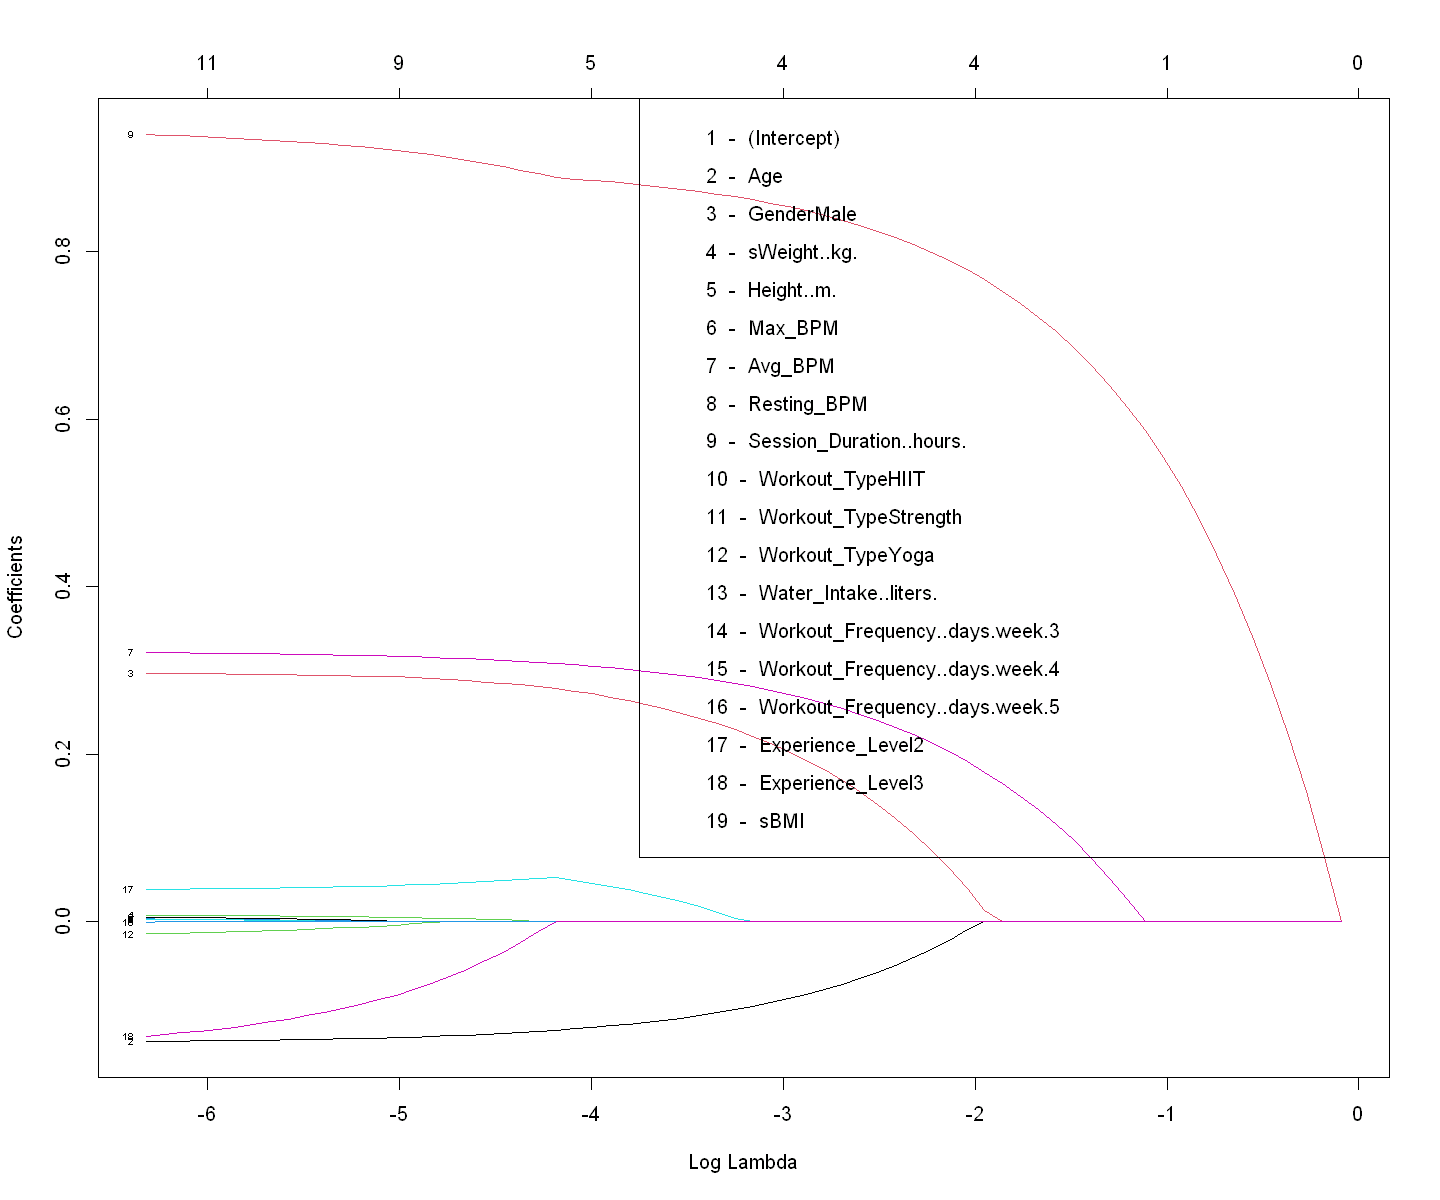

In [37]:
# model matrix permet de transformer les variables qualitatives en variables dummy
x.mat <- model.matrix(sCalories_Burned ~ . , data = datappr)
x.mat_test <- model.matrix(sCalories_Burned ~ . , data = datestr)

# on affiche les chemins de régularisation des variables lasso
reg.lasso <- glmnet(y = datappr$sCalories_Burned, x = x.mat)
options(repr.plot.width = 12, repr.plot.height = 10)
plot(reg.lasso, xvar = "lambda", label = TRUE)
legend("topright", 
       legend = paste(1:ncol(x.mat), " - ", colnames(x.mat)))

On voit que les coefficients gardés sont en partie les mêmes que ceux qui étaient jugés les plus importants par le modèle linéaire (dans l'ordre: age, genre, poids). Cependan, certaines variables comme la taille et le BPM maximal sont ici jugées plus importantes que le BPM moyen et la durée de la session qui étaient jugées plus importantes précèdement.

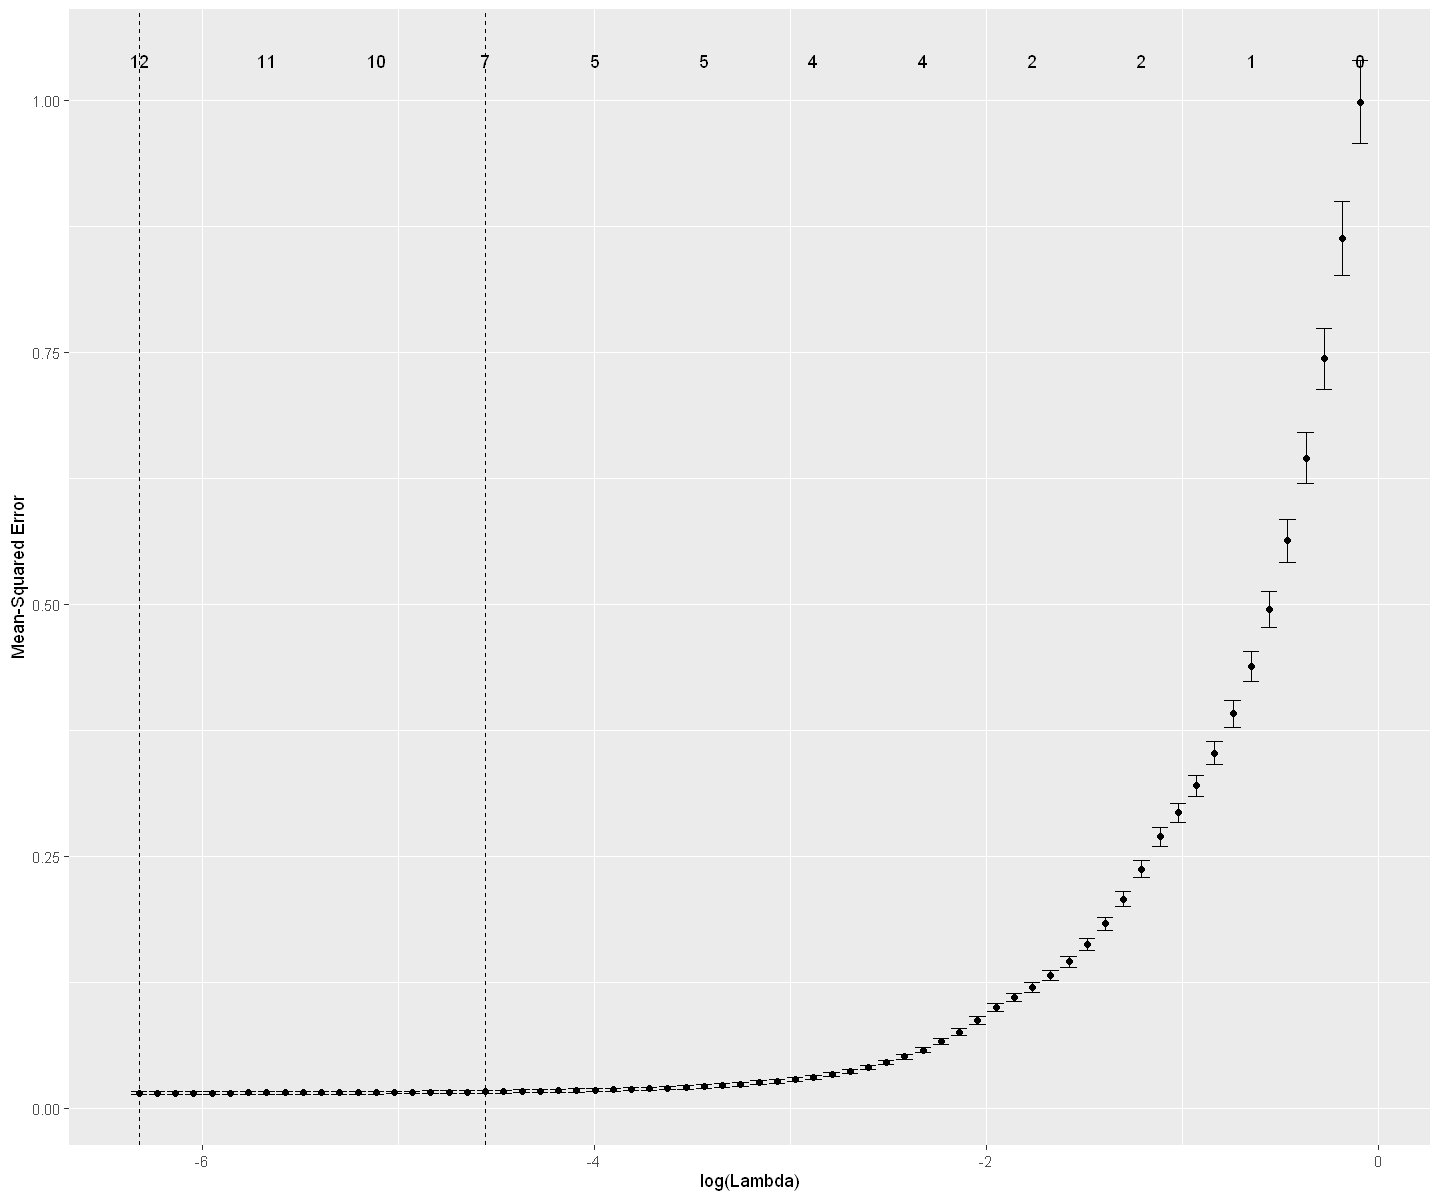

In [38]:
# On affiche ici le MSE du modèle en fonction de log(Lambda) sur les données d'apprentissage

reg.lasso.cv <- cv.glmnet(y = datappr$sCalories_Burned, x = x.mat)
autoplot(reg.lasso.cv)

On remarque que le modèle à de meilleurs résultats avec un coefficient lambda petit (log(lambda) entre -6 et -3 environ), c'est à dire en ayant un modèle proche du modèle linéaire. On peut donc questionner l'utilité d'utiliser la pénalisation lasso ici.

In [39]:
lambda_min <- reg.lasso.cv$lambda.min
y <- datappr$sCalories_Burned
modelmin <- glmnet(x = x.mat, y = y, lambda = lambda_min, standardize = FALSE)

y_pred_min <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat)

rmse <- sqrt(mean((y - y_pred_min)^2))

ss_res <- sum((y - y_pred_min)^2)
ss_tot <- sum((y - mean(y))^2)
r2 <- 1 - ss_res / ss_tot

cat("Lambda:", lambda_min, "\n")
cat("RMSE:", round(rmse, 4), "\n")
cat("R²:", round(r2, 4), "\n")
print(coef(reg.lasso.cv, s = "lambda.min"))

Lambda: 0.001796301 
RMSE: 0.1212 
R²: 0.9853 
20 x 1 sparse Matrix of class "dgCMatrix"
                                          s1
(Intercept)                    -0.1427487431
(Intercept)                     .           
Age                            -0.1428537344
GenderMale                      0.2966135340
sWeight..kg.                    0.0079710330
Height..m.                      0.0032770306
Max_BPM                         0.0032450410
Avg_BPM                         0.3214589060
Resting_BPM                     0.0055978142
Session_Duration..hours.        0.9401380416
Workout_TypeHIIT                .           
Workout_TypeStrength            .           
Workout_TypeYoga               -0.0145618302
Water_Intake..liters.           .           
Workout_Frequency..days.week.3  .           
Workout_Frequency..days.week.4  .           
Workout_Frequency..days.week.5 -0.0004670638
Experience_Level2               0.0386113928
Experience_Level3              -0.1365000822
sBMI       

Le RMSE est très faiblement meilleur que pour le modèle linéaire et le R-square est un peu moins bon (mais cv.glmnet optimise lambda pour avoir le meilleur RMSE possible donc c'est cohérent). 

On conserve 13 coefficients non nuls

In [40]:
#On ré-itére en utilisant le lambda 1se qui est plus grand mais à une erreur similaire à un écart-type près, cela permet d'utiliser moins de variables

lambda_1se <- reg.lasso.cv$lambda.1se
model1se <- glmnet(x = x.mat, y = y, lambda = lambda_1se, standardize = FALSE)

y_pred_1se <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat)

rmse <- sqrt(mean((y - y_pred_1se)^2))

ss_res <- sum((y - y_pred_1se)^2)
ss_tot <- sum((y - mean(y))^2)
r2 <- 1 - ss_res / ss_tot

cat("Lambda:", lambda_1se, "\n")
cat("RMSE:", round(rmse, 4), "\n")
cat("R²:", round(r2, 4), "\n")

print(coef(reg.lasso.cv, s = "lambda.1se"))

Lambda: 0.01052097 
RMSE: 0.1265 
R²: 0.984 
20 x 1 sparse Matrix of class "dgCMatrix"
                                         s1
(Intercept)                    -0.161818949
(Intercept)                     .          
Age                            -0.134455822
GenderMale                      0.286260944
sWeight..kg.                    0.002773115
Height..m.                      .          
Max_BPM                         .          
Avg_BPM                         0.313206927
Resting_BPM                     .          
Session_Duration..hours.        0.906183076
Workout_TypeHIIT                .          
Workout_TypeStrength            .          
Workout_TypeYoga                .          
Water_Intake..liters.           .          
Workout_Frequency..days.week.3  .          
Workout_Frequency..days.week.4  .          
Workout_Frequency..days.week.5  .          
Experience_Level2               0.047833324
Experience_Level3              -0.046772499
sBMI                            .

Les performances sont comparables bien que un peu moins bonne mais on utilise 5 coefficients de moins.

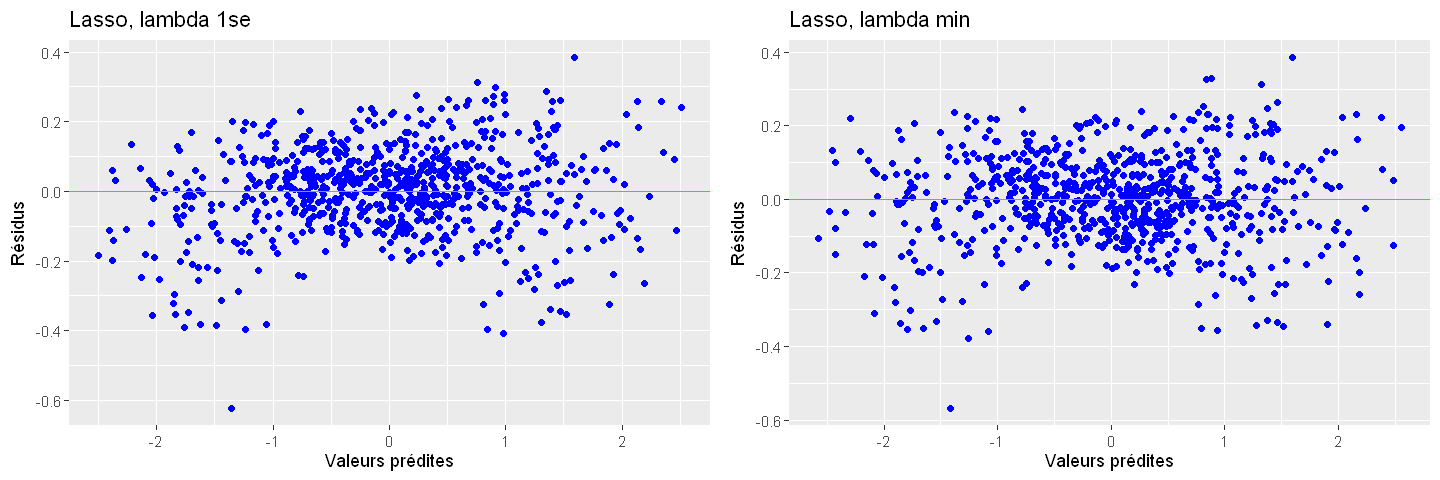

In [80]:
# Affichage des résidus:
res1se <- y - y_pred_1se
resmin <- y - y_pred_min

g1<-gplot.res(y_pred_1se, res1se, "Lasso, lambda 1se")
g2<-gplot.res(y_pred_min, resmin, "Lasso, lambda min")
grid.arrange(g1,g2,ncol=2)

### RMSE sur l'échantillon de test:

In [41]:
y_test <- datestr$sCalories_Burned

test_1se <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat_test)
test_min <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat_test)

rmse_1se <- sqrt(mean((y_test - test_1se)^2))
rmse_min <- sqrt(mean((y_test - test_min)^2))

cat("RMSE pour lambda.min :", rmse_min, "\n")
cat("RMSE pour lambda.1se :", rmse_1se, "\n")

RMSE pour lambda.min : 0.1281096 
RMSE pour lambda.1se : 0.1357074 


Comme attendu, les résultats sont un peu moins bon que sur les données d'apprentissage mais restent comparables

### modèle linéaire avec interactions d'ordre 2

On utilise ici un modèle linéaire avec les interactions d'ordre 2. On utilise la méthode backward pour la sélection des variables. On compare les résultats avec 2 critères différents: AIC et BIC

In [44]:
# Modèle avec toutes les interactions d'ordre 2
reg.glm <- glm(sCalories_Burned ~ .^2, data = datappr)

# Selection de modèle backward avec AIC:
reg.glm.step.aic <- step(reg.glm, direction = "backward")

Start:  AIC=-1327.56
sCalories_Burned ~ (Age + Gender + sWeight..kg. + Height..m. + 
    Max_BPM + Avg_BPM + Resting_BPM + Session_Duration..hours. + 
    Workout_Type + Water_Intake..liters. + Workout_Frequency..days.week. + 
    Experience_Level + sBMI)^2


Step:  AIC=-1327.56
sCalories_Burned ~ Age + Gender + sWeight..kg. + Height..m. + 
    Max_BPM + Avg_BPM + Resting_BPM + Session_Duration..hours. + 
    Workout_Type + Water_Intake..liters. + Workout_Frequency..days.week. + 
    Experience_Level + sBMI + Age:Gender + Age:sWeight..kg. + 
    Age:Height..m. + Age:Max_BPM + Age:Avg_BPM + Age:Resting_BPM + 
    Age:Session_Duration..hours. + Age:Workout_Type + Age:Water_Intake..liters. + 
    Age:Workout_Frequency..days.week. + Age:Experience_Level + 
    Age:sBMI + Gender:sWeight..kg. + Gender:Height..m. + Gender:Max_BPM + 
    Gender:Avg_BPM + Gender:Resting_BPM + Gender:Session_Duration..hours. + 
    Gender:Workout_Type + Gender:Water_Intake..liters. + Gender:Workout_Frequency..da

In [45]:
n <- nrow(datappr)
# Selection de modèle avec BIC:
reg.glm.step.bic <- step(reg.glm, direction = "backward", k = log(n))

Start:  AIC=-596.45
sCalories_Burned ~ (Age + Gender + sWeight..kg. + Height..m. + 
    Max_BPM + Avg_BPM + Resting_BPM + Session_Duration..hours. + 
    Workout_Type + Water_Intake..liters. + Workout_Frequency..days.week. + 
    Experience_Level + sBMI)^2


Step:  AIC=-596.45
sCalories_Burned ~ Age + Gender + sWeight..kg. + Height..m. + 
    Max_BPM + Avg_BPM + Resting_BPM + Session_Duration..hours. + 
    Workout_Type + Water_Intake..liters. + Workout_Frequency..days.week. + 
    Experience_Level + sBMI + Age:Gender + Age:sWeight..kg. + 
    Age:Height..m. + Age:Max_BPM + Age:Avg_BPM + Age:Resting_BPM + 
    Age:Session_Duration..hours. + Age:Workout_Type + Age:Water_Intake..liters. + 
    Age:Workout_Frequency..days.week. + Age:Experience_Level + 
    Age:sBMI + Gender:sWeight..kg. + Gender:Height..m. + Gender:Max_BPM + 
    Gender:Avg_BPM + Gender:Resting_BPM + Gender:Session_Duration..hours. + 
    Gender:Workout_Type + Gender:Water_Intake..liters. + Gender:Workout_Frequency..days

In [46]:
# Coefficients AIC
anova(reg.glm.step.aic, test = "F")

,Df,Deviance,Resid. Df,Resid. Dev,F,Pr(>F)
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
NULL,NA,NA,777,777.000000,NA,NA
Age,1,1.751784e+01,776,759.482165,2.070466e+03,2.524902e-213
Gender,1,1.388761e+01,775,745.594551,1.641404e+03,2.443641e-187
sWeight..kg.,1,1.481974e-02,774,745.579731,1.751574e+00,1.861020e-01
Height..m.,1,6.123356e-02,773,745.518498,7.237312e+00,7.307037e-03
Max_BPM,1,2.649288e-01,772,745.253569,3.131244e+01,3.130616e-08
Avg_BPM,1,1.006615e+02,771,644.592093,1.189737e+04,0.000000e+00
Resting_BPM,1,5.665400e-01,770,644.025553,6.696044e+01,1.267432e-15
Session_Duration..hours.,1,6.302510e+02,769,13.774542,7.449057e+04,0.000000e+00


In [47]:
# Coefficients BIC
anova(reg.glm.step.bic, test = "F")

,Df,Deviance,Resid. Df,Resid. Dev,F,Pr(>F)
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
NULL,NA,NA,777,777.000000,NA,NA
Age,1,17.51783506,776,759.482165,1892.209073,1.095555e-208
Gender,1,13.88761407,775,745.594551,1500.086583,3.210392e-182
Avg_BPM,1,100.18180197,774,645.412749,10821.252395,0.000000e+00
Resting_BPM,1,0.51921606,773,644.893533,56.083719,1.924395e-13
Session_Duration..hours.,1,631.06121916,772,13.832314,68164.802337,0.000000e+00
Experience_Level,2,2.32619647,770,11.506117,125.633391,6.983516e-48
sBMI,1,0.02523429,769,11.480883,2.725711,9.915620e-02
Age:Session_Duration..hours.,1,0.33040794,768,11.150475,35.689393,3.550080e-09


Le nombre de coefficients sélectionnés par le critère est bien plus faible (ce qui est logique car log(n)>2 ici, la pénalisation est donc plus forte pour BIC).

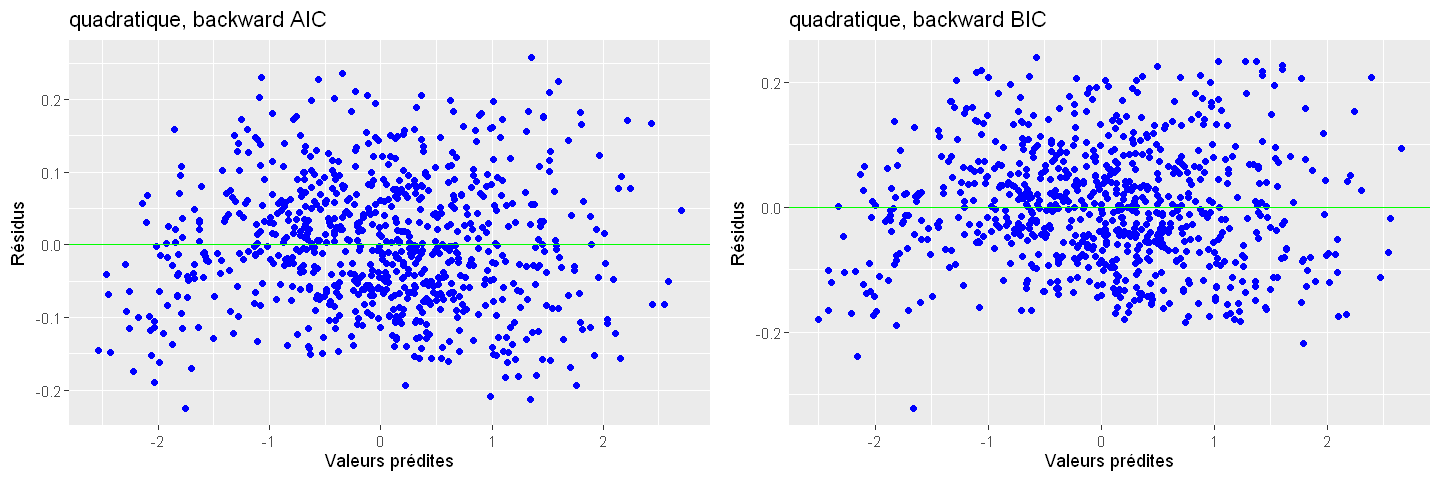

In [49]:
# Extraction des valeurs ajustées et des résidus
fit.glm.aic <- reg.glm.step.aic$fitted.values
res.glm.aic <- reg.glm.step.aic$residuals
fit.glm.bic <- reg.glm.step.bic$fitted.values
res.glm.bic <- reg.glm.step.bic$residuals


# Graphe des résidus
g1<-gplot.res(fit.glm.aic, res.glm.aic, "quadratique, backward AIC")
g2<-gplot.res(fit.glm.bic, res.glm.bic, "quadratique, backward BIC")
grid.arrange(g1,g2,ncol=2)

### RMSE sur l'échantillon de test:

In [50]:
# Comparaison des RMSE:

y_test <- datestr$sCalories_Burned

test_aic <- predict(reg.glm.step.aic, newdata  = datestr)
test_bic <- predict(reg.glm.step.bic, newdata  = datestr)

rmse_aic <- sqrt(mean((y_test - test_aic)^2))
rmse_bic <- sqrt(mean((y_test - test_bic)^2))

cat("RMSE pour AIC :", rmse_aic, "\n")
cat("RMSE pour BIC :", rmse_bic, "\n")

RMSE pour AIC : 0.1063492 
RMSE pour BIC : 0.09793335 


Les résultats sont meilleurs que pour le modèle linéaire classique ou celui avec pénalisation lasso. Cependant les modèles sont plus complexes

On remarque aussi que le modèle dont on a fait la sélection en suivant le critère BIC est meilleur alors qu'il utilise beaucoup moins de variables. Il est donc préférable de l'utiliser.

## 2.1.3 Régression par SVM

On réalise une SVM sur les données pour la regression, on commence par rechercher les paramètres optimaux:

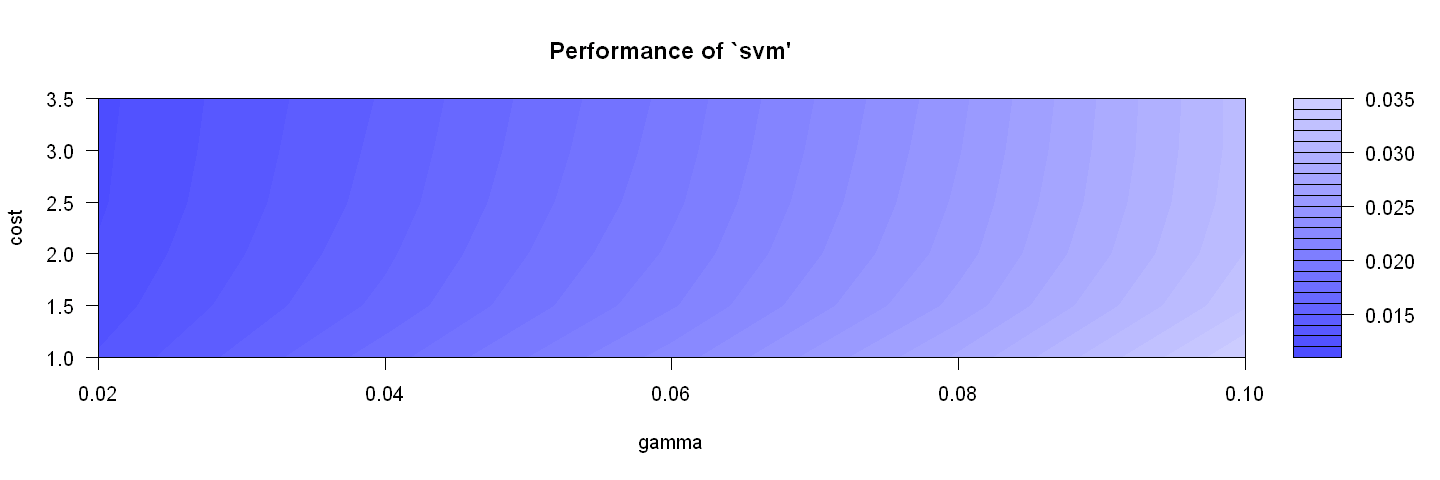

In [53]:
# Recherche des paramètres optimaux pour gamma et le coût (RMSE minimal):

svm.reg.tune = tune.svm(sCalories_Burned ~ ., data = datappr, cost = c(1, 1.5, 2, 2.5, 3, 3.5), 
    gamma = seq(0.02, 0.1, by = 0.02))
plot(svm.reg.tune)

# Le paramètre de coût est la paramètre de pénalisation et le paramètre gamma détermine l'influence des points

In [54]:
# On fit le modèle avec les paramètres optimisés pour RMSE:

svm.reg = svm(sCalories_Burned ~ ., data = datappr, cost = svm.reg.tune$best.parameters$cost, 
    gamma = svm.reg.tune$best.parameters$gamma)
summary(svm.reg)


Call:
svm(formula = sCalories_Burned ~ ., data = datappr, cost = svm.reg.tune$best.parameters$cost, 
    gamma = svm.reg.tune$best.parameters$gamma)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  3.5 
      gamma:  0.02 
    epsilon:  0.1 


Number of Support Vectors:  259






Les paramètres optimaux utilisés sont: cost = 3.5, gamma = 0.02

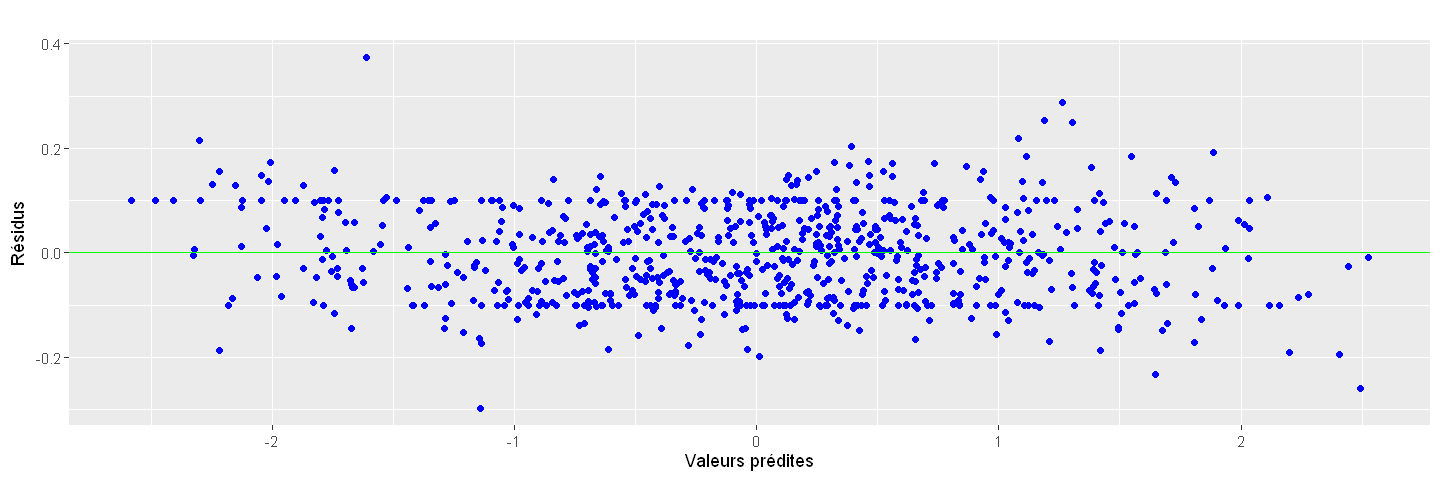

In [56]:
# Affichage des résidus
fit.svmr=fit.svmr=svm.reg$fitted
res.svmr=fit.svmr-datappr[,"sCalories_Burned"]
gplot.res(fit.svmr,res.svmr,titre="")

### RMSE sur l'échantillon de test:

In [57]:
test_svmr <- predict(svm.reg,newdata=datestr)

rmse_svmr <- sqrt(mean((y_test - test_svmr)^2))

cat("RMSE pour SVMR :", rmse_svmr, "\n")

RMSE pour SVMR : 0.1102439 


## 2.1.4 CART pour régression

Pour obtenir un arbre CART qui ne soit pas sur-entraîné on fait de la validation croisé sur l'échantillon d'apprentissage:

On optimise le paramètre de complexité cp

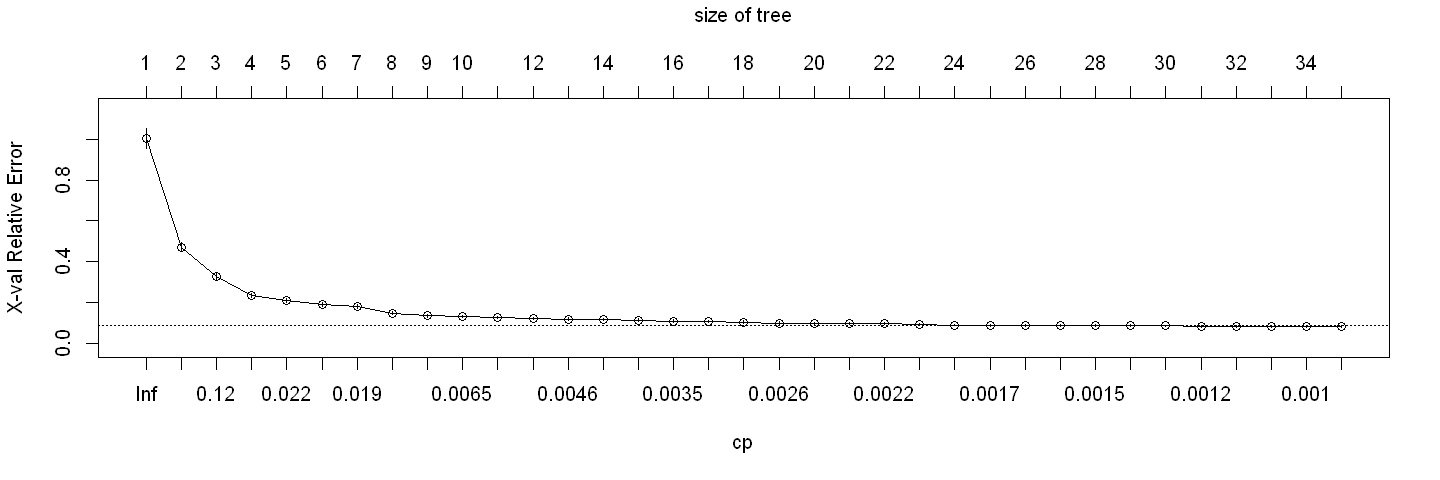

In [59]:
tree.reg=rpart(sCalories_Burned~.,data=datappr,control=rpart.control(cp=0.001))

# entrainement par validation croisée
xmat<-xpred.rpart(tree.reg,xval=10) 
CVerr<-apply((xmat-datappr[,"sCalories_Burned"])^2,2,sum)

# affichage de l'erreur selon la taille de l'arbre
plotcp(tree.reg)

les arbres avec les meilleurs résultats semblent être les arbres complexes.

cp optimal : 0.001027679 


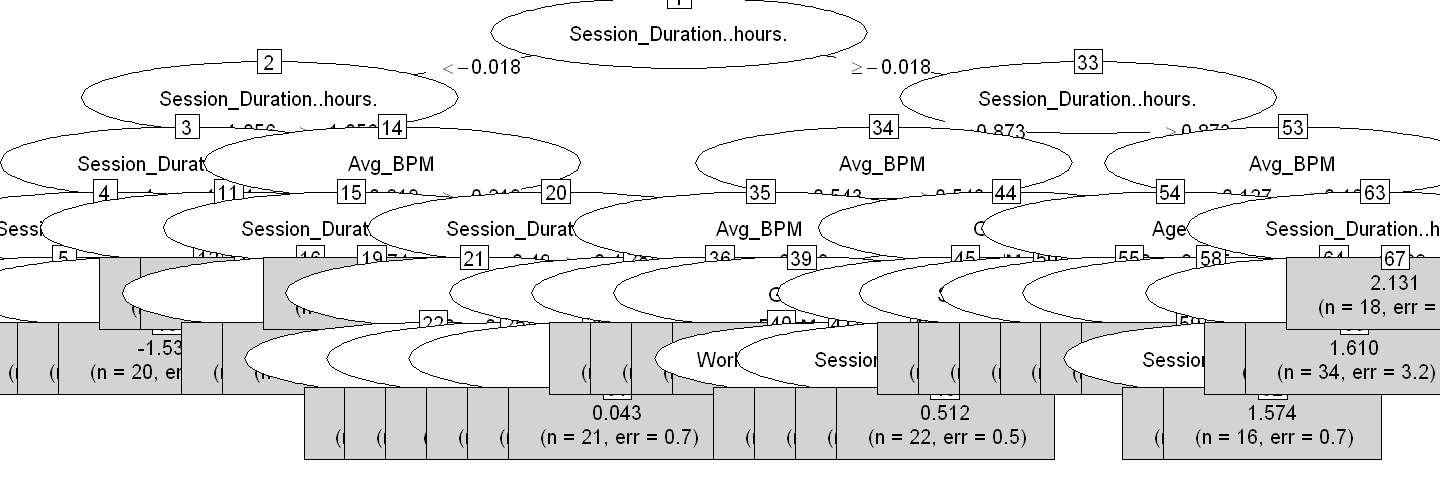

In [60]:
# On utilise la valeur de cp qui donne la plus petite erreur:

cp.opt = as.numeric(attributes(which.min(CVerr))$names)

cat("cp optimal :", cp.opt, "\n")
tree.reg=rpart(sCalories_Burned~.,data=datappr,control=rpart.control(cp=cp.opt))

# affichage plus clair avec partykit (l'arbre reste illisible mais vu la taille il est difficile de faire mieux)
plot(as.party(tree.reg), type="simple")

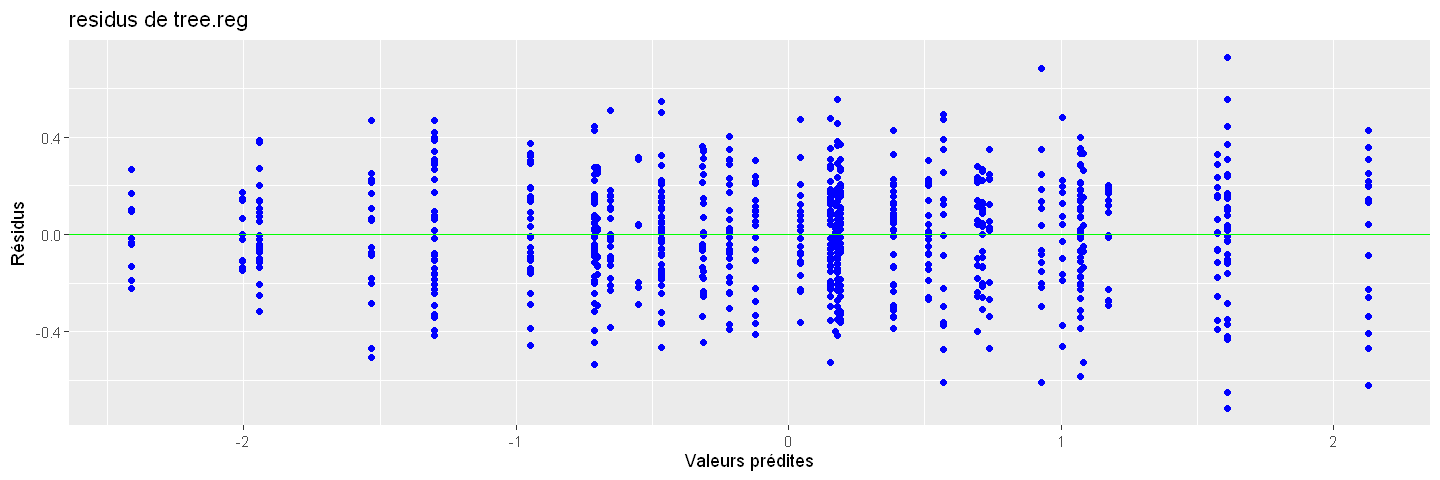

In [61]:
# On affiche les résidus de l'arbre, on retrouve la structure caractéristique des résidus de CART avec des lignes verticales qui correspondent aux différentes feuilles
fit.tree=predict(tree.reg)
res.tree=fit.tree-datappr[,"sCalories_Burned"]
gplot.res(fit.tree,res.tree,"residus de tree.reg")

### RMSE sur l'échantillon de test:

In [62]:
test_tree <- predict(tree.reg,newdata=datestr)

rmse_tree <- sqrt(mean((y_test - test_tree)^2))

cat("RMSE pour CART :", rmse_tree, "\n")

RMSE pour CART : 0.2941102 


Le résultat est mauvais en comparasion des méthodes précédentes, on va utiliser l'aggrégation de modèles pour améliorer ce résultat

## 2.1.5 Agrégation des modèles: 

## Random forest

In [63]:
#modèle random forest

rf.reg=randomForest(sCalories_Burned~., data=datappr,xtest=datestr[,-9],ytest=datestr[,"sCalories_Burned"],
   ntree=500,do.trace=50,importance=TRUE)

rf.reg$mtry

     |      Out-of-bag   |       Test set    |
Tree |      MSE  %Var(y) |      MSE  %Var(y) |
  50 |  0.05941     5.95 |  0.04437     4.46 |
 100 |   0.0515     5.16 |  0.04083     4.10 |
 150 |  0.04813     4.82 |  0.03976     4.00 |
 200 |  0.04715     4.72 |  0.03802     3.82 |
 250 |  0.04695     4.70 |    0.038     3.82 |
 300 |  0.04743     4.75 |  0.03857     3.88 |
 350 |  0.04741     4.75 |  0.03927     3.95 |
 400 |  0.04659     4.67 |  0.03941     3.96 |
 450 |  0.04696     4.70 |  0.03969     3.99 |
 500 |   0.0468     4.69 |  0.03928     3.95 |


[1] 4

Meilleur mtry : 11 


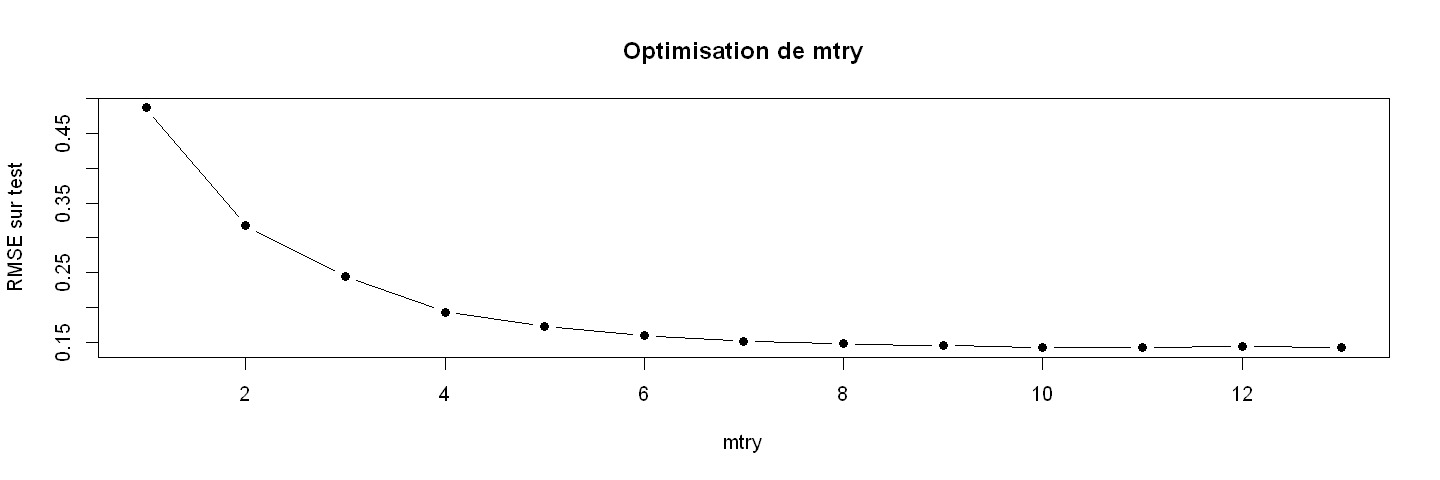

In [ ]:
# Optimisation de mtry (nombre de variables pour le split)

p <- ncol(datappr) - 1
mtry.values <- 1:p
rmse.values <- numeric(length(mtry.values))

x_test <- datestr[,-9]

for (i in seq_along(mtry.values)) {
  rf.temp <- randomForest(
    sCalories_Burned ~ ., data = datappr,
    mtry = mtry.values[i], ntree = 500
  )
  
  preds <- predict(rf.temp, newdata = x_test)
  rmse.values[i] <- sqrt(mean((y_test - preds)^2))
}

plot(mtry.values, rmse.values, type = "b", pch = 19,
     xlab = "mtry", ylab = "RMSE sur test", main = "Optimisation de mtry")

best.mtry <- mtry.values[which.min(rmse.values)]
cat("Meilleur mtry :", best.mtry, "\n")

In [65]:
rf.reg.opt=randomForest(sCalories_Burned~., data=datappr,xtest=datestr[,-9],ytest=datestr[,"sCalories_Burned"],
   ntree=500,do.trace=50,importance=TRUE,mtry=12)

     |      Out-of-bag   |       Test set    |
Tree |      MSE  %Var(y) |      MSE  %Var(y) |
  50 |   0.0265     2.65 |  0.02205     2.22 |
 100 |   0.0247     2.47 |  0.02127     2.14 |
 150 |  0.02403     2.41 |  0.02036     2.05 |
 200 |   0.0237     2.37 |  0.02028     2.04 |
 250 |  0.02357     2.36 |  0.02054     2.06 |
 300 |  0.02342     2.34 |   0.0204     2.05 |
 350 |  0.02345     2.35 |  0.02039     2.05 |
 400 |  0.02325     2.33 |  0.02032     2.04 |
 450 |  0.02319     2.32 |   0.0204     2.05 |
 500 |  0.02297     2.30 |  0.02033     2.04 |


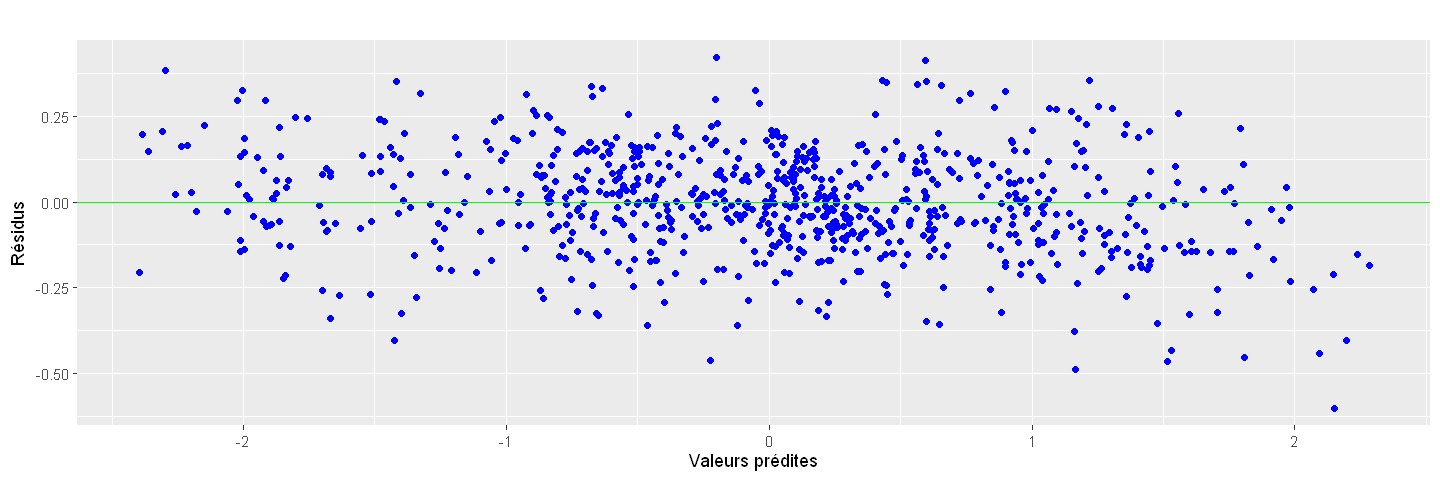

In [67]:
#Affichage des résidus

fit.rfr=rf.reg.opt$predicted
res.rfr=fit.rfr-y
gplot.res(fit.rfr,res.rfr,titre="")

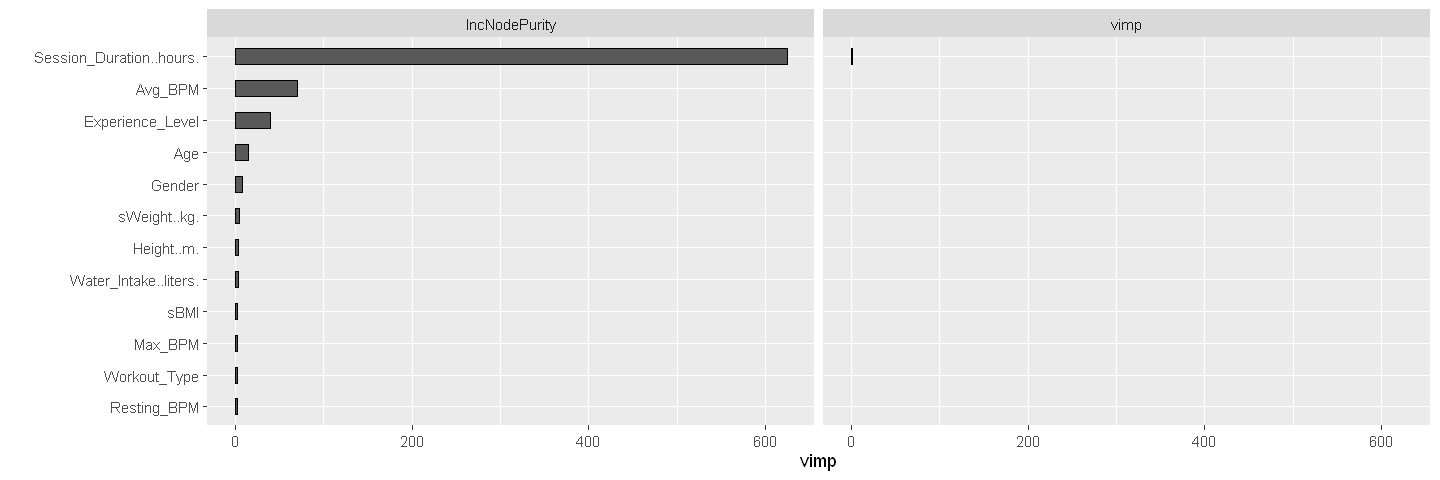

In [68]:
# Importance des variables
plot(gg_vimp(rf.reg.opt))

### RMSE sur l'échantillon de test:

In [69]:
test_forest <- rf.reg.opt$test$predicted

rmse_forest <- sqrt(mean((y_test - test_forest)^2))

cat("RMSE pour random forest :", rmse_forest, "\n")

RMSE pour random forest : 0.1425679 


Le résultat est bien meilleur qu'avec un arbre seul

## Boosting

In [70]:
# On optimise le paramètre de shrinkage et le nombre d'arbres:

shrinkages <- c(0.1, 0.05, 0.03, 0.01)
n.trees.max <- 1000
cv.folds <- 10

results <- data.frame(
  shrinkage = numeric(),
  best.iter = integer(),
  rmse = numeric()
)

for (s in shrinkages) {
  
  boost.model <- gbm( sCalories_Burned ~ ., data = datappr, distribution = "gaussian", n.trees = n.trees.max, shrinkage = s, cv.folds = cv.folds, verbose = FALSE)
  
  best.iter <- gbm.perf(boost.model, method = "cv", plot.it = FALSE)
  
  pred <- predict(boost.model, newdata = datestr, n.trees = best.iter)
  
  rmse <- sqrt(mean((datestr$sCalories_Burned - pred)^2))
  
  results <- rbind(results, data.frame(shrinkage = s, best.iter = best.iter, rmse = rmse))
}

print(results)

meilleur <- results[which.min(results$rmse), ]

boost.reg <- gbm( sCalories_Burned ~ ., data = datappr, distribution = "gaussian",  n.trees = meilleur$best.iter, shrinkage = meilleur$shrinkage, cv.folds = cv.folds, verbose = FALSE)

  shrinkage best.iter       rmse
1      0.10       990 0.09609925
2      0.05       999 0.09992831
3      0.03       998 0.09933188
4      0.01      1000 0.15365607


Les résultats de l'optimisation sont très versatiles. Selon l'execution les paramètres choisis ne sont pas les mêmes

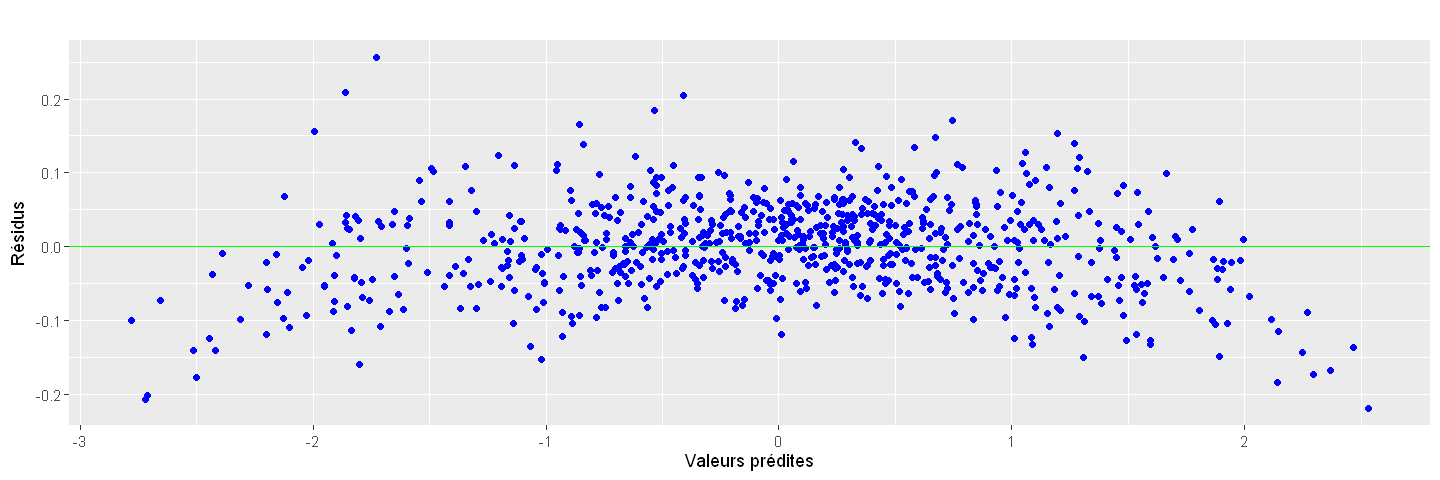

In [71]:
# Affichage des résidus
fit.boostr = predict(boost.reg, newdata = datappr, n.trees = meilleur$best.iter, shrinkage = meilleur$shrinkage)
res.boostr = fit.boostr - y

gplot.res(fit.boostr, res.boostr, titre = "")

### RMSE sur l'échantillon de test:

In [72]:
test_boost <- predict(boost.reg,newdata=datestr,n.trees = meilleur$best.iter, shrinkage = meilleur$shrinkage)
rmse_boost <- sqrt(mean((y_test - test_boost)^2))

cat("RMSE pour boosting :", rmse_boost, "\n")

RMSE pour boosting : 0.1028846 


## 2.1.6 Réseaux de Neurones

Avec nnet le nombre de couches cachées supportées est seulement 1. On optimise les paramètres size, decay qui correspondent respectivement au nombre de neurones dans l'unique couche cachée et à la pénalisation L2.

  size decay
4    5     1


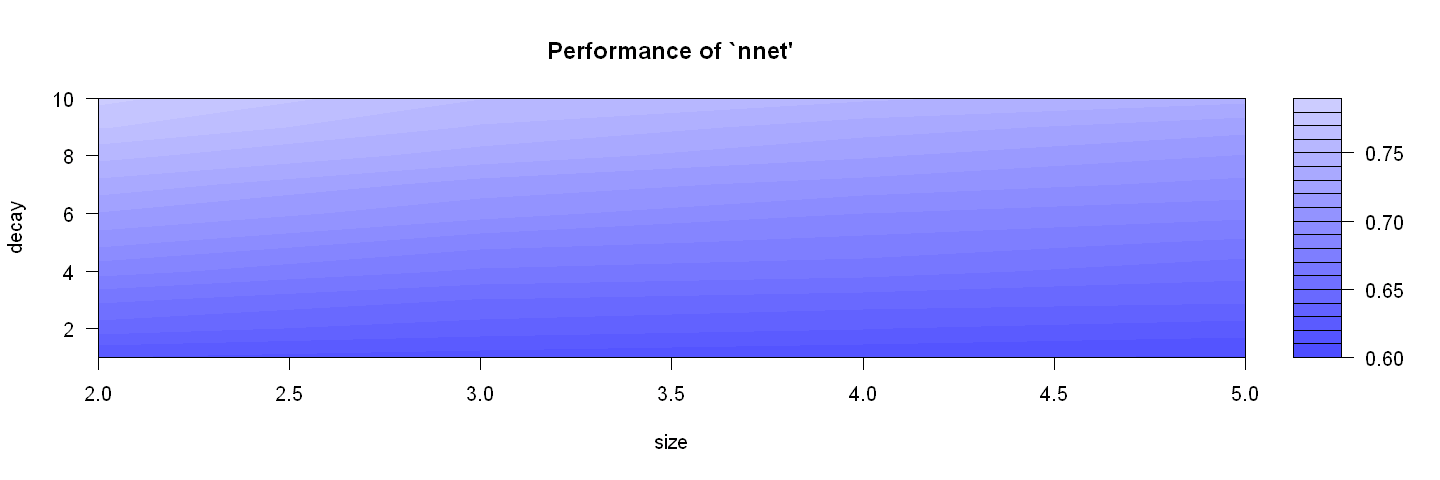

In [73]:
tune.result <- tune.nnet(sCalories_Burned~.,data=datappr,size=2:5,decay=1:10)

plot(tune.result)

best.params <- tune.result$best.parameters
print(best.params)

In [74]:
nnet.reg=nnet(sCalories_Burned~.,data=datappr,size=5,decay=1,linout=TRUE,maxit=500) 
summary(nnet.reg)

# weights:  101
initial  value 887.232814 
iter  10 value 85.611540
iter  20 value 55.100352
iter  30 value 40.395489
iter  40 value 32.126637
iter  50 value 28.786581
iter  60 value 26.817557
iter  70 value 25.196153
iter  80 value 24.327986
iter  90 value 23.199363
iter 100 value 22.754342
iter 110 value 22.512058
iter 120 value 22.315986
iter 130 value 22.200509
iter 140 value 22.068629
iter 150 value 21.968807
iter 160 value 21.907968
iter 170 value 21.889723
iter 180 value 21.881830
iter 190 value 21.878502
iter 200 value 21.877265
iter 210 value 21.877105
iter 220 value 21.877051
iter 230 value 21.877009
final  value 21.877003 
converged


a 18-5-1 network with 101 weights
options were - linear output units  decay=1
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
   0.38    0.20   -0.24   -0.03   -0.07    0.05   -0.38   -0.09   -0.53    0.11 
i10->h1 i11->h1 i12->h1 i13->h1 i14->h1 i15->h1 i16->h1 i17->h1 i18->h1 
   0.04    0.06   -0.18    0.17    0.09    0.03    0.19    0.06   -0.06 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
  -0.14   -0.17    0.19    0.01    0.03    0.01    0.32    0.01    0.55   -0.06 
i10->h2 i11->h2 i12->h2 i13->h2 i14->h2 i15->h2 i16->h2 i17->h2 i18->h2 
   0.00   -0.03    0.02   -0.02   -0.05   -0.01   -0.03   -0.04    0.04 
  b->h3  i1->h3  i2->h3  i3->h3  i4->h3  i5->h3  i6->h3  i7->h3  i8->h3  i9->h3 
  -0.05   -0.15    0.16   -0.06   -0.01    0.07    0.41   -0.06    0.63   -0.03 
i10->h3 i11->h3 i12->h3 i13->h3 i14->h3 i15->h3 i16->h3 i17->h3 i18->h3 
   0.04   -0.06   -0.12    0.06   -0.03   -0.01    0.06   -0.05   -0.02

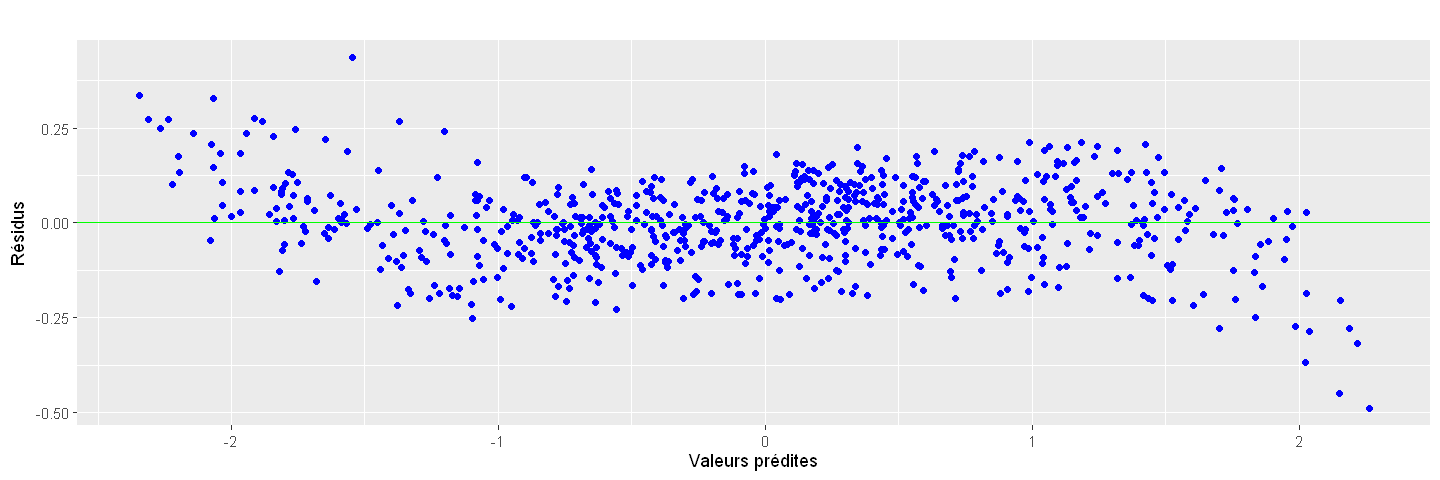

In [75]:
# Affichage des résidus
fit.nnetr=predict(nnet.reg,data=datappr)
res.nnetr=fit.nnetr-datappr[,"sCalories_Burned"]
gplot.res(fit.nnetr,res.nnetr,titre="")

### RMSE sur l'échantillon de test:

In [77]:
test_nnet <- predict(nnet.reg,newdata=datestr)

rmse_nnet <- sqrt(mean((y_test - test_nnet)^2))

cat("RMSE pour nnet :", rmse_nnet, "\n")

RMSE pour nnet : 0.1162174 


Les résultats sont un peu moins bons que pour le boosting

# 2.2 Prédiction du niveau d'entraînement (régression)

**WARNING : je crois qu'il y a des erreurs au niveau de la constrcution des dataset**

**Fonctions préalables**

Fonction qui calcule et affiche le pourcentage d'erreur 

In [39]:
pourcentage_erreur <- function(conf_matrix) {
  total_samples <- sum(conf_matrix)
  errors <- total_samples - sum(diag(conf_matrix))
  error_percentage <- (errors / total_samples) * 100
  print(paste("Pourcentage d'erreur :", round(error_percentage, 2), "%"))
}

Initialisation de la validation croisée avec 10 folds. Intervient dès que l'on utilise la fonction train du package *caret*.

In [41]:
param_train<-trainControl(method="cv",number=10)

Fonction pour tracer les courbes ROC

In [44]:
plot_roc_curves <- function(probabilities, model_name) {
  roc_curves <- list()
  colors <- brewer.pal(3, "Set2")

  # Calculer la courbe ROC pour chaque classe
  for (class in levels(data_test$Experience_Level)) {
    binary_labels <- as.numeric(data_test$Experience_Level == class)
    roc_curve <- roc(binary_labels, probabilities[, class], quiet = TRUE)
    roc_curves[[class]] <- roc_curve
  }

  # Tracer les courbes ROC
  plot(roc_curves[[levels(data_test$Experience_Level)[1]]], col = colors[1], lty = 1, lwd = 2, main = paste("Courbes ROC par", model_name))
  lines(roc_curves[[levels(data_test$Experience_Level)[2]]], col = colors[2], lty = 1, lwd = 2)
  lines(roc_curves[[levels(data_test$Experience_Level)[3]]], col = colors[3], lty = 1, lwd = 2)

  # Ajouter une légende
  legend("bottomright", legend = levels(data_test$Experience_Level), col = colors, lwd = 2)
    
}



# Fonction pour tracer les courbes ROC superposées

plot_superposed_roc_curves <- function(probabilities_1, model_name_1, probabilities_2, model_name_2) {
  roc_curves_1 <- list()
  roc_curves_2 <- list()
  colors_1 <- brewer.pal(3, "Set2")
  colors_2 <- brewer.pal(3, "Dark2") 

  # Calculer les courbes ROC pour chaque classe pour le premier modèle
  for (class in levels(data_test$Experience_Level)) {
    binary_labels <- as.numeric(data_test$Experience_Level == class)
    roc_curve <- roc(binary_labels, probabilities_1[, class], quiet = TRUE)
    roc_curves_1[[class]] <- roc_curve
  }

  # Calculer les courbes ROC pour chaque classe pour le second modèle
  for (class in levels(data_test$Experience_Level)) {
    binary_labels <- as.numeric(data_test$Experience_Level == class)
    roc_curve <- roc(binary_labels, probabilities_2[, class], quiet = TRUE)
    roc_curves_2[[class]] <- roc_curve
  }

  # Tracer les courbes ROC superposées
  plot(roc_curves_1[[levels(data_test$Experience_Level)[1]]], col = colors_1[1], lty = 1, lwd = 2, main = paste("Courbes ROC superposées (", model_name_1, " et ", model_name_2, ")", sep = ""))
  lines(roc_curves_1[[levels(data_test$Experience_Level)[2]]], col = colors_1[2], lty = 1, lwd = 2)
  lines(roc_curves_1[[levels(data_test$Experience_Level)[3]]], col = colors_1[3], lty = 1, lwd = 2)

  lines(roc_curves_2[[levels(data_test$Experience_Level)[1]]], col = colors_2[1], lty = 2, lwd = 2)
  lines(roc_curves_2[[levels(data_test$Experience_Level)[2]]], col = colors_2[2], lty = 2, lwd = 2)
  lines(roc_curves_2[[levels(data_test$Experience_Level)[3]]], col = colors_2[3], lty = 2, lwd = 2)

  # Ajouter une légende
  legend("bottomright", legend = c(paste(model_name_1, "-", levels(data_test$Experience_Level)), paste(model_name_2, "-", levels(data_test$Experience_Level))),
         col = c(colors_1, colors_2),
         lty = rep(c(1, 2), each = 3), lwd = 2)
}

**Découpage du dataset**

On découpe le dataset pour avoir un échantillon test et apprentissage

In [52]:
set.seed(1234) # initialisation du générateur

train_index <- createDataPartition(data$Experience_Level, p = 0.8, list = FALSE)

# Créer les datasets d’apprentissage et de test
data_exp <- data[train_index, ]
data_test <- data[-train_index, ]

# Créer les datasets d’apprentissage et de test
data_exp_norm <- data_norm[train_index, ]
data_test_norm <- data_norm[-train_index, ]

quanti_columns_bis <- c(1,3:9,11,12,15)

In [54]:
#On centre et réduit les données

data_exp_0 <- data_exp[, quanti_columns_bis]

data_exp[, quanti_columns_bis] <- scale(data_exp[, quanti_columns_bis],center = TRUE, scale = TRUE)
data_test[, quanti_columns_bis]=scale(data_test[, quanti_columns_bis], center=sapply(data_exp_0,mean), 
                            scale=sapply(data_exp_0,sd))

data_exp_0_norm <- data_exp_norm[, quanti_columns_bis]

data_exp_norm[, quanti_columns_bis] <- scale(data_exp_norm[, quanti_columns_bis],center = TRUE, scale = TRUE)
data_test_norm[, quanti_columns_bis]=scale(data_test_norm[, quanti_columns_bis], center=sapply(data_exp_0_norm,mean), 
                            scale=sapply(data_exp_0_norm,sd))

In [56]:
head(data)
head(data_exp)

,Age,Gender,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level,BMI
,<int>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
1,56,Male,88.3,1.71,180,157,60,1.69,1313,Yoga,12.6,3.5,4,3,30.20
2,46,Female,74.9,1.53,179,151,66,1.30,883,HIIT,33.9,2.1,4,2,32.00
3,32,Female,68.1,1.66,167,122,54,1.11,677,Cardio,33.4,2.3,4,2,24.71
4,25,Male,53.2,1.70,190,164,56,0.59,532,Strength,28.8,2.1,3,1,18.41
5,38,Male,46.1,1.79,188,158,68,0.64,556,Strength,29.2,2.8,3,1,14.39
6,56,Female,58.0,1.68,168,156,74,1.59,1116,HIIT,15.5,2.7,5,3,20.55


,Age,Gender,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level,BMI
,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
2,0.58677041,Female,0.05544904,-1.5050986225,-0.06617008,0.4802851,0.5262388,0.11582778,-0.09246517,HIIT,1.4155474,-0.8567881,4,2,1.04798136
3,-0.55678178,Female,-0.26542125,-0.4751551297,-1.10054779,-1.5271377,-1.1206579,-0.43523841,-0.84092700,Cardio,1.3357322,-0.5262097,4,2,-0.03631367
5,-0.06668799,Male,-1.30353101,0.5547883631,0.70961321,0.9648354,0.8007216,-1.79840214,-1.28055749,Strength,0.6652841,0.3002366,3,1,-1.57128277
6,1.40359340,Female,-0.74200800,-0.3167022846,-1.01434964,0.8263925,1.6241700,0.95692880,0.75409603,HIIT,-1.5216535,0.1349473,5,3,-0.65506091
7,-0.23005259,Male,-0.16161027,0.0002034054,-0.49716079,1.7262717,1.4869286,0.66689396,1.73145638,Cardio,-0.5957967,-0.5262097,3,2,-0.17761412
8,0.09667661,Female,-0.18992236,-1.6635514675,0.79581135,-0.2119297,0.2517560,0.02881733,-0.04886545,Cardio,0.8887668,-1.1873666,3,2,0.83528700


# 2.2.1 Régression multinomiale

On va réduire le nombre de coefficients par Lasso. Pour cela, on affiche lambda en fonction de la deviance

[1] "Best Lambda : 0.000831726272729487"
[1] "LSE Lambda : 0.00586766443073739"


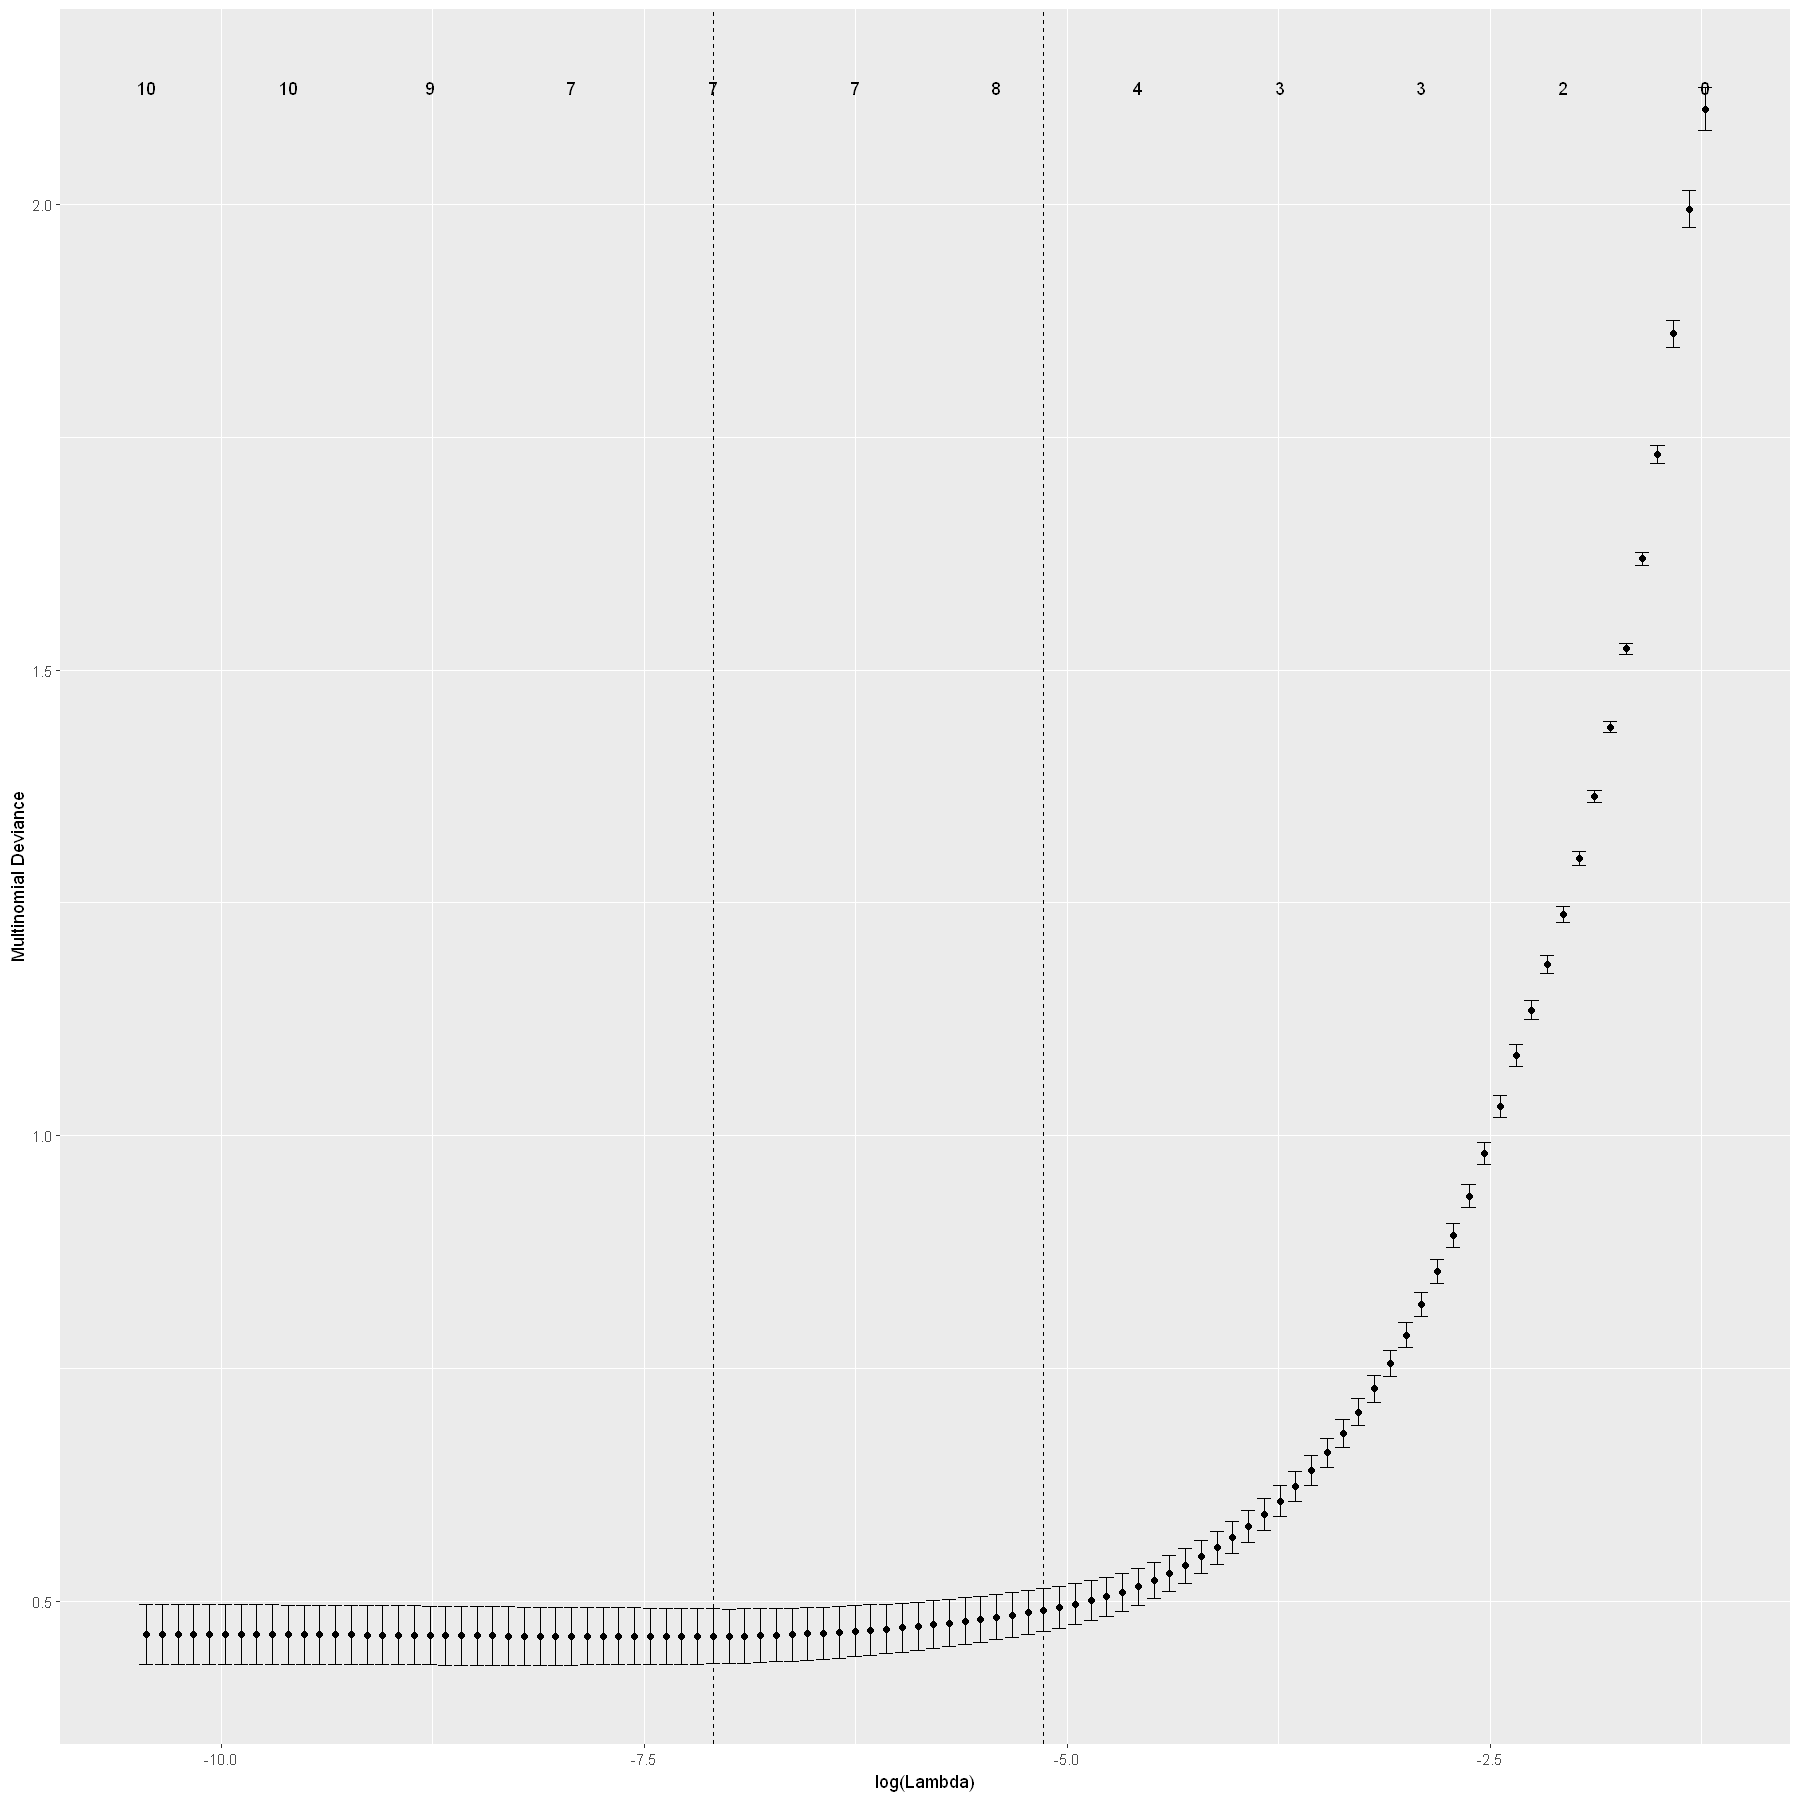

In [60]:
# Note : si ~ .^2 (on prend les interactions complètes) => erreur = 15% environ
# Pas un gain énorme. On ne regarde pas les interactions

# Convertir les données en matrice pour glmnet
x <- model.matrix(Experience_Level ~ ., data = data_exp_norm)[, -1]  # Prédicteurs 
y <- model.matrix(~ Experience_Level + 0, data = data_exp_norm)      # Réponse

# Ajustement du modèle avec validation croisée
cv_fit <- cv.glmnet(x, y, family = "multinomial", alpha = 1)
autoplot(cv_fit)

# Afficher le meilleur lambda
best_lambda <- cv_fit$lambda.min
print(paste("Best Lambda :", best_lambda))

#Affiche le plus grand lambda envisageable
lse_lambda <- cv_fit$lambda.1se
print(paste("LSE Lambda :", lse_lambda))

In [62]:
# Choix du lambda
chosen_lambda <- lse_lambda

# Ajuster le modèle final avec le meilleur lambda
final_model <- glmnet(x, y, family = "multinomial", alpha = 1, lambda = chosen_lambda)

# Afficher les coefficients du modèle final
print(coef(final_model))

$Experience_Level1
19 x 1 sparse Matrix of class "dgCMatrix"
                                         s0
                                2.919083428
Age                             0.035488780
GenderMale                      .          
sWeight..kg.                    .          
Height..m.                      0.025467291
Max_BPM                        -0.008191586
Avg_BPM                         .          
Resting_BPM                     .          
Session_Duration..hours.       -0.951149754
sCalories_Burned               -0.412482367
Workout_TypeHIIT                .          
Workout_TypeStrength            .          
Workout_TypeYoga                .          
BCFat_Percentage                .          
Water_Intake..liters.           .          
Workout_Frequency..days.week.3  .          
Workout_Frequency..days.week.4 -6.198609914
Workout_Frequency..days.week.5  .          
sBMI                            .          

$Experience_Level2
19 x 1 sparse Matrix of class "dgCMatri

In [64]:
#On va faire la matrice de confusion dans cette cellule.

x_test <- model.matrix(Experience_Level ~ ., data = data_test_norm)[, -1]  # Prédicteurs
y_test <- model.matrix(~ Experience_Level + 0, data = data_test_norm)  # Réponse réelle (one-hot)

# Prédiction des probabilités pour chaque classe
pred_probs <- predict(final_model, newx = x_test, type = "response")

# Modification nécessaires pour tracer les courbes ROC
probabilities_logit <- pred_probs[,,1]
probabilities_logit <- as.data.frame(probabilities_logit)
colnames(probabilities_logit) <- c("1", "2", "3")


# Convertir les probabilités en classes prédictes (classe avec proba max)
pred_class <- apply(pred_probs, 1, which.max)
# Convertir y_test en indices de classes réelles
true_class <- apply(y_test, 1, which.max)

# Construire la matrice de confusion
conf_matrix_logit <- table(Predicted = pred_class, Actual = true_class)
print(conf_matrix_logit)
pourcentage_erreur(conf_matrix_logit)

         Actual
Predicted  1  2  3
        1 66 21  0
        2  9 60  0
        3  0  0 38
[1] "Pourcentage d'erreur : 15.46 %"


# 2.2.2 Classification par analyse discriminante

**LDA**

In [74]:
#lda.fit<-train(Experience_Level ~ ., data = data_exp_norm, method="lda")

# erreur par validation croisée  en analyse discriminante linéaire
lda.fit <- train(Experience_Level ~ ., data = data_exp_norm, method="lda",trControl=param_train)

predictions_lda <-predict(lda.fit, data_test_norm[,-14])
probabilities_lda <-predict(lda.fit, data_test_norm[,-14], type="prob")

# estimer le taux d'erreur à partir de la matrice de confusion
conf_matrix_lda=table(data_test_norm[,"Experience_Level"],predictions_lda)
print(conf_matrix_lda)
pourcentage_erreur(conf_matrix_lda)

   predictions_lda
     1  2  3
  1 64 11  0
  2 15 66  0
  3  0  0 38
[1] "Pourcentage d'erreur : 13.4 %"


**kNN**

In [78]:
#Initialisation du générateur
set.seed(1234)

knn.fit<-train(Experience_Level ~ ., data = data_exp_norm ,method="knn")

# erreur par validation croisée  en kNN
knn.fit <- train(Experience_Level ~ ., data = data_exp_norm, method="knn",trControl=param_train,tuneLength=20)

predictions_knn <-predict(knn.fit, data_test_norm[,-14])
probabilities_knn <-predict(knn.fit, data_test_norm[,-14], type="prob")

# estimer le taux d'erreur à partir de la matrice de confusion
conf_matrix_knn=table(data_test_norm[,"Experience_Level"],predictions_knn)
print(conf_matrix_knn)
pourcentage_erreur(conf_matrix_knn)

   predictions_knn
     1  2  3
  1 41 33  1
  2 14 66  1
  3  0  0 38
[1] "Pourcentage d'erreur : 25.26 %"


**QDA** -> R n'apprécie pas, la matrice de covariance semble ne pas être de rang plein

**SVM kernel radial**

[1] 3
[1] 0.015


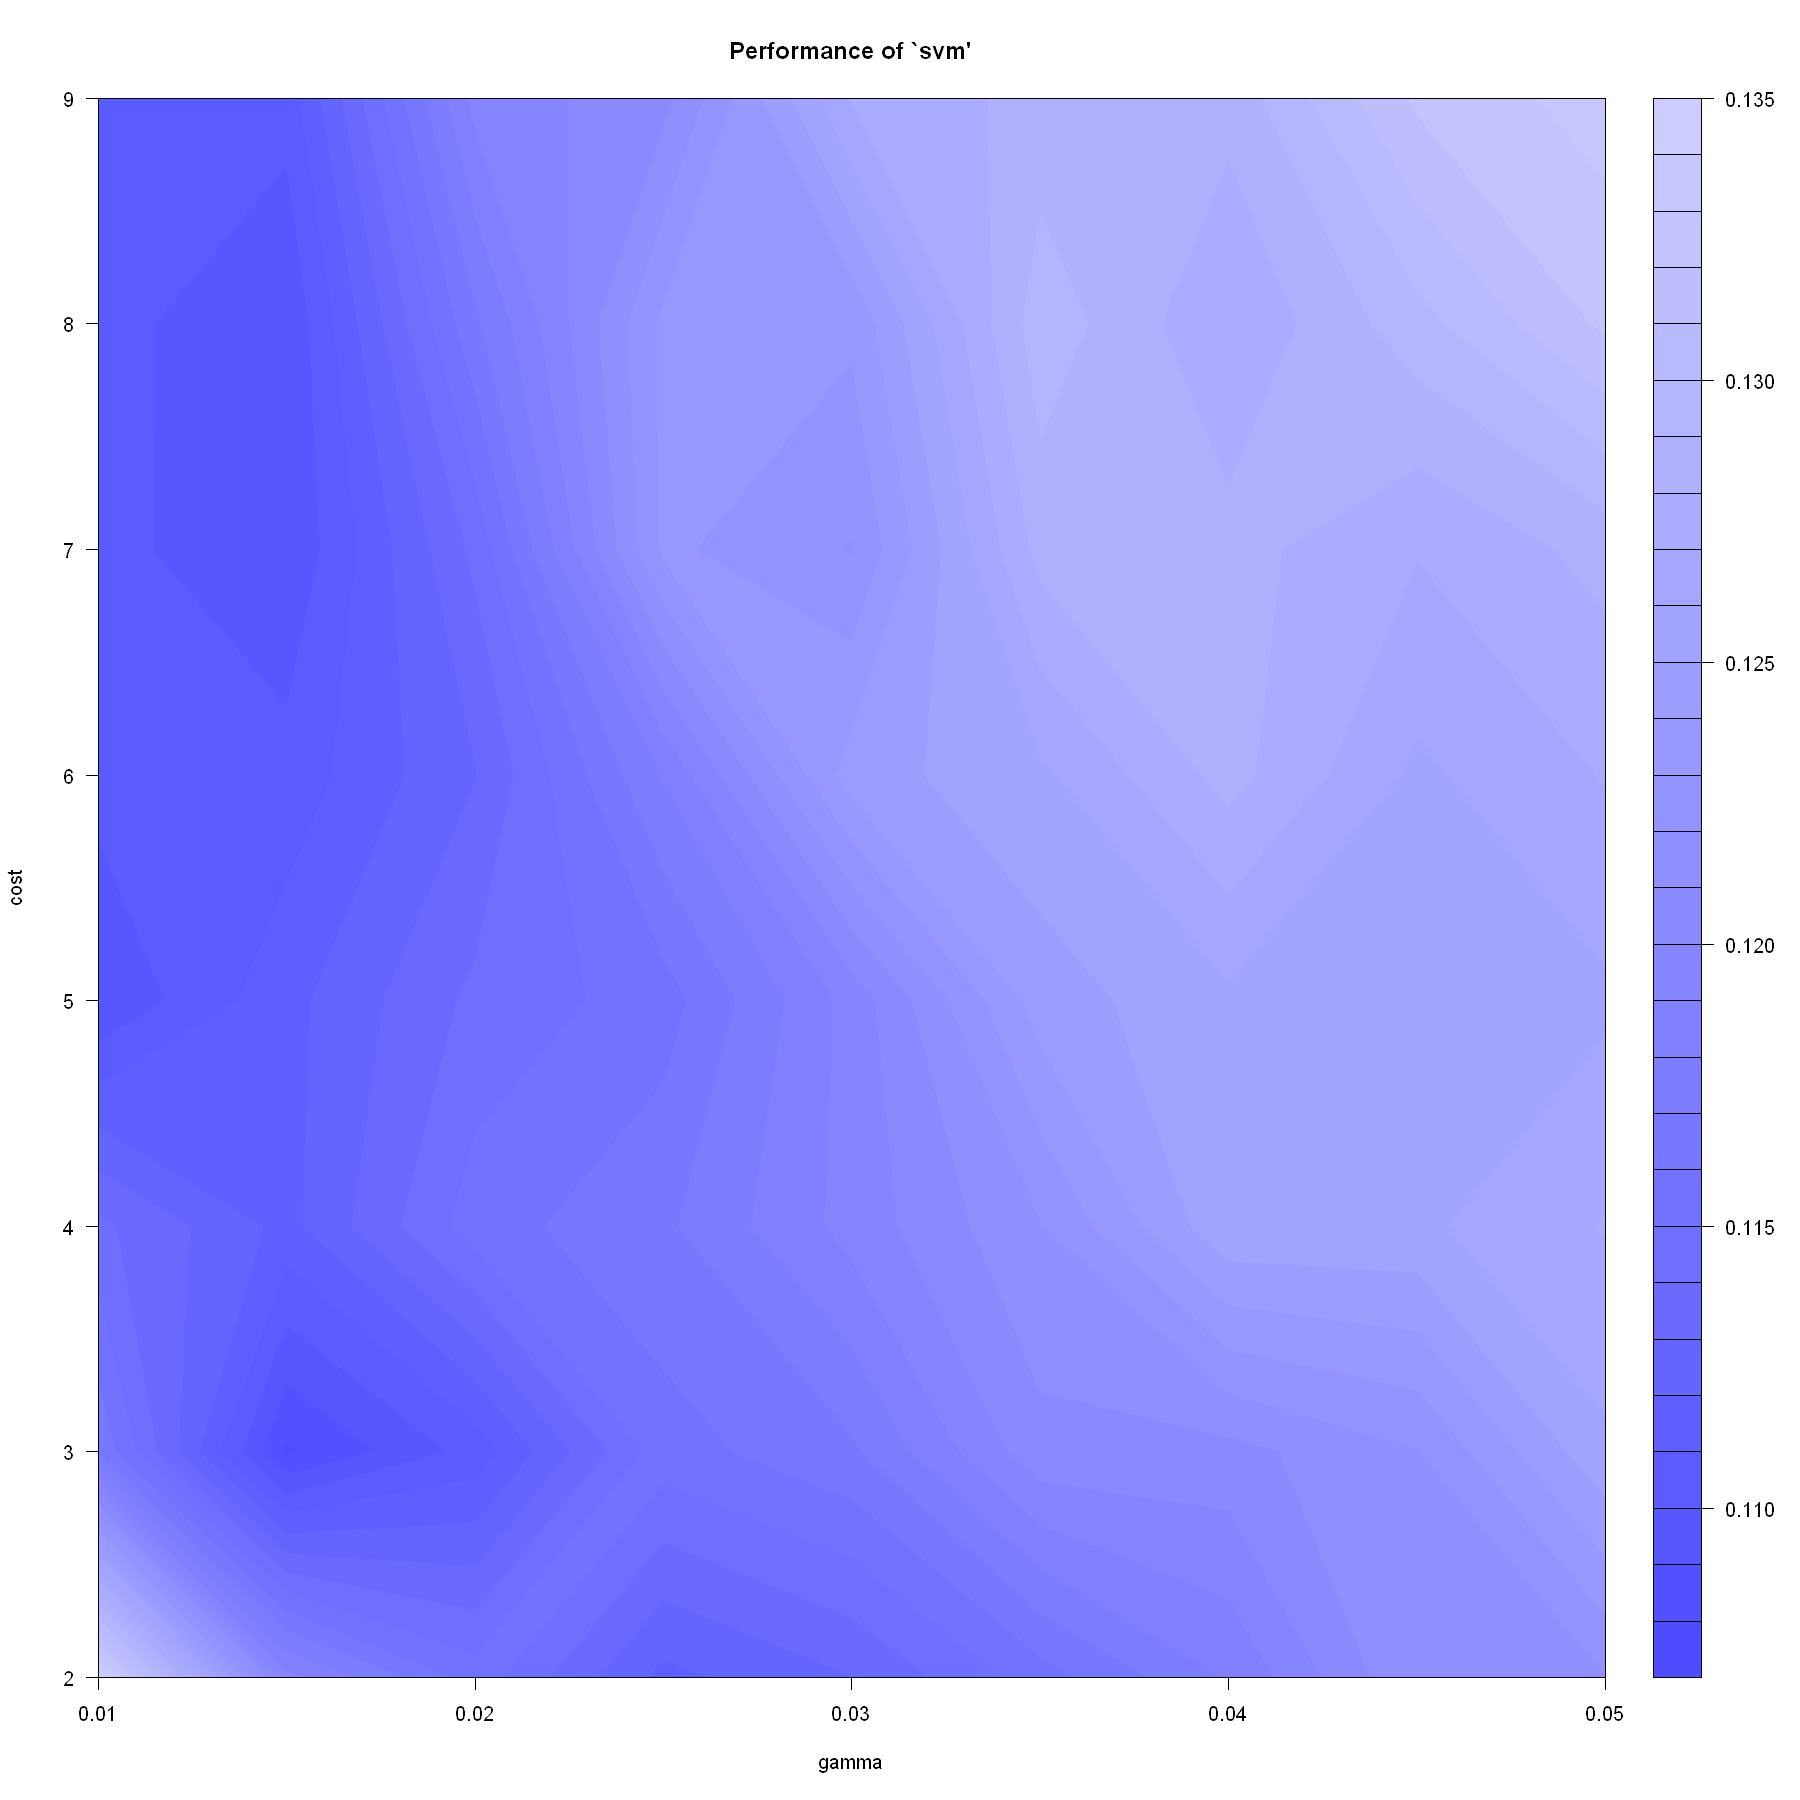

In [121]:
set.seed(1234)

#La zone de recherche est volontairement déjà centré sur les paramètres optimaux
#afin de ne pas avoir un run trop long
svm.rad.tune = tune.svm(Experience_Level ~ ., data = data_exp_norm, cost = c(2,3,4,5,6,7,8,9), 
    gamma = seq(0.01, 0.05, by = 0.005), kernel= "radial")
plot(svm.rad.tune)
print(svm.rad.tune$best.parameters$cost)
print(svm.rad.tune$best.parameters$gamma)

In [124]:
set.seed(1234)

svm.rad = svm(Experience_Level ~ ., data = data_exp_norm, 
              cost = svm.rad.tune$best.parameters$cost, 
              gamma = svm.rad.tune$best.parameters$gamma,
              probability=TRUE)

pred.svm.rad=predict(svm.rad,newdata=data_test_norm[,-14],probability=TRUE)

#Utiles pour les courbes ROC :
probabilities_svm.rad <- attr(pred.svm.rad, "probabilities")
probabilities_svm.rad <- as.data.frame(probabilities_svm.rad)

conf_matrix_svm.rad=table(data_test[,"Experience_Level"],pred.svm.rad)
print(conf_matrix_svm.rad)
pourcentage_erreur(conf_matrix_svm.rad)

   pred.svm.rad
     1  2  3
  1 62 13  0
  2 16 65  0
  3  0  0 38
[1] "Pourcentage d'erreur : 14.95 %"


**SVM Kernel Polynomial**

[1] 2
[1] 0.1


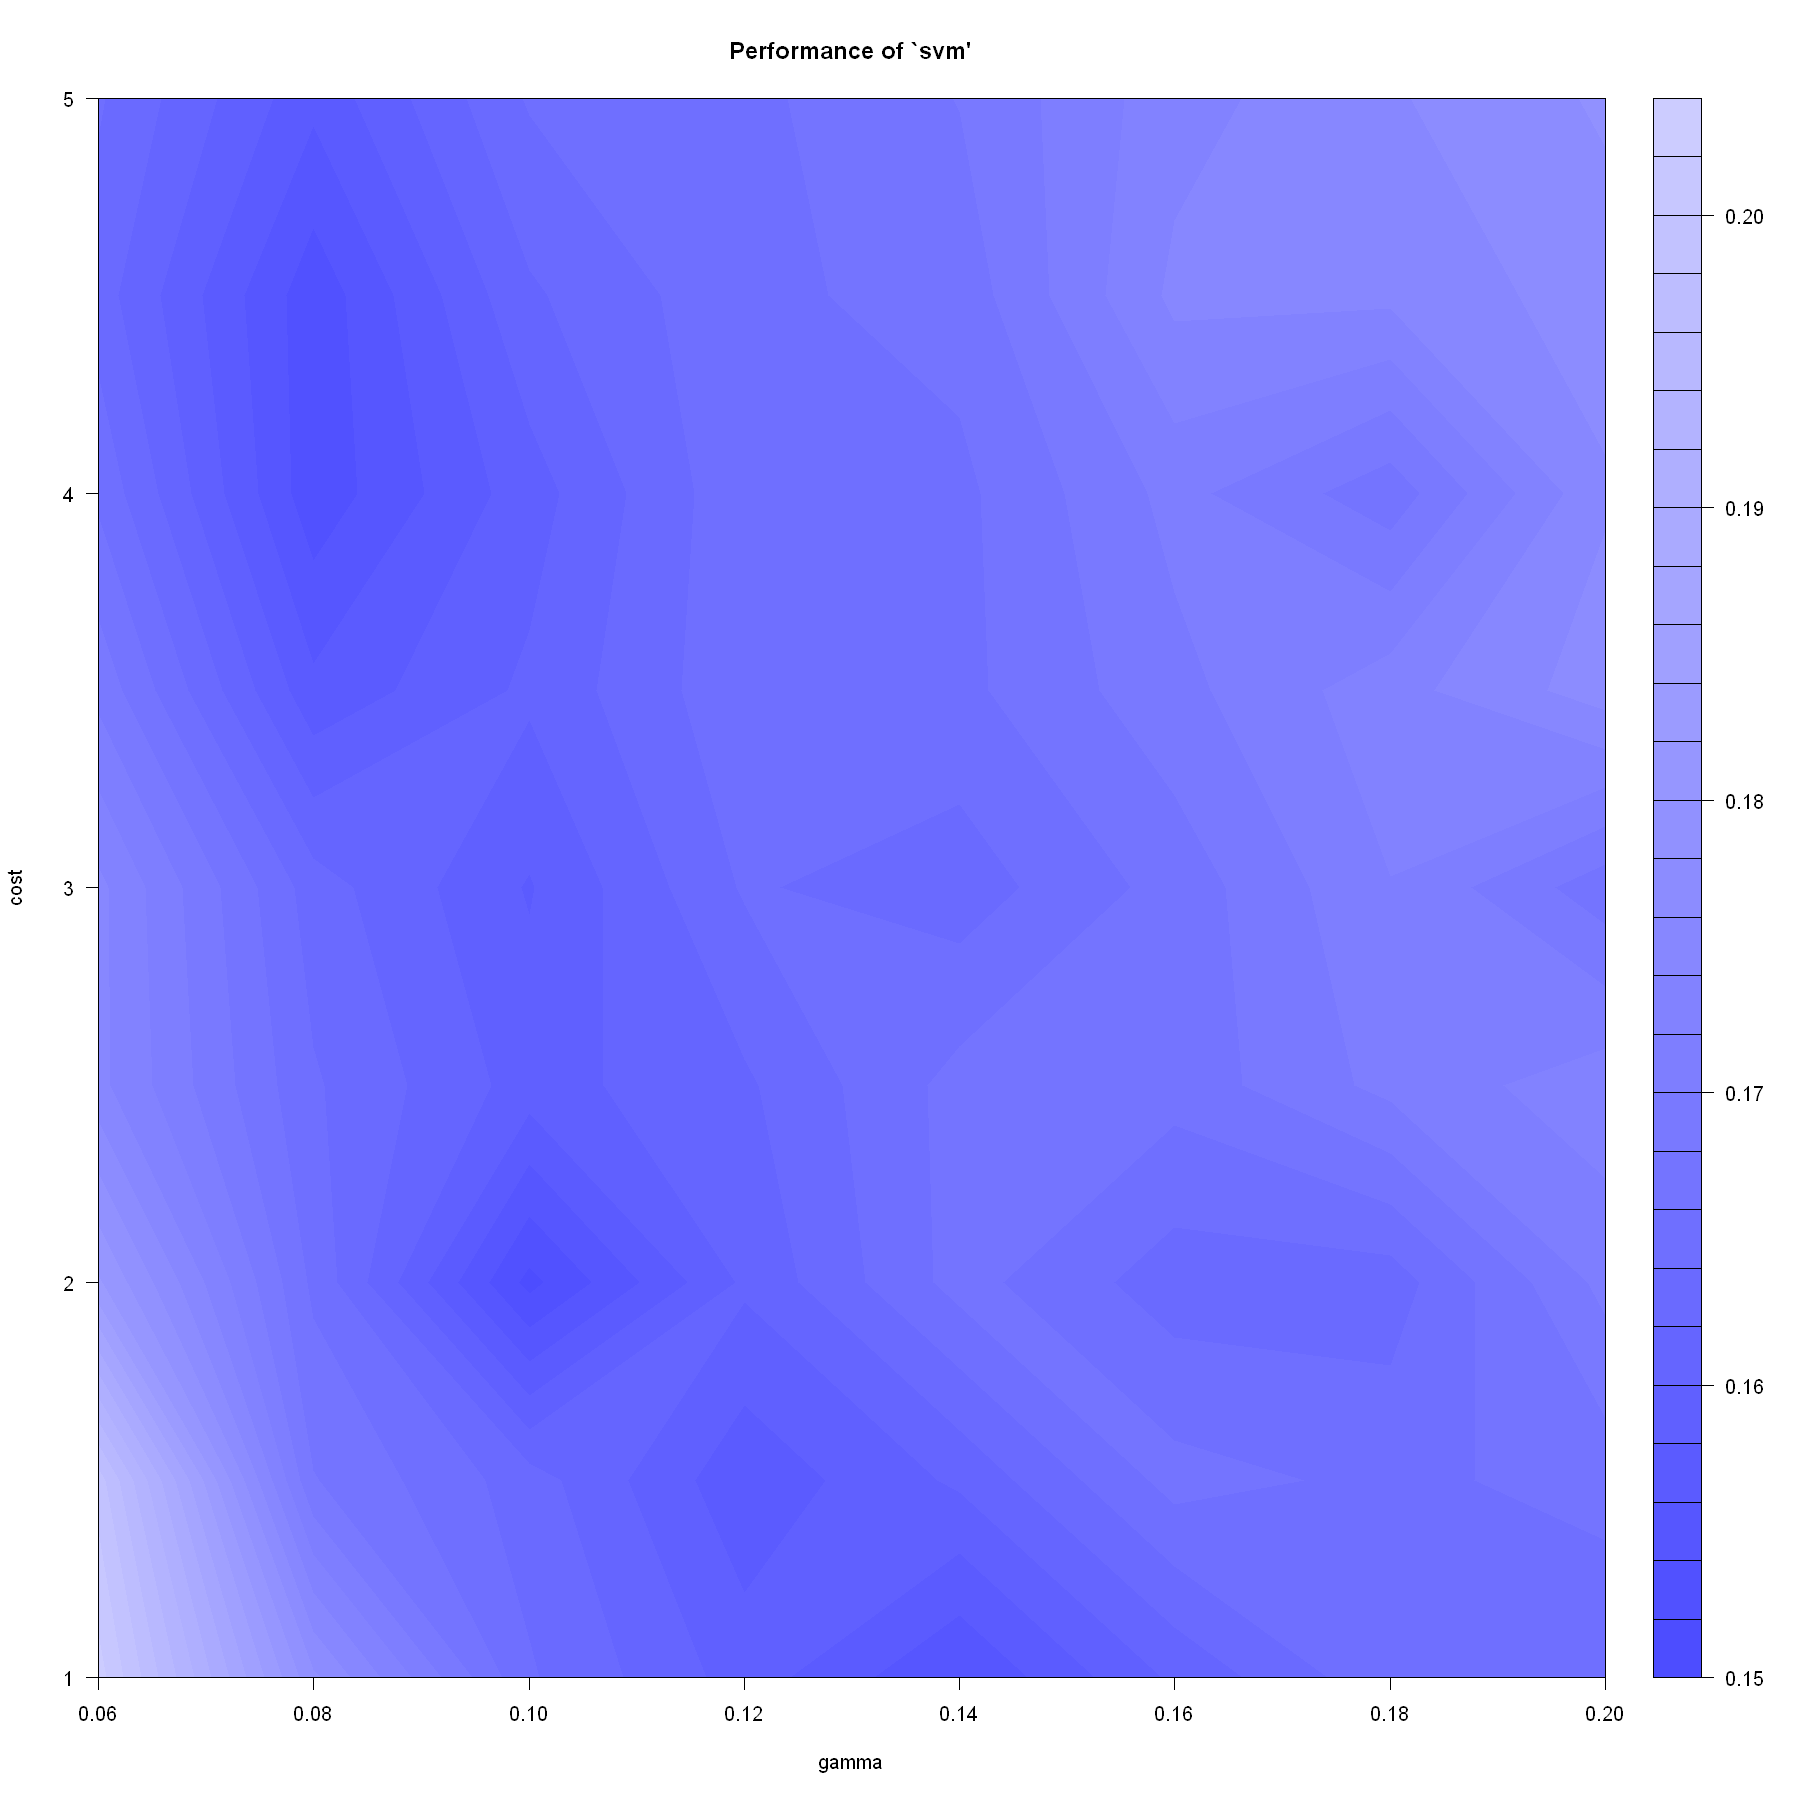

In [132]:
set.seed(1234)

# On prend les valeurs par défaut pour coef0 et degree
# coef0 = 0, degree= 3

svm.pol.tune = tune.svm(Experience_Level ~ ., data = data_exp_norm, kernel= "polynomial", cost = c(1,1.5,2,2.5,3,3.5,4,4.5,5), 
    gamma = seq(0.06, 0.2, by = 0.02)) 

plot(svm.pol.tune)
print(svm.pol.tune$best.parameters$cost)
print(svm.pol.tune$best.parameters$gamma)

In [134]:
svm.pol = svm(Experience_Level ~ ., data = data_exp_norm, kernel= "polynomial",
              cost = svm.pol.tune$best.parameters$cost, 
              gamma = svm.pol.tune$best.parameters$gamma,
              probability=TRUE)

pred.svm.pol=predict(svm.pol,newdata=data_test_norm[,-14],probability=TRUE)

#Utiles pour les courbes ROC :
probabilities_svm.pol <- attr(pred.svm.pol, "probabilities")
probabilities_svm.pol <- as.data.frame(probabilities_svm.pol)

conf_matrix_svm.pol=table(data_test_norm[,"Experience_Level"],pred.svm.pol)
print(conf_matrix_svm.pol)
pourcentage_erreur(conf_matrix_svm.pol)

   pred.svm.pol
     1  2  3
  1 61 14  0
  2 19 62  0
  3  0  0 38
[1] "Pourcentage d'erreur : 17.01 %"


# 2.2.3 Arbres et forêts aléatoires

**Abres binaires de décision**

[1] "Valeur de cp retenue = 0.0714120102017158"


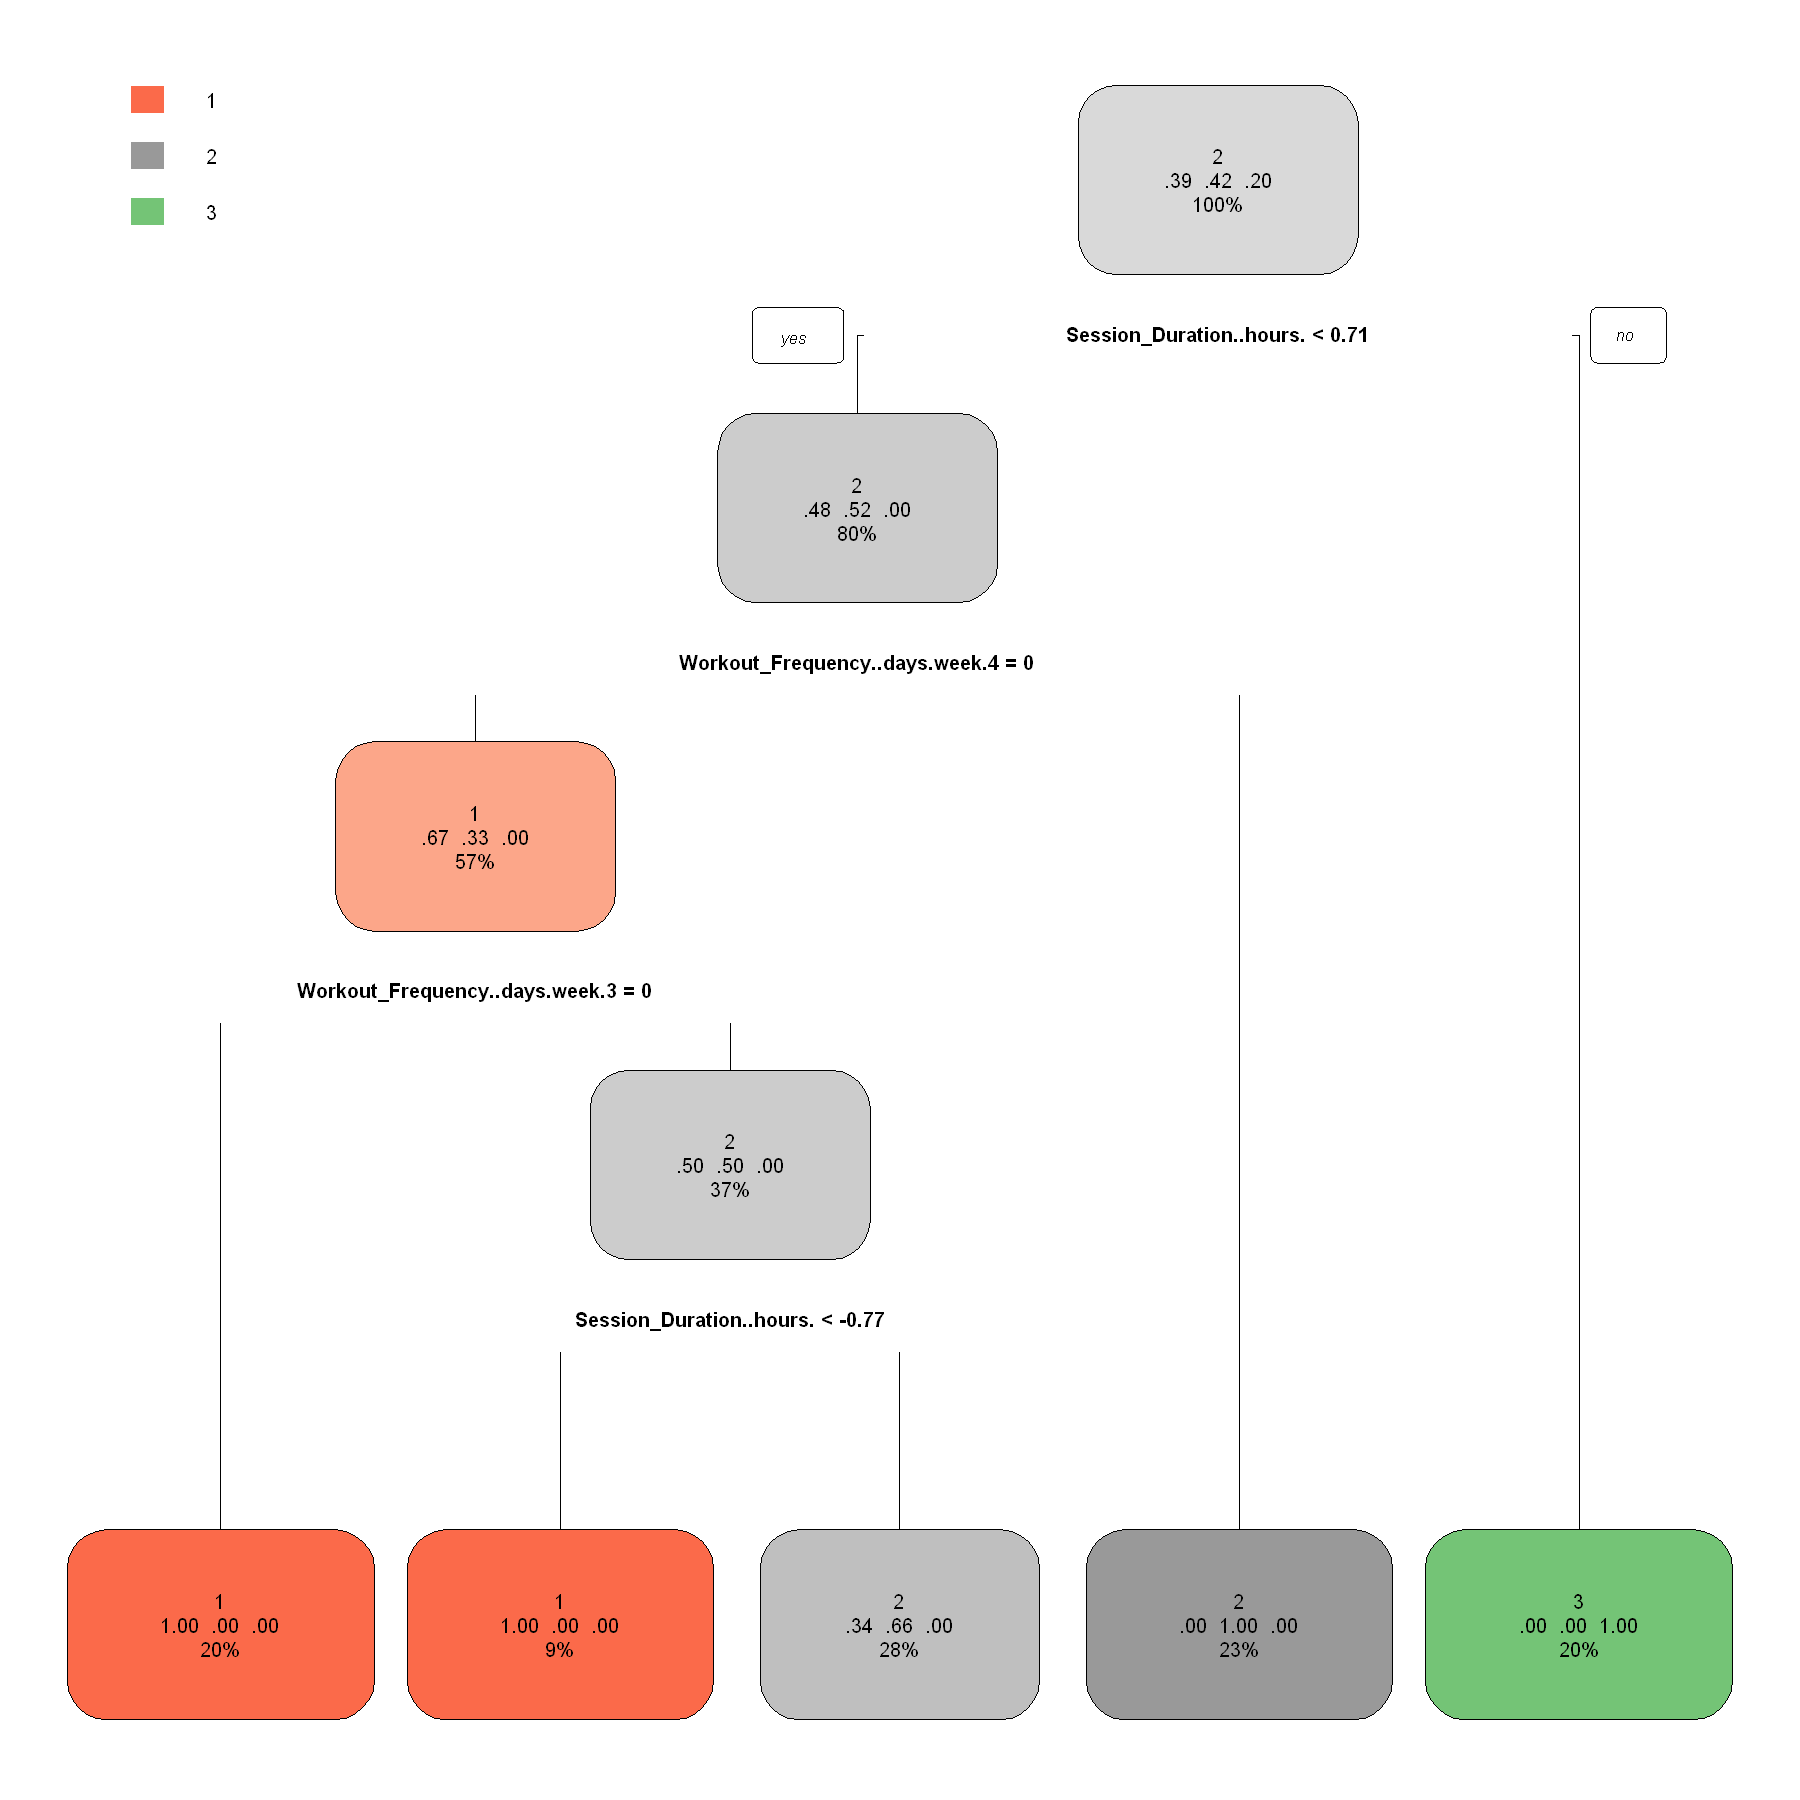

In [152]:
set.seed(1234)

tree.fit <- train(Experience_Level~.,data=data_exp ,method = "rpart", trControl = param_train , tuneLength =20, metric="Accuracy")
print(paste("Valeur de cp retenue = ", tree.fit$bestTune, sep=""))
rpart.plot(tree.fit$finalModel)

In [154]:
predictions_tree <-predict(tree.fit, data_test[,-14])
probabilities_tree <-predict(tree.fit, data_test[,-14], type="prob")

# estimer le taux d'erreur à partir de la matrice de confusion
conf_matrix_tree=table(data_test[,"Experience_Level"],predictions_tree)
print(conf_matrix_tree)
pourcentage_erreur(conf_matrix_tree)

   predictions_tree
     1  2  3
  1 56 19  0
  2  0 81  0
  3  0  0 38
[1] "Pourcentage d'erreur : 9.79 %"


**Forêts aléatoires**

In [160]:
set.seed(1234)

rf.dis=randomForest(Experience_Level~., data=data_exp, xtest=data_test[,-14], ytest=data_test[,
   "Experience_Level"] ,ntree=500, do.trace=50, importance=TRUE)

#rf.dis$importance

ntree      OOB      1      2      3|    Test      1      2      3
   50:  13.61% 21.93% 12.31%  0.00%|  11.34% 24.00%  4.94%  0.00%
  100:  12.84% 22.26% 10.15%  0.00%|  11.34% 22.67%  6.17%  0.00%
  150:  12.58% 23.26%  8.62%  0.00%|  10.82% 22.67%  4.94%  0.00%
  200:  11.30% 22.59%  6.15%  0.00%|  10.82% 22.67%  4.94%  0.00%
  250:  11.30% 23.26%  5.54%  0.00%|  10.82% 22.67%  4.94%  0.00%
  300:  11.04% 23.26%  4.92%  0.00%|  10.82% 22.67%  4.94%  0.00%
  350:  11.55% 23.59%  5.85%  0.00%|  10.31% 22.67%  3.70%  0.00%
  400:  11.42% 23.59%  5.54%  0.00%|   9.79% 21.33%  3.70%  0.00%
  450:  10.91% 23.59%  4.31%  0.00%|   9.79% 21.33%  3.70%  0.00%
  500:  10.65% 23.92%  3.38%  0.00%|  10.82% 24.00%  3.70%  0.00%


In [162]:
pred.rfq=rf.dis$test$predicted

probabilities_rfq = as.data.frame(rf.dis$test$votes)

confusion_matrix = table(pred.rfq,data_test[,"Experience_Level"])
print(confusion_matrix)
pourcentage_erreur(confusion_matrix)

        
pred.rfq  1  2  3
       1 57  3  0
       2 18 78  0
       3  0  0 38
[1] "Pourcentage d'erreur : 10.82 %"


**Boosting**

Warning message:
"Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk."


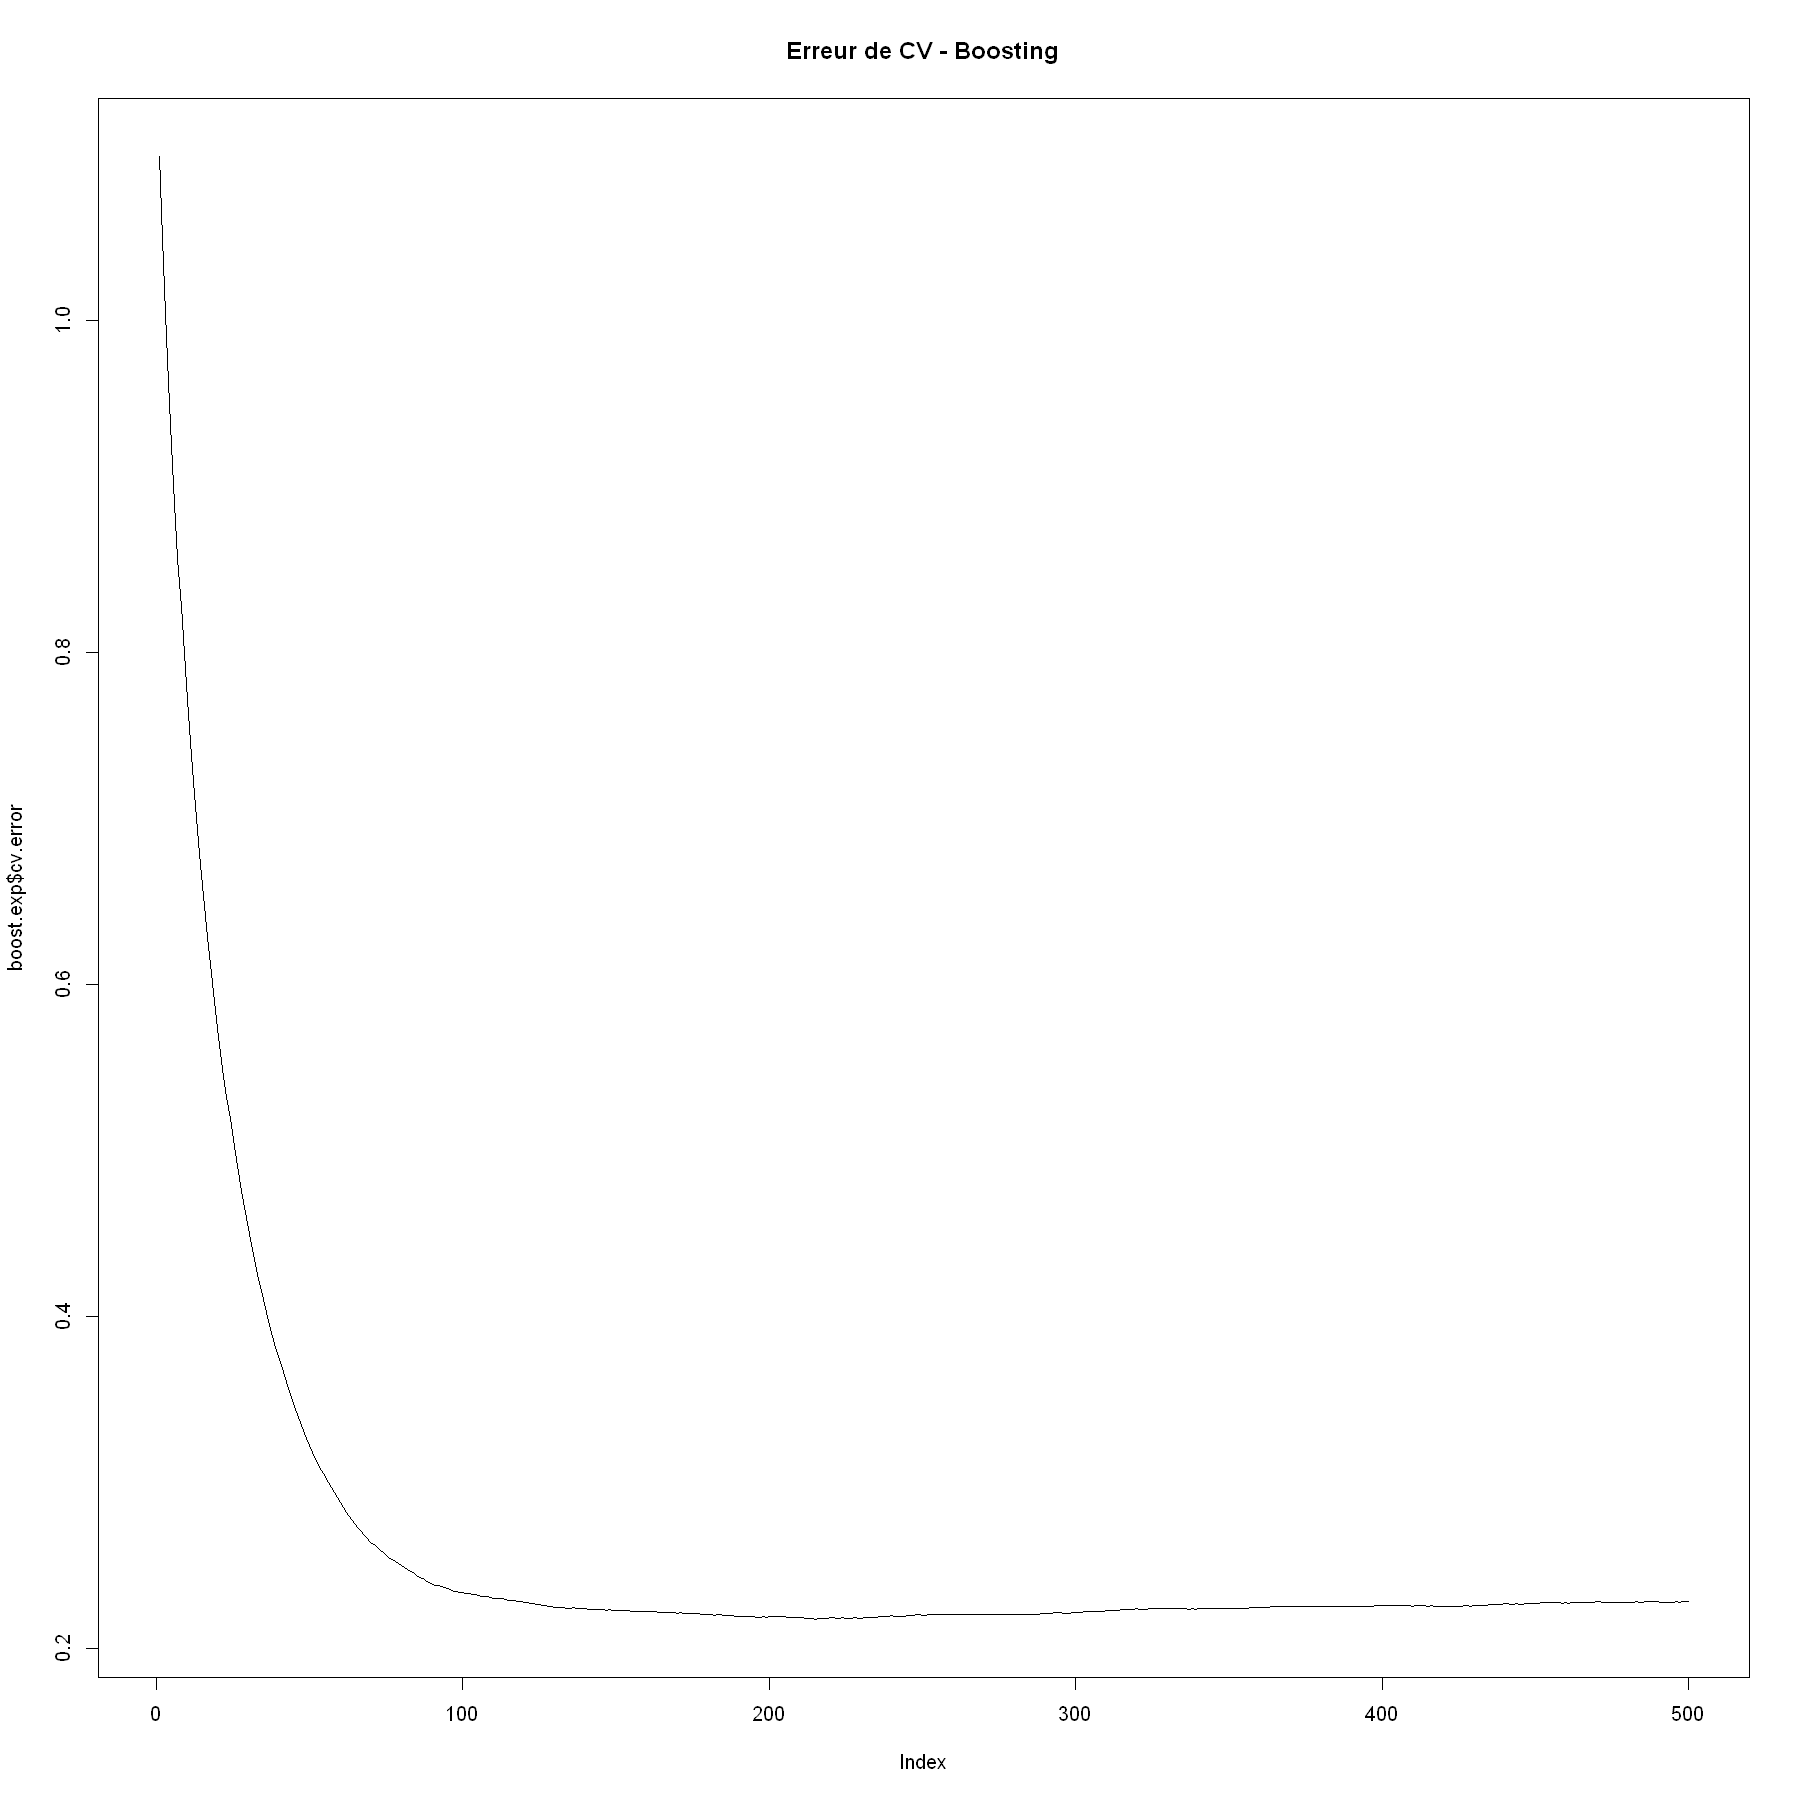

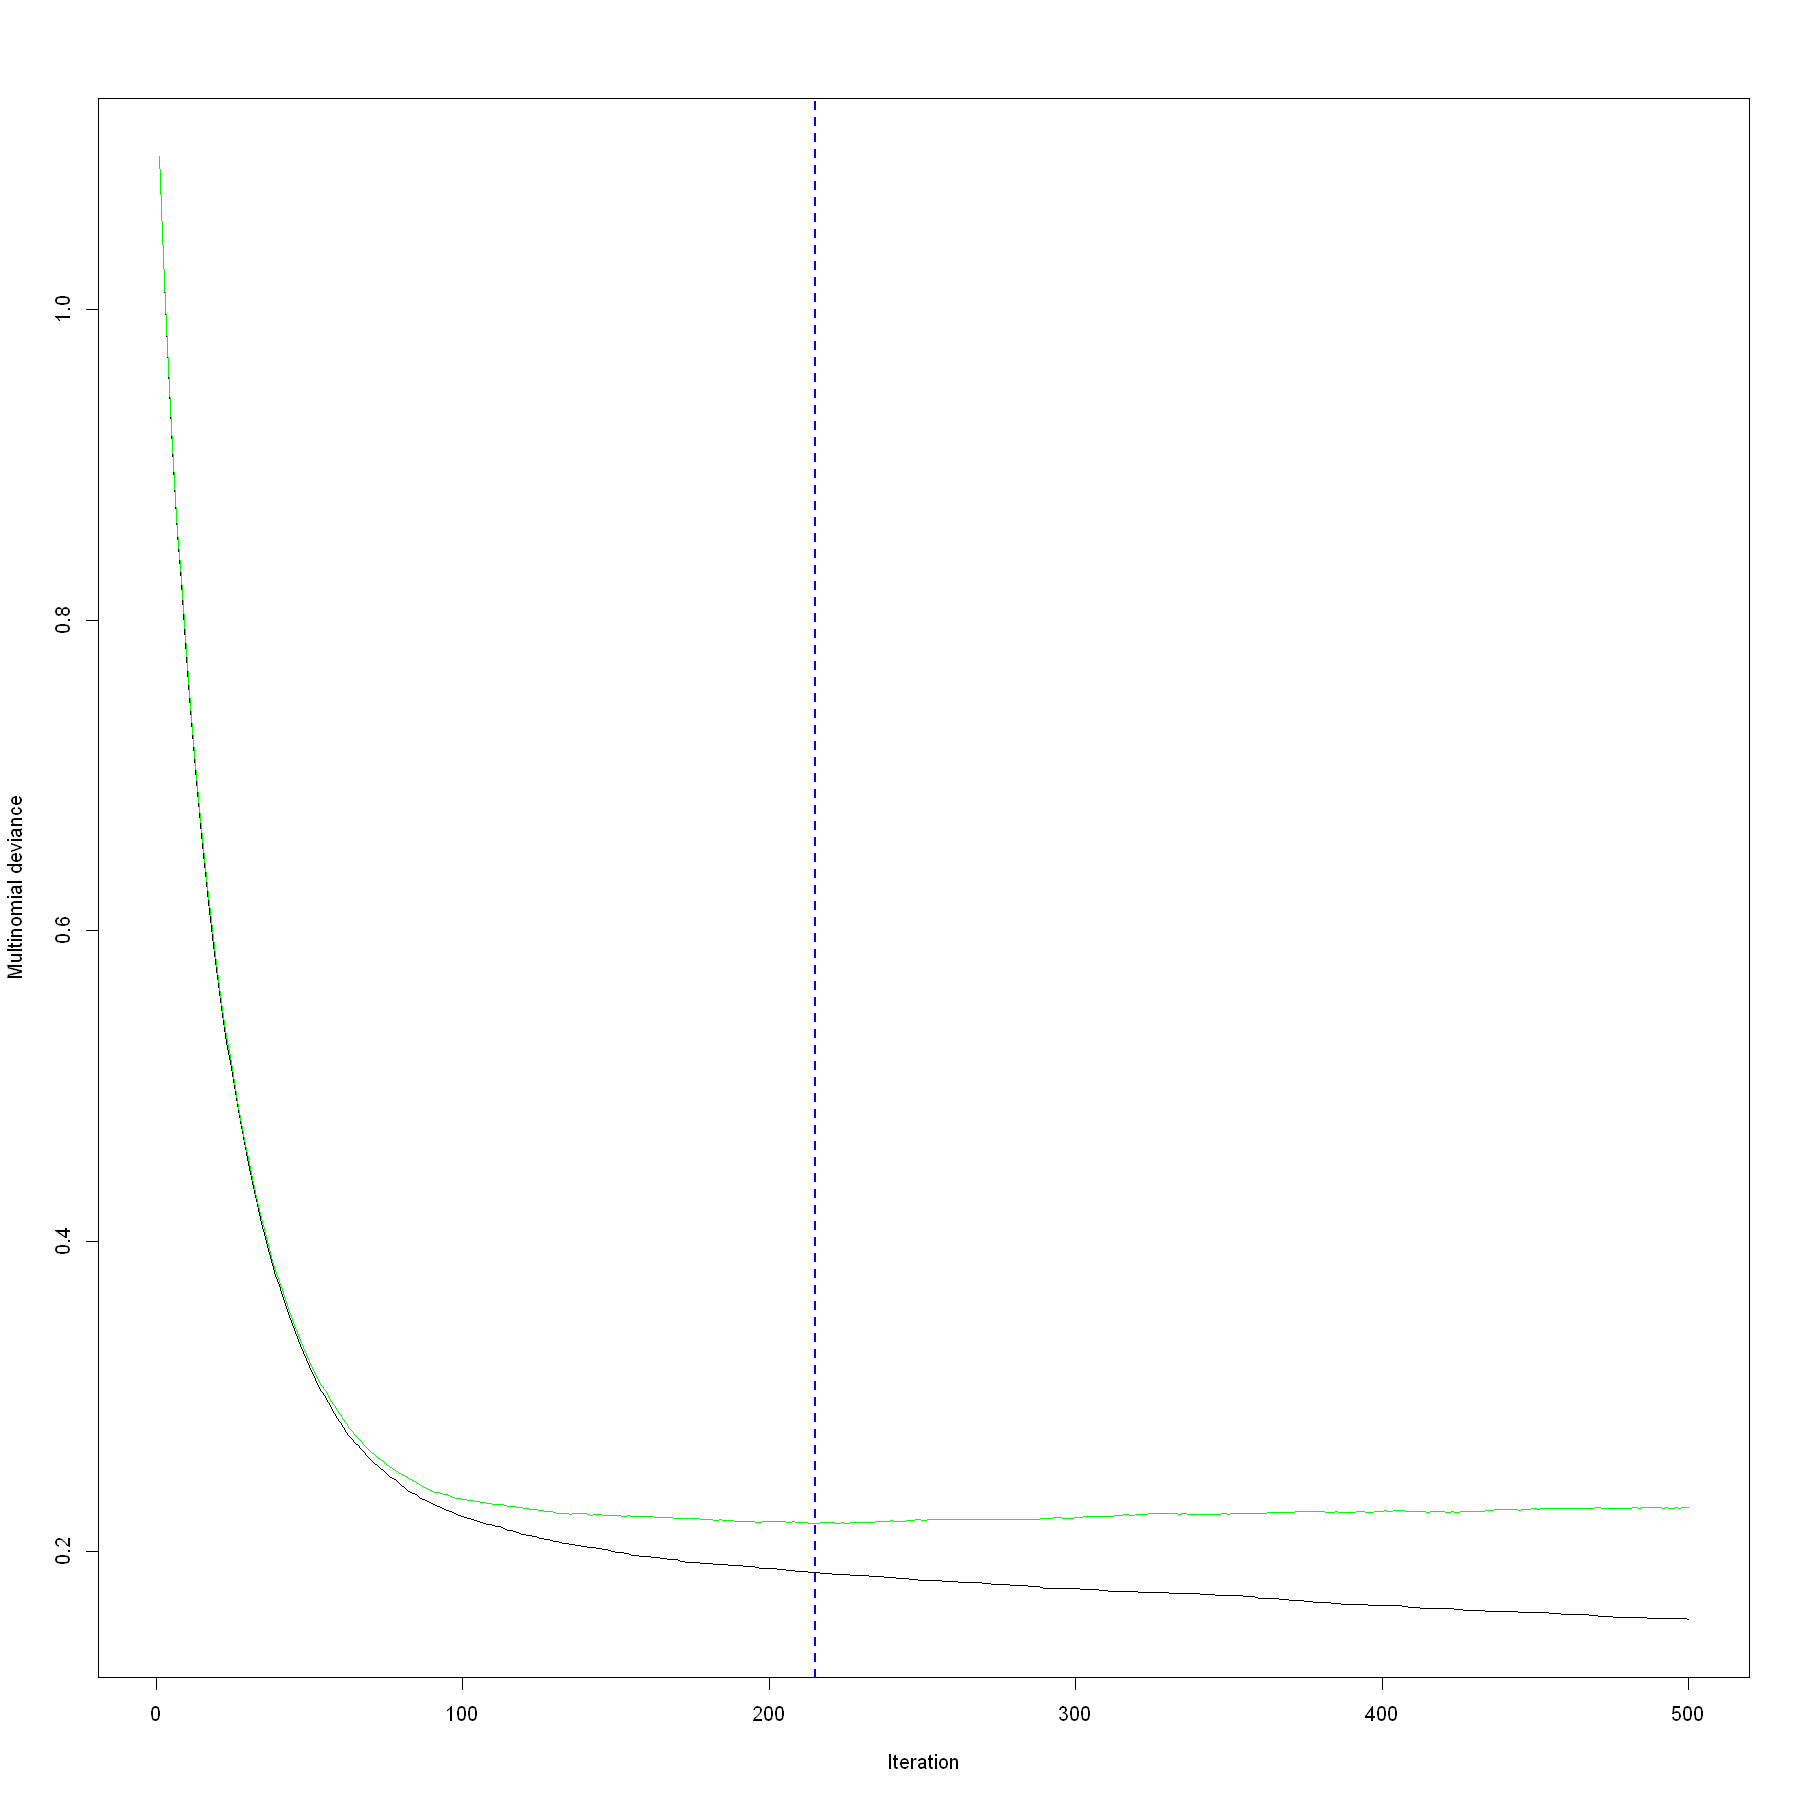

In [192]:
set.seed(1234)

data_exp_boost <- data_exp_norm
data_exp_boost$Experience_Level <- as.numeric(data_exp_boost$Experience_Level) - 1  # pour gbm: 0, 1, 2

boost.exp <- gbm(
  Experience_Level ~ .,
  data = data_exp_boost,
  distribution = "multinomial",  
  n.trees = 500,
  cv.folds = 10,
  n.minobsinnode = 5,
  shrinkage = 0.03,
  verbose = FALSE
)

# Visualiser l’erreur en fonction du nombre d’arbres
plot(boost.exp$cv.error, type = "l", main = "Erreur de CV - Boosting")

# Nombre optimal d’arbres
best.iter <- gbm.perf(boost.exp, method = "cv")

In [195]:
# Prédictions sur les données de test

data_test_boost <- data_test_norm
data_test_boost$Experience_Level <- as.numeric(as.factor(data_test_boost$Experience_Level)) - 1

# Prédictions (type = "response" donne des probabilités par classe)
pred_probs <- predict(boost.exp, newdata = data_test_boost[,-14], n.trees = best.iter, type = "response")

# On choisit la classe avec la plus grande probabilité
pred_classes <- apply(pred_probs, 1, which.max) - 1

# Matrice de confusion
conf_matrix_boost <- table(Vrai = data_test_boost$Experience_Level, Prédit = pred_classes)
print(conf_matrix_boost)
pourcentage_erreur(conf_matrix_boost)

    Prédit
Vrai  0  1  2
   0 58 17  0
   1  3 78  0
   2  0  0 38
[1] "Pourcentage d'erreur : 10.31 %"


**XGBoost**

In [341]:
set.seed(1234)

X_train <- model.matrix(Experience_Level ~ . -1, data = data_exp)
y_train <- as.numeric(data_exp$Experience_Level) - 1

# Paramètres XGBoost de base pour classification multi-classes
params <- list(
  objective = "multi:softprob",
  num_class = 3,
  eval_metric = "mlogloss"
)

# Validation croisée avec 5 folds, 100 itérations max
cv <- xgb.cv(
  params = params,
  data = X_train,
  label = y_train,
  nrounds = 100,
  nfold = 5,
  stratified = TRUE,
  verbose = TRUE,
  early_stopping_rounds = 10,  # stop si pas d'amélioration sur 10 rounds
  maximize = FALSE
)

print(cv)

best_nrounds <- cv$best_iteration
cat("Meilleur nombre d'itérations : ", best_nrounds, "\n")

xgb_model_final <- xgboost(
  params = params,
  data = X_train,
  label = y_train,
  nrounds = best_nrounds,
  verbose = FALSE
)

[1]	train-mlogloss:0.773910+0.002314	test-mlogloss:0.783505+0.008807 
Multiple eval metrics are present. Will use test_mlogloss for early stopping.
Will train until test_mlogloss hasn't improved in 10 rounds.

[2]	train-mlogloss:0.585847+0.002644	test-mlogloss:0.604990+0.013054 
[3]	train-mlogloss:0.462944+0.003179	test-mlogloss:0.489757+0.017343 
[4]	train-mlogloss:0.377286+0.003244	test-mlogloss:0.410644+0.019568 
[5]	train-mlogloss:0.317380+0.003681	test-mlogloss:0.355815+0.022114 
[6]	train-mlogloss:0.273400+0.004191	test-mlogloss:0.316924+0.024436 
[7]	train-mlogloss:0.238885+0.005634	test-mlogloss:0.287791+0.026134 
[8]	train-mlogloss:0.212288+0.005097	test-mlogloss:0.267944+0.027090 
[9]	train-mlogloss:0.192048+0.004711	test-mlogloss:0.253902+0.027179 
[10]	train-mlogloss:0.175316+0.003780	test-mlogloss:0.243665+0.028918 
[11]	train-mlogloss:0.160894+0.004374	test-mlogloss:0.236472+0.030478 
[12]	train-mlogloss:0.147433+0.003447	test-mlogloss:0.232090+0.031827 
[13]	train-mloglo

In [343]:
probabilities_boost <- predict(xgb_model_final, X_test)
probabilities_boost <- as.data.frame(matrix(probabilities_boost, ncol = 3, byrow = TRUE))

colnames(probabilities_boost) <- as.character(1:3)
pred_class <- max.col(probabilities_boost)

true_class <- y_test + 1

confusion_matrix_boost <- table(Predicted = pred_class, Actual = true_class)
print(confusion_matrix_boost)
pourcentage_erreur(confusion_matrix_boost)

         Actual
Predicted  1  2  3
        1 57  8  0
        2 18 73  0
        3  0  0 38
[1] "Pourcentage d'erreur : 13.4 %"


# 2.2.4 RdN

A faire

# 2.2.5 Comparaison des méthodes

A faire

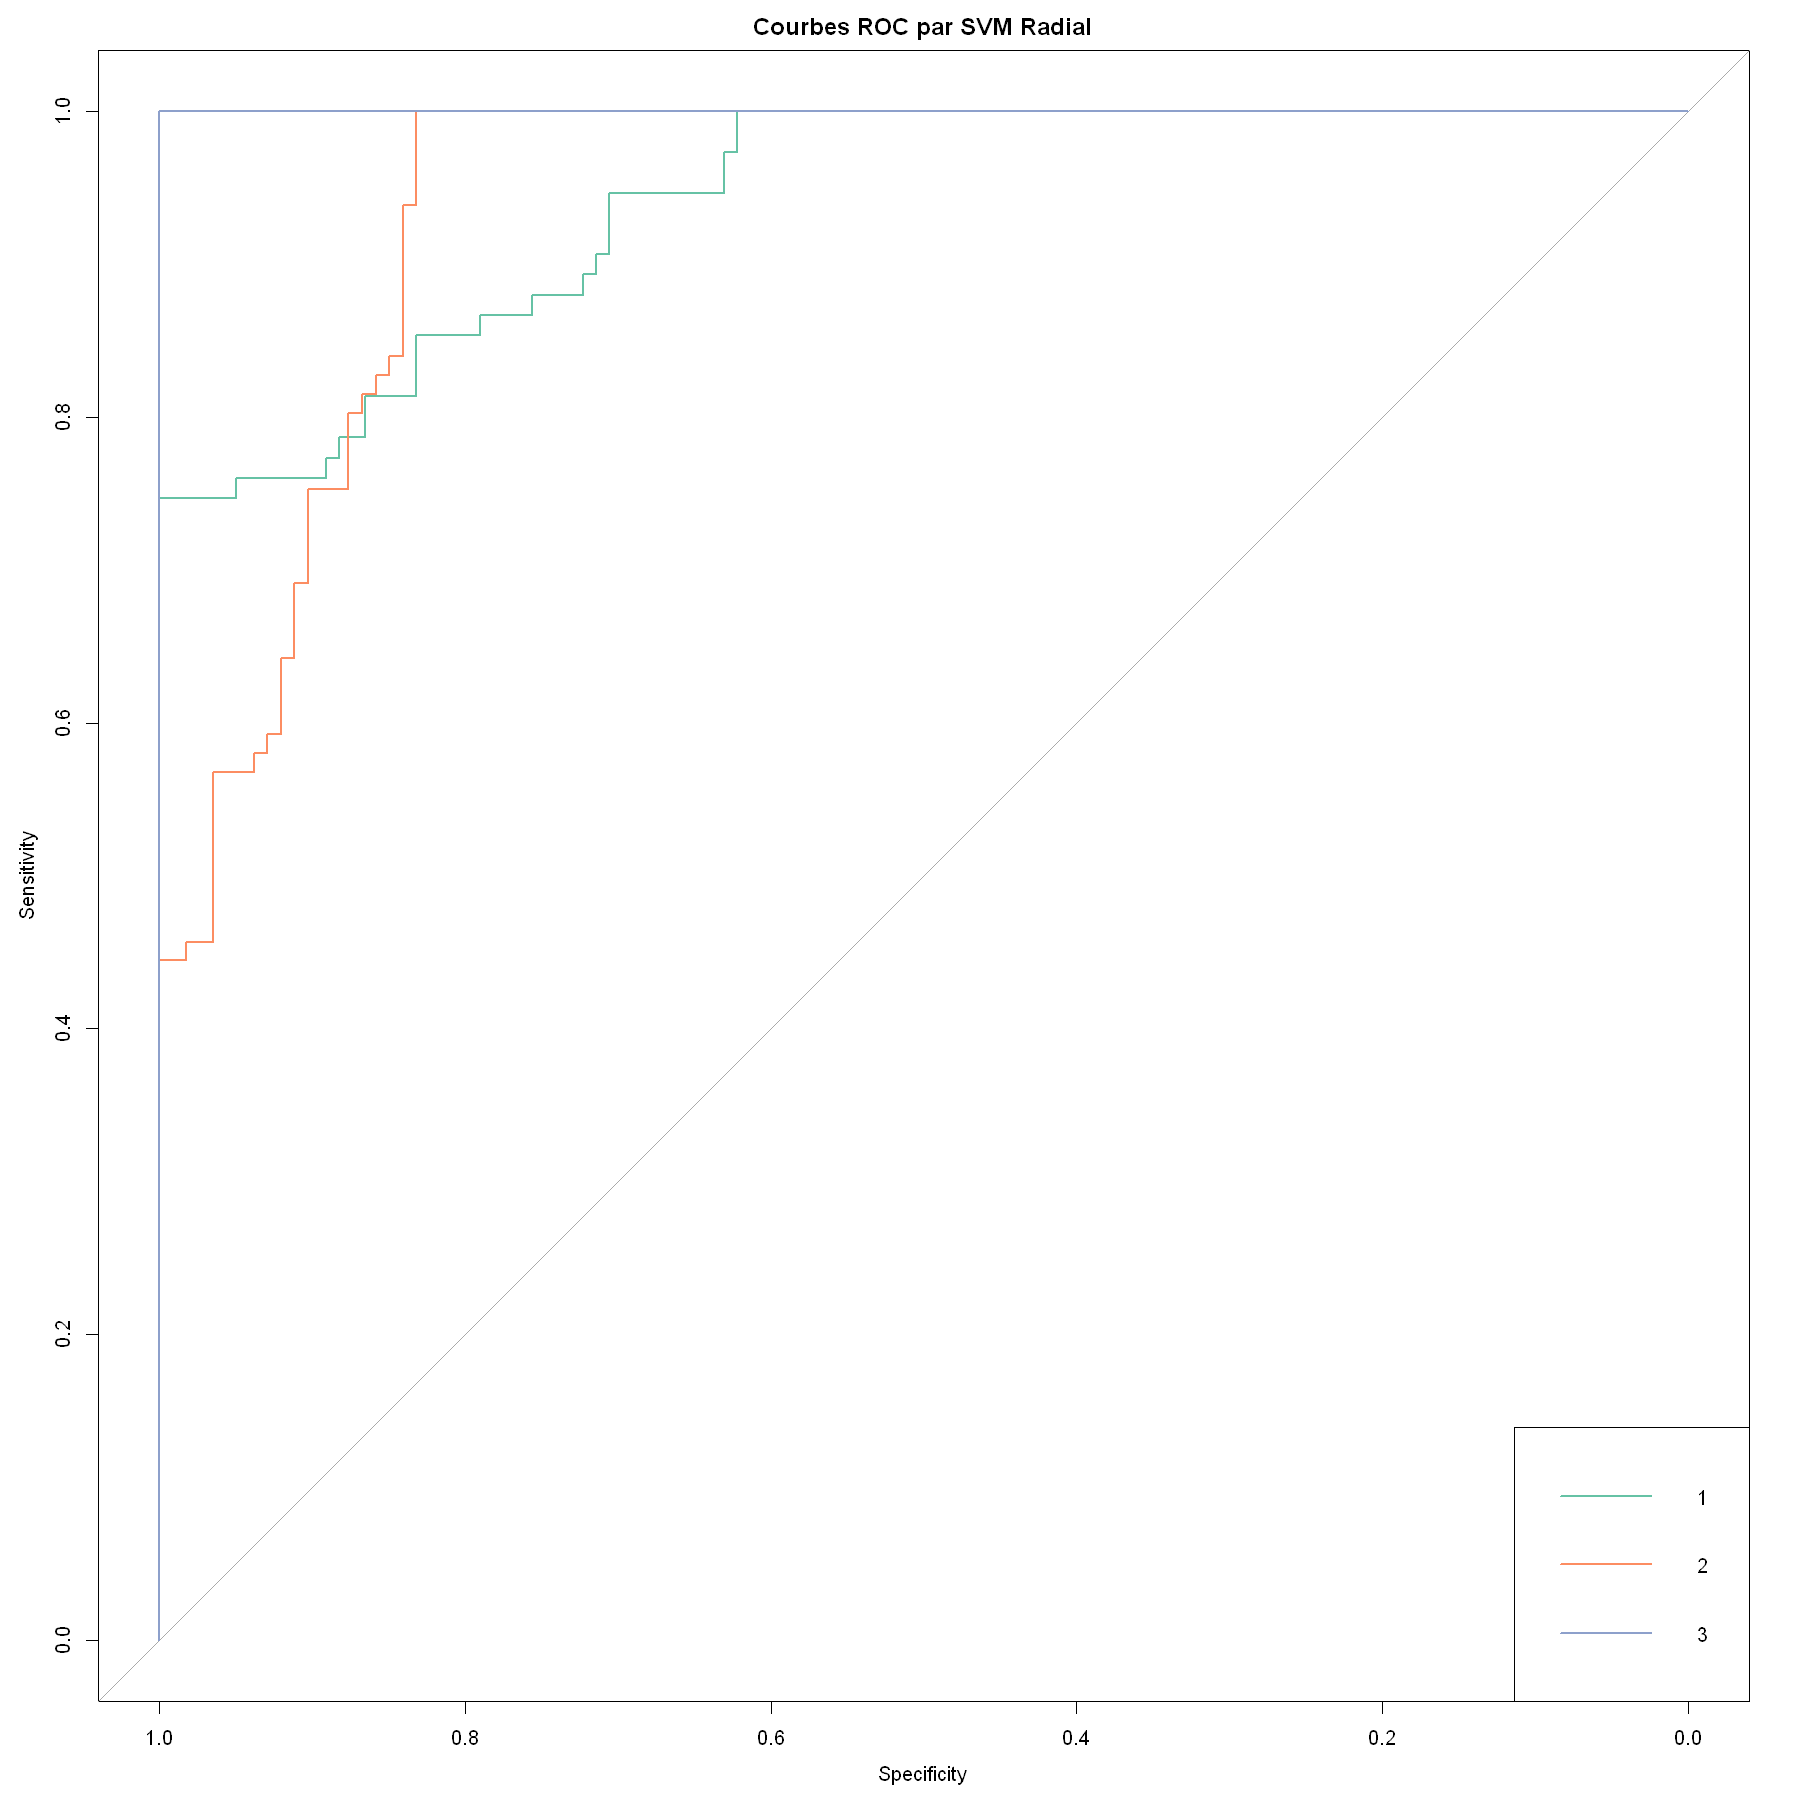

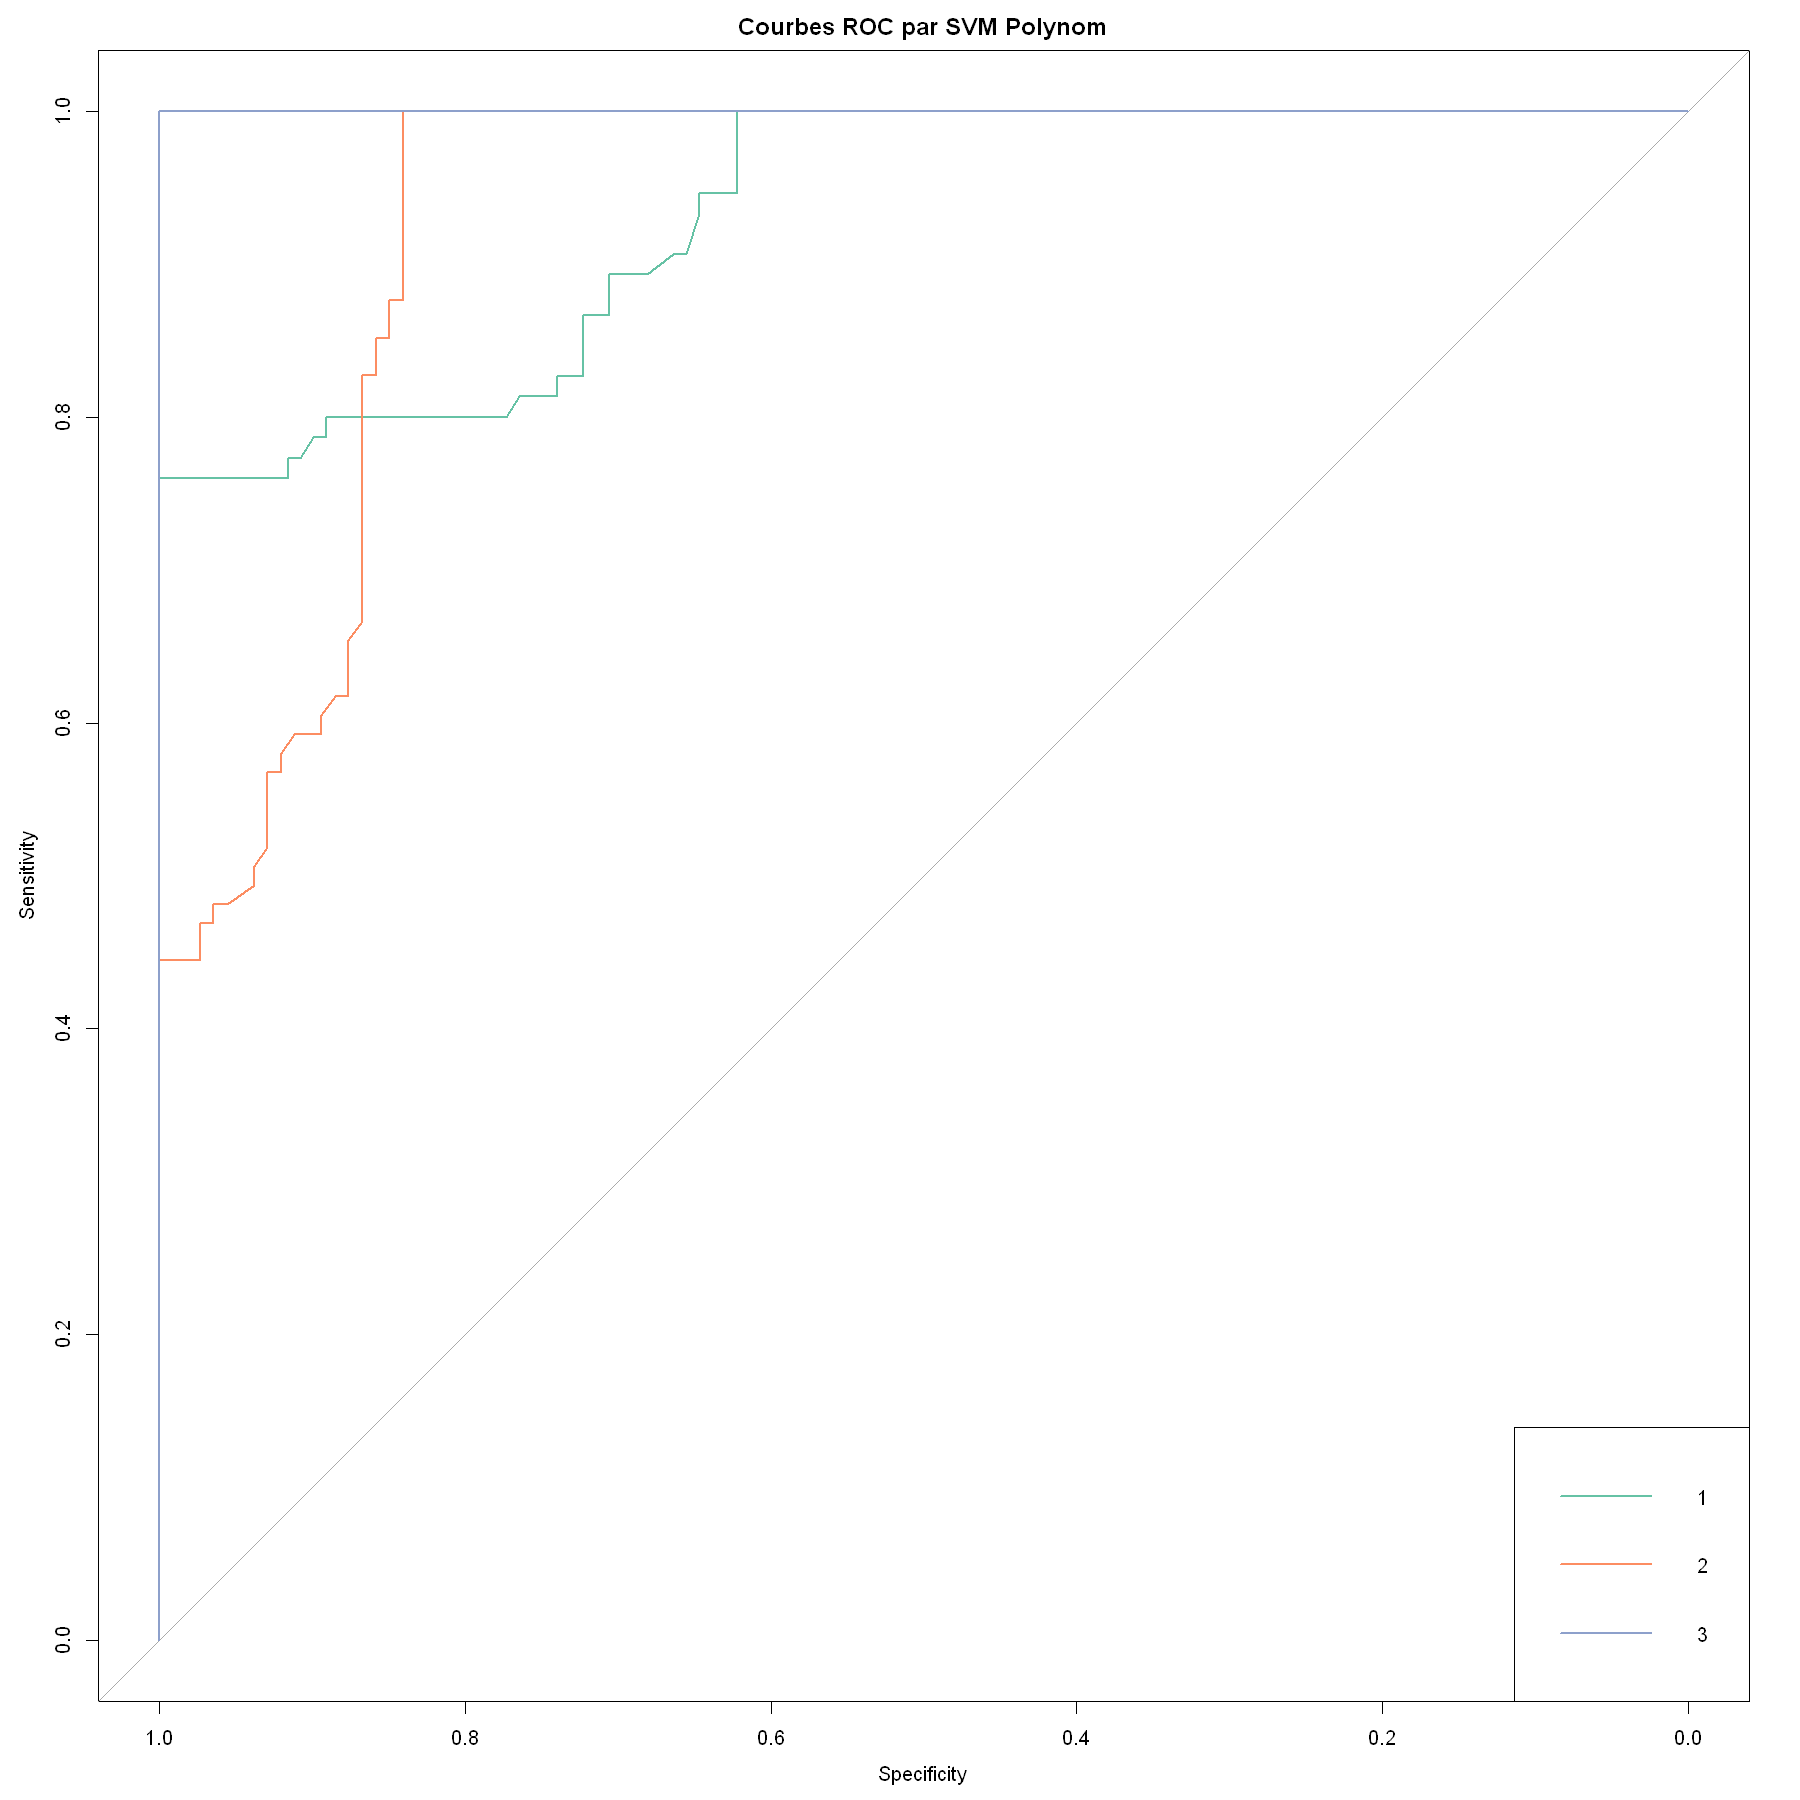

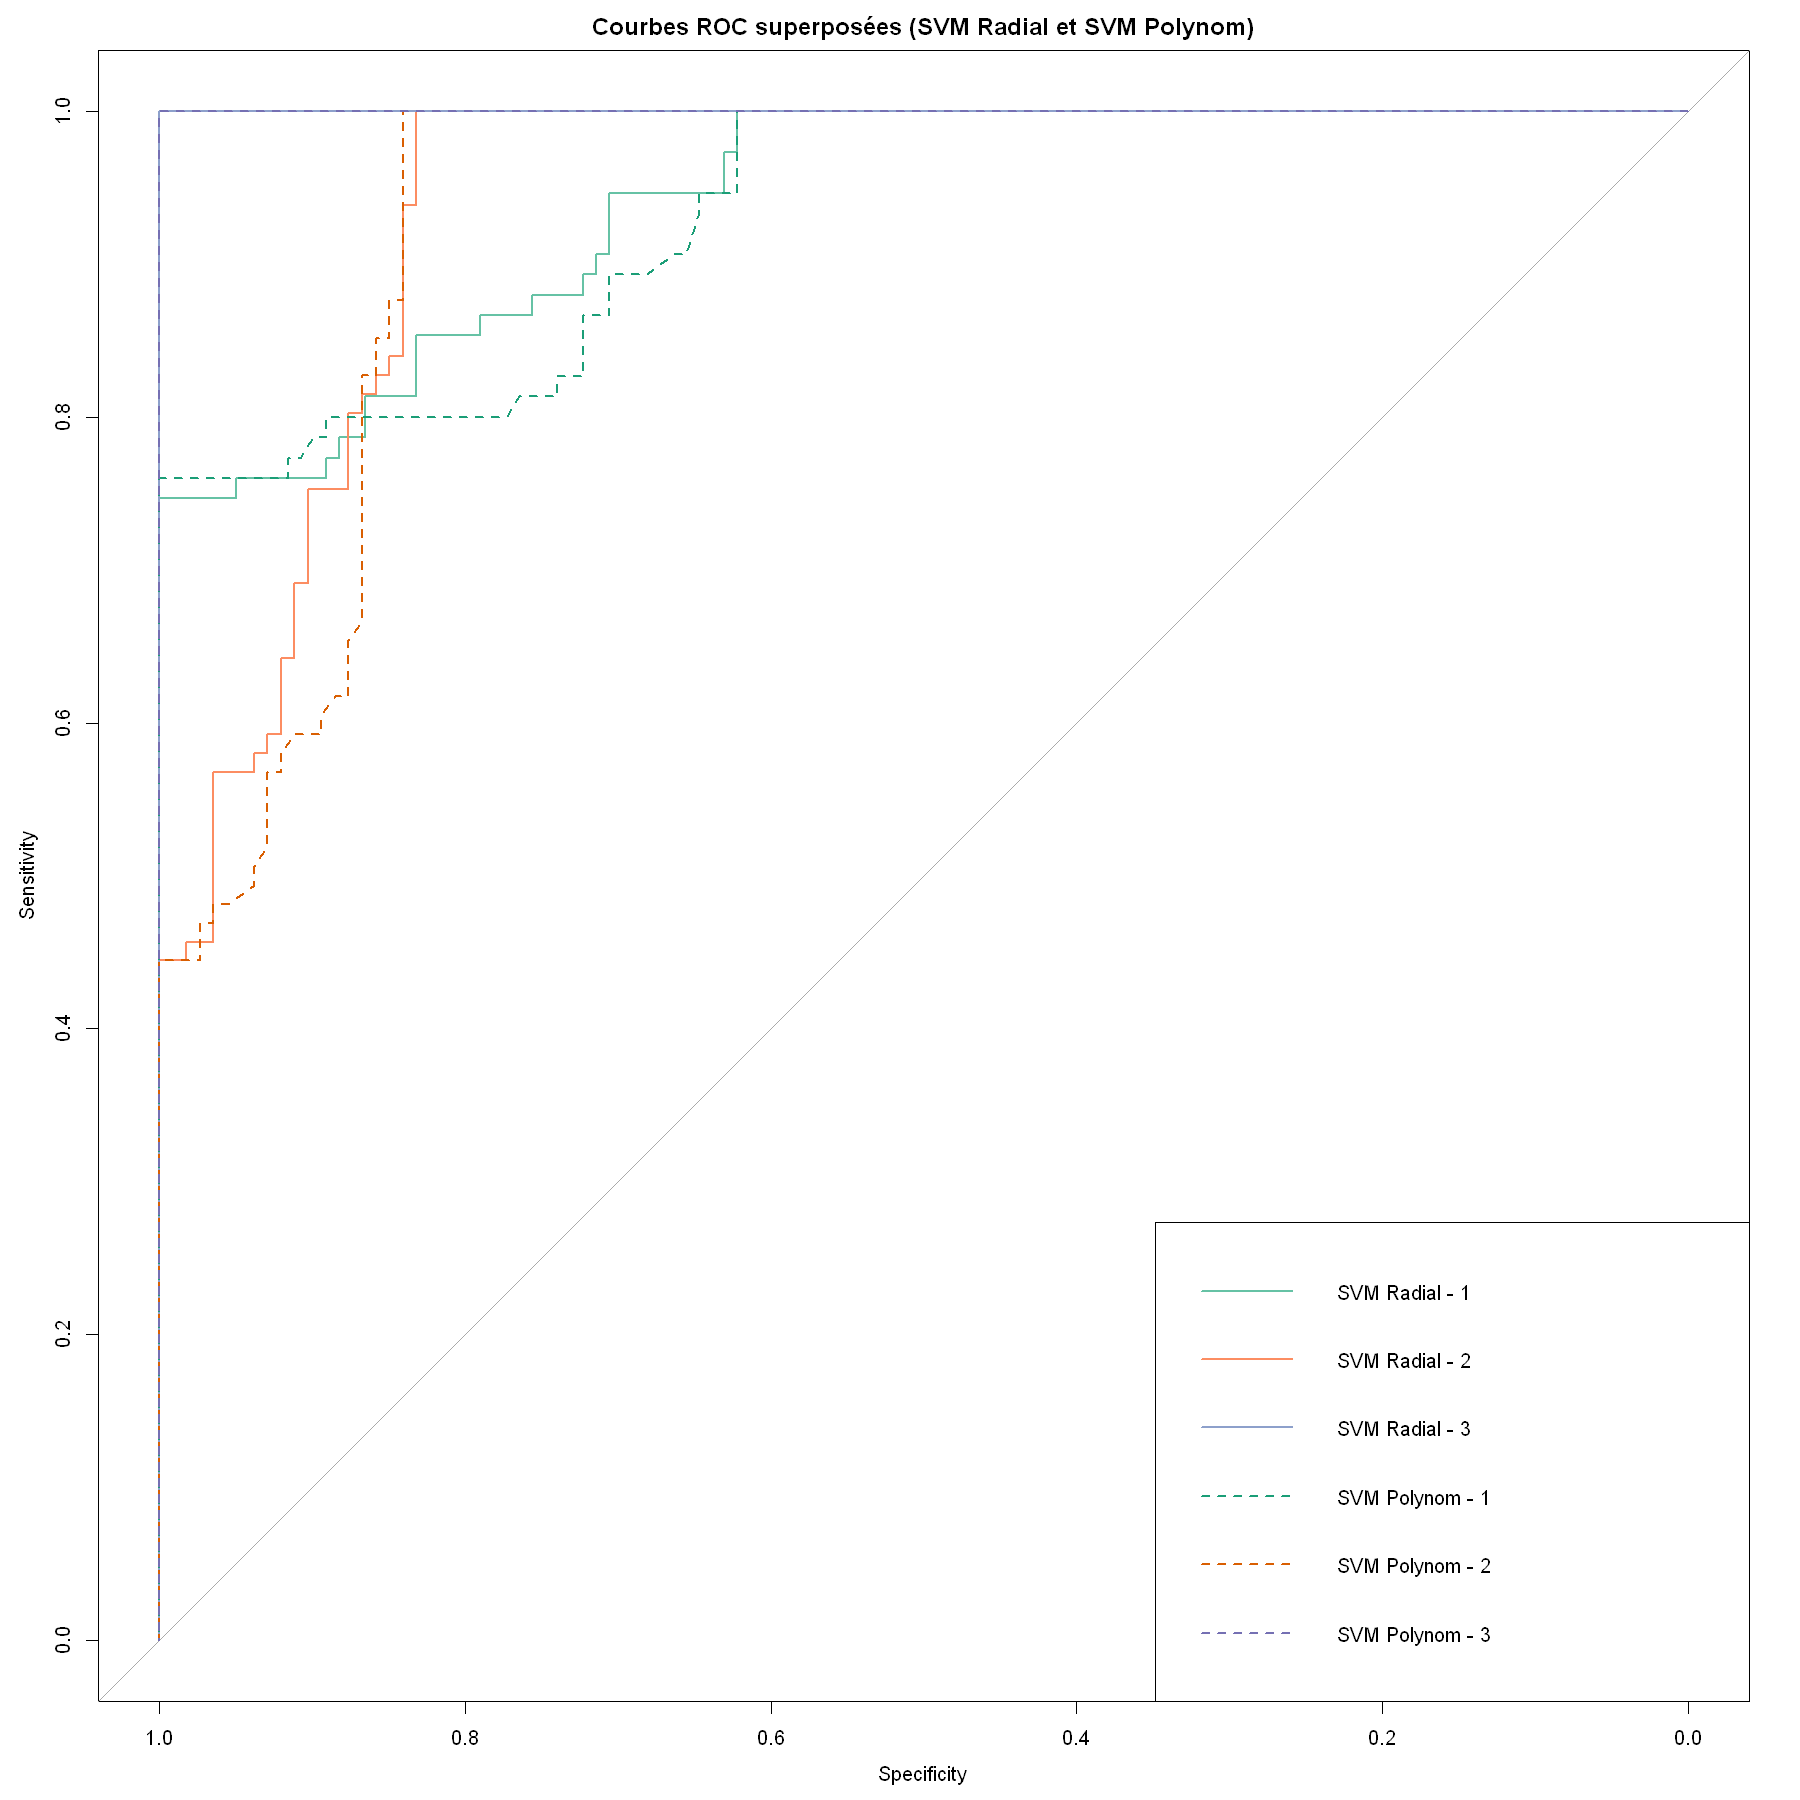

In [356]:
plot_roc_curves(probabilities_boost, "SVM Radial")
plot_roc_curves(probabilities_rfq, "SVM Polynom")

plot_superposed_roc_curves(probabilities_boost, "SVM Radial", probabilities_rfq, "SVM Polynom")